## Chronos_Fx-Price Only Monthly


##Install

In [30]:
pip install chronos-forecasting

In [31]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")


## Data Loader

In [32]:
from __future__ import annotations

import io, time
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import requests, certifi


@dataclass
class DataConfig:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    retries: int = 3
    timeout: int = 60


DATA_CFG = DataConfig()


def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


def load_fx_series_daily_and_business(
    url: str,
    series: str = "EUR_NOK",
    retries: int = 3,
    timeout: int = 60,
) -> Tuple[pd.Series, pd.Series]:
    """
    Load (Date, series) from CSV.
    Returns:
      S_b: business-day (B) ffilled
      S_d: calendar-day (D) ffilled
    """
    text = download_csv_text(url, retries, timeout)
    raw = pd.read_csv(io.StringIO(text))

    required = {"Date", series}
    missing = required - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[["Date", series]]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", series])
        .sort_values("DATE")
        .set_index("DATE")
    )

    df[series] = pd.to_numeric(df[series], errors="coerce")
    df = df.dropna(subset=[series])
    if df.empty:
        raise ValueError("Dataset is empty after cleaning.")

    S_b = df[series].asfreq("B").ffill().astype(float)
    S_b.name = series

    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    S_d = df[series].reindex(full_idx).ffill().astype(float)
    S_d.index.name = "DATE"
    S_d.name = series

    return S_b, S_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


## Eval

In [33]:
# =========================
# eval_common_monthly (M)
# =========================
from __future__ import annotations
import math
from typing import Tuple, Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

EVAL_MONTHLY = {}

def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true: pd.Series, y_model: pd.Series, y_rw: pd.Series, h: int = 1, loss: str = "mse") -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = (np.abs(e_m) - np.abs(e_r)) if loss.lower() == "mae" else ((e_m**2) - (e_r**2))

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    # HAC Newey–West Bartlett up to h-1
    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return float(dm_stat), float(p_val)

def evaluate_period_df_monthly(
    period_df: pd.DataFrame,
    *,
    loss: str = "mse",
    h: int = 1,
    label: str = "Model",
    print_output: bool = True,
) -> Tuple[pd.DataFrame, Dict]:
    """
    Forventer period_df indeksert på PeriodIndex(freq='M') og kolonner:
      - y_true, y_pred
      - cut_level  (RW benchmark ved cut; driftless)
    """
    df = period_df.copy()
    required = {"y_true", "y_pred", "cut_level"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Mangler kolonner: {missing}. Legg til cut_level=float(S_b.loc[cut]) i walk-forward.")

    core = df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    core["err"] = core["y_true"] - core["y_pred"]

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else float("nan")
    mae  = float(np.mean(np.abs(core["err"]))) if n_obs else float("nan")

    # Directional accuracy på periodemidler
    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    total = int(mask.sum())
    hits = 0
    dir_acc = float("nan")
    if total:
        dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
        dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
        hits = int((dir_true.values == dir_pred.values).sum())
        dir_acc = float(hits / total)

    # RW (cut-level)
    core["rw_pred"] = core["cut_level"].astype(float)

    dm_stat, p_val = dm_test(core["y_true"], core["y_pred"], core["rw_pred"], h=h, loss=loss)

    # Konvensjon: DM < 0 => bedre enn RW (lavere gj.snittlig loss)
    better_than_rw = bool(np.isfinite(dm_stat) and dm_stat < 0)
    sig = ""
    if better_than_rw and np.isfinite(p_val):
        if p_val < 0.01: sig = "***"
        elif p_val < 0.05: sig = "**"
        elif p_val < 0.10: sig = "*"

    res = dict(
        label=label,
        observations=n_obs,
        rmse=rmse,
        mae=mae,
        dir_hits=int(hits),
        dir_total=int(total),
        dir_acc=dir_acc,
        dm_stat=float(dm_stat) if np.isfinite(dm_stat) else float("nan"),
        dm_pvalue=float(p_val) if np.isfinite(p_val) else float("nan"),
        better_than_rw=better_than_rw,
        sig=sig,
    )

    if print_output:
        print(f"\n=== {label} (monthly mean) ===")
        print(f"Observations: {n_obs}")
        print(f"RMSE (level): {rmse:.6f}")
        print(f"MAE  (level): {mae:.6f}")
        if total:
            print(f"Directional accuracy: {hits}/{total} ({dir_acc*100:.1f}%)")
        print("\n=== Diebold–Mariano vs Random Walk (cut-level RW) ===")
        print(f"Loss: {loss.upper()} | horizon h={h}")
        print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
        print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")
        if sig:
            print(f"Significance: {sig} (model better than RW)")

    return core, res

def plot_period_simple_monthly(
    period_df: pd.DataFrame,
    *,
    title: str,
    png_path: str,
    pdf_path: Optional[str] = None,
    y_label: str = "Level",
    show: bool = True,
) -> None:
    df = period_df.dropna(subset=["y_true", "y_pred"]).copy()
    if df.empty:
        print("Nothing to plot.")
        return

    x = df.index.to_timestamp() if isinstance(df.index, pd.PeriodIndex) else df.index

    plt.figure(figsize=(10, 6))
    plt.plot(x, df["y_true"], color="black", label="Actual (monthly mean)")
    plt.plot(x, df["y_pred"], color="tab:blue", linestyle="--", label="Forecast")
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    if pdf_path:
        plt.savefig(pdf_path, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

    print(f"Saved: {png_path}")
    if pdf_path:
        print(f"Saved: {pdf_path}")

EVAL_MONTHLY["evaluate_period_df"] = evaluate_period_df_monthly
EVAL_MONTHLY["plot_period_simple"] = plot_period_simple_monthly
print("Loaded eval_common_monthly: EVAL_MONTHLY['evaluate_period_df'], EVAL_MONTHLY['plot_period_simple']")


Loaded eval_common_monthly: EVAL_MONTHLY['evaluate_period_df'], EVAL_MONTHLY['plot_period_simple']


In [34]:
# =========================
# eval_common_quarterly (Q-DEC)
# =========================
from __future__ import annotations
import math
from typing import Tuple, Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

EVAL_QUARTERLY = {}

def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true: pd.Series, y_model: pd.Series, y_rw: pd.Series, h: int = 1, loss: str = "mse") -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = (np.abs(e_m) - np.abs(e_r)) if loss.lower() == "mae" else ((e_m**2) - (e_r**2))

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    # HAC Newey–West Bartlett up to h-1
    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return float(dm_stat), float(p_val)

def evaluate_period_df_quarterly(
    period_df: pd.DataFrame,
    *,
    loss: str = "mse",
    h: int = 1,
    label: str = "Model",
    print_output: bool = True,
) -> Tuple[pd.DataFrame, Dict]:
    """
    Forventer period_df indeksert på PeriodIndex(freq='Q-DEC') og kolonner:
      - y_true, y_pred
      - cut_level  (RW benchmark ved cut; driftless)
    """
    df = period_df.copy()
    required = {"y_true", "y_pred", "cut_level"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Mangler kolonner: {missing}. Legg til cut_level=float(S_b.loc[cut]) i walk-forward.")

    core = df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    core["err"] = core["y_true"] - core["y_pred"]

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else float("nan")
    mae  = float(np.mean(np.abs(core["err"]))) if n_obs else float("nan")

    # Directional accuracy på periodemidler
    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    total = int(mask.sum())
    hits = 0
    dir_acc = float("nan")
    if total:
        dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
        dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
        hits = int((dir_true.values == dir_pred.values).sum())
        dir_acc = float(hits / total)

    # RW (cut-level)
    core["rw_pred"] = core["cut_level"].astype(float)

    dm_stat, p_val = dm_test(core["y_true"], core["y_pred"], core["rw_pred"], h=h, loss=loss)

    # Konvensjon: DM < 0 => bedre enn RW (lavere gj.snittlig loss)
    better_than_rw = bool(np.isfinite(dm_stat) and dm_stat < 0)
    sig = ""
    if better_than_rw and np.isfinite(p_val):
        if p_val < 0.01: sig = "***"
        elif p_val < 0.05: sig = "**"
        elif p_val < 0.10: sig = "*"

    res = dict(
        label=label,
        observations=n_obs,
        rmse=rmse,
        mae=mae,
        dir_hits=int(hits),
        dir_total=int(total),
        dir_acc=dir_acc,
        dm_stat=float(dm_stat) if np.isfinite(dm_stat) else float("nan"),
        dm_pvalue=float(p_val) if np.isfinite(p_val) else float("nan"),
        better_than_rw=better_than_rw,
        sig=sig,
    )

    if print_output:
        print(f"\n=== {label} (quarterly mean) ===")
        print(f"Observations: {n_obs}")
        print(f"RMSE (level): {rmse:.6f}")
        print(f"MAE  (level): {mae:.6f}")
        if total:
            print(f"Directional accuracy: {hits}/{total} ({dir_acc*100:.1f}%)")
        print("\n=== Diebold–Mariano vs Random Walk (cut-level RW) ===")
        print(f"Loss: {loss.upper()} | horizon h={h}")
        print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
        print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")
        if sig:
            print(f"Significance: {sig} (model better than RW)")

    return core, res

def plot_period_simple_quarterly(
    period_df: pd.DataFrame,
    *,
    title: str,
    png_path: str,
    pdf_path: Optional[str] = None,
    y_label: str = "Level",
    show: bool = True,
) -> None:
    df = period_df.dropna(subset=["y_true", "y_pred"]).copy()
    if df.empty:
        print("Nothing to plot.")
        return

    x = df.index.to_timestamp() if isinstance(df.index, pd.PeriodIndex) else df.index

    plt.figure(figsize=(10, 6))
    plt.plot(x, df["y_true"], color="black", label="Actual (quarterly mean)")
    plt.plot(x, df["y_pred"], color="tab:blue", linestyle="--", label="Forecast")
    plt.title(title)
    plt.xlabel("Quarter")
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    if pdf_path:
        plt.savefig(pdf_path, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

    print(f"Saved: {png_path}")
    if pdf_path:
        print(f"Saved: {pdf_path}")

EVAL_QUARTERLY["evaluate_period_df"] = evaluate_period_df_quarterly
EVAL_QUARTERLY["plot_period_simple"] = plot_period_simple_quarterly
print("Loaded eval_common_quarterly: EVAL_QUARTERLY['evaluate_period_df'], EVAL_QUARTERLY['plot_period_simple']")


Loaded eval_common_quarterly: EVAL_QUARTERLY['evaluate_period_df'], EVAL_QUARTERLY['plot_period_simple']


## PO

### M

Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Chronos-2 (price-only) (monthly mean) ===
Observations: 308
RMSE (level): 0.144389
MAE  (level): 0.097390
Directional accuracy: 215/307 (70.0%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: 1.3264
p-value     : 0.1847


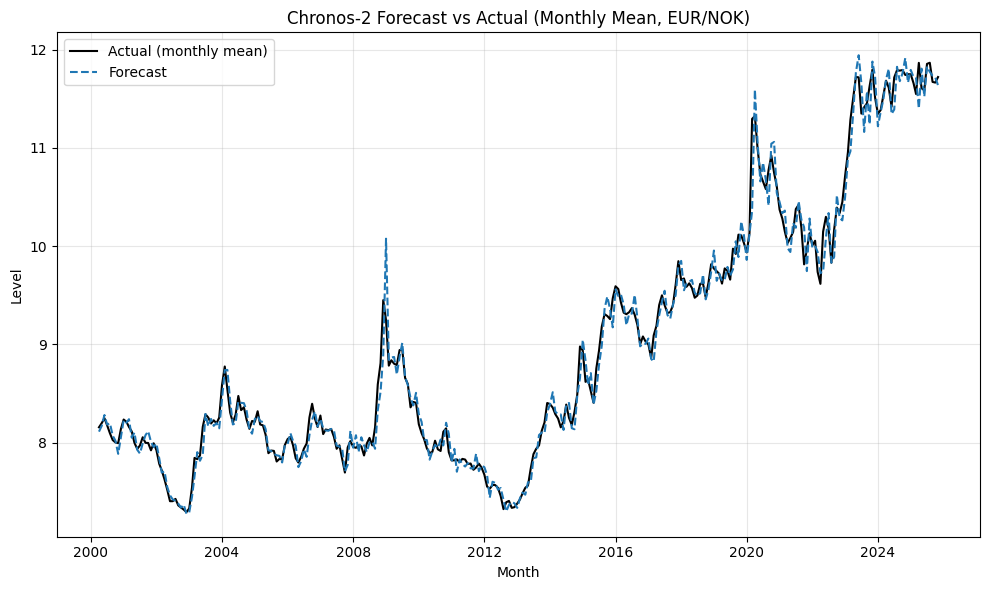

Saved: Chronos2M.png
Saved: Chronos2M.pdf


In [ ]:
from __future__ import annotations

import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, Callable

import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline  # pip install chronos-forecasting


@dataclass
class ModelConfig:
    target_series: str = "EUR_NOK"
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    verbose: bool = True
    fig_png: str = "Chronos2M.png"
    fig_pdf: str = "Chronos2M.pdf"
    device_map: str = "cuda"
    dtype: torch.dtype = torch.float16
    model_id: str = "amazon/chronos-2"


CFG = ModelConfig()


def build_chronos2_forecast_fn(max_context: int) -> Callable[[np.ndarray, int], np.ndarray]:
    if CFG.device_map == "cuda" and not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Use CUDA runtime, or set device_map='cpu'.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        CFG.model_id,
        device_map=CFG.device_map,
        dtype=CFG.dtype,
    )

    def _extract_median(pred: pd.DataFrame) -> np.ndarray:
        if "timestamp" in pred.columns:
            pred = pred.sort_values("timestamp")
        if "0.5" in pred.columns:
            return pred["0.5"].to_numpy()
        if "predictions" in pred.columns:
            return pred["predictions"].to_numpy()
        if "quantile" in pred.columns and "forecast" in pred.columns:
            sel = pred.loc[pred["quantile"] == 0.5, "forecast"]
            if not sel.empty:
                return sel.to_numpy()
        for cand in ("forecast", "p50", "median", "mean"):
            if cand in pred.columns:
                return pred[cand].to_numpy()
        raise RuntimeError(f"Unsupported Chronos predict_df schema: {list(pred.columns)}")

    def forecast_fn(x_1d: np.ndarray, H: int) -> np.ndarray:
        ctx = np.asarray(x_1d, dtype=float).ravel()[-max_context:]
        ts = pd.date_range("2000-01-01", periods=len(ctx), freq="D")
        df = pd.DataFrame({"item_id": "series_1", "timestamp": ts, "target": ctx})

        with torch.inference_mode():
            pred = pipeline.predict_df(df, prediction_length=int(H), quantile_levels=[0.5])

        out = np.asarray(_extract_median(pred), dtype=float).ravel()
        if out.shape[0] < H:
            raise RuntimeError(f"Chronos returned horizon {out.shape[0]} < H={H}")
        return out[:H]

    return forecast_fn


def walk_forward_chronos2_monthly(S_b: pd.Series, S_d: pd.Series, forecast_fn: Callable[[np.ndarray, int], np.ndarray]) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict[str, Dict] = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        hist_d = S_d.loc[:cut]
        if hist_d.size < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue

        y_true = float(S_b.loc[idx_m_b].mean())
        cut_level = float(S_b.loc[cut])  # RW benchmark at cut

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        context = min(CFG.max_context, len(hist_d))
        x = hist_d.values[-context:]
        pf = forecast_fn(x, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {
            "month": m,
            "cut": cut,
            "cut_level": cut_level,   # IMPORTANT for eval_common_monthly
            "y_true": y_true,
            "y_pred": y_pred,
        }

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if (df.empty or m not in df.index)]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return df


def main():
    # 1) Data (from loader cell)
    S_b, S_d = load_fx_series_daily_and_business(
        url=DATA_CFG.url,
        series=CFG.target_series,
        retries=DATA_CFG.retries,
        timeout=DATA_CFG.timeout,
    )

    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {S_d.index.min().date()} → {S_d.index.max().date()} | n={len(S_d)}")

    # 2) Model
    forecast_fn = build_chronos2_forecast_fn(max_context=CFG.max_context)

    # 3) Walk-forward
    df_eval = walk_forward_chronos2_monthly(S_b, S_d, forecast_fn)

    # 4) Unified evaluation + DM (from eval_common_monthly cell)
    core, metrics = EVAL_MONTHLY["evaluate_period_df"](
        df_eval,
        label="Chronos-2 (price-only)",
        loss="mse",
        h=1,
        print_output=True,
    )

    # 5) Unified plot (from eval_common_monthly cell)
    EVAL_MONTHLY["plot_period_simple"](
        df_eval,
        title="Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK)",
        png_path=CFG.fig_png,
        pdf_path=CFG.fig_pdf,
        y_label="Level",
        show=True,
    )

    return core, metrics


core, metrics = main()


### Q

Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Chronos-2 (price-only) (quarterly mean) ===
Observations: 103
RMSE (level): 0.214728
MAE  (level): 0.153969
Directional accuracy: 76/102 (74.5%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: 0.5684
p-value     : 0.5698


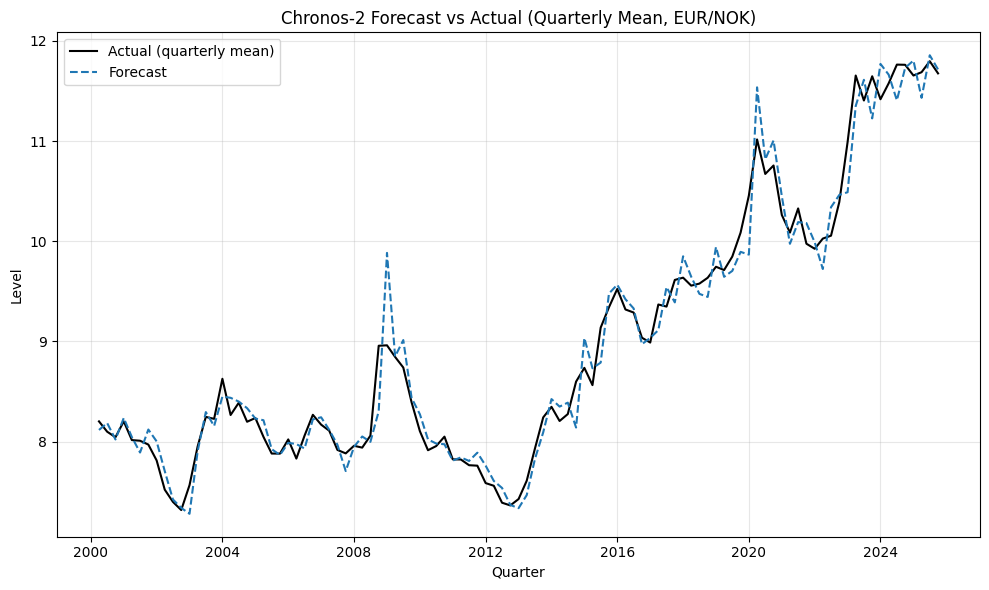

Saved: Chronos2Q.png
Saved: Chronos2Q.pdf


In [ ]:
# ==========================================
# Chronos-2 (price-only) – Quarterly walk-forward
# Bruker:
#   - load_fx_series_daily_and_business (din loader)
#   - EVAL_QUARTERLY['evaluate_period_df'] + ['plot_period_simple'] (din eval_common)
# ==========================================

from __future__ import annotations
import numpy as np
import pandas as pd
import torch
from chronos import BaseChronosPipeline
from dataclasses import dataclass
from typing import Callable, Dict

# -----------------------------
# Config
# -----------------------------
@dataclass
class Config:
    series: str = "EUR_NOK"
    q_freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 128  # > lengste kvartal ~92 dager
    verbose: bool = True
    fig_png: str = "Chronos2Q.png"
    fig_pdf: str = "Chronos2Q.pdf"
    model_id: str = "amazon/chronos-2"
    device_map: str = "cuda"
    dtype: torch.dtype = torch.float16

CFG_Q = Config()

# -----------------------------
# Model wrapper (point forecast, p50)
# -----------------------------
def build_chronos2_forecast_fn(max_context: int) -> Callable[[np.ndarray, int], np.ndarray]:
    if CFG_Q.device_map == "cuda" and not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Set device_map='cpu' or install CUDA PyTorch + driver.")

    pipe: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        CFG_Q.model_id,
        device_map=CFG_Q.device_map,
        dtype=CFG_Q.dtype,
    )

    def _extract_median(pred: pd.DataFrame) -> np.ndarray:
        if "timestamp" in pred.columns:
            pred = pred.sort_values("timestamp")

        if "0.5" in pred.columns:
            return pred["0.5"].to_numpy()

        if "predictions" in pred.columns:
            return pred["predictions"].to_numpy()

        if "quantile" in pred.columns and "forecast" in pred.columns:
            sel = pred.loc[pred["quantile"] == 0.5, "forecast"]
            if not sel.empty:
                return sel.to_numpy()

        for cand in ("forecast", "p50", "median", "mean"):
            if cand in pred.columns:
                return pred[cand].to_numpy()

        raise RuntimeError(f"Chronos predict_df output schema unsupported. Columns={list(pred.columns)}")

    def forecast_fn(x_1d: np.ndarray, H: int) -> np.ndarray:
        ctx = np.asarray(x_1d, dtype=float).ravel()[-max_context:]

        # Chronos trenger bare jevnt tidssteg (datoene er “dummy”)
        ts = pd.date_range("2000-01-01", periods=len(ctx), freq="D")
        df = pd.DataFrame({"item_id": "series_1", "timestamp": ts, "target": ctx})

        with torch.inference_mode():
            pred = pipe.predict_df(df, prediction_length=int(H), quantile_levels=[0.5])

        med = _extract_median(pred)
        out = np.asarray(med, dtype=float).ravel()
        if out.shape[0] < H:
            raise RuntimeError(f"Chronos returned horizon {out.shape[0]} < H={H}")
        return out[:H]

    return forecast_fn

# -----------------------------
# Walk-forward (quarterly) – RETURNERER cut_level
# -----------------------------
def walk_forward_chronos2_quarterly(
    S_b: pd.Series,
    S_d: pd.Series,
    forecast_fn: Callable[[np.ndarray, int], np.ndarray],
) -> pd.DataFrame:
    first_q = pd.Period(S_b.index.min(), freq=CFG_Q.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG_Q.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG_Q.q_freq)

    rows: Dict[str, Dict] = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_d = S_d.loc[:cut]
        if hist_d.size < CFG_Q.min_hist_days:
            dropped[str(q)] = f"hist<{CFG_Q.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue

        y_true = float(S_b.loc[idx_q_b].mean())
        cut_level = float(S_b.loc[cut])  # <-- KRITISK for din eval_common (RW cut-level)

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG_Q.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        x = hist_d.values[-min(CFG_Q.max_context, len(hist_d)):]
        pf = forecast_fn(x, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {
            "quarter": q,
            "cut": cut,
            "cut_level": cut_level,
            "y_true": y_true,
            "y_pred": y_pred,
        }

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()

    if CFG_Q.verbose and dropped:
        miss = [str(q) for q in quarters if (df.empty or q not in df.index)]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return df

# -----------------------------
# Main
# -----------------------------
def main_quarterly_chronos2():
    # 1) Data (DIN loader)
    S_b, S_d = load_fx_series_daily_and_business(
        url=DATA_CFG.url,
        series=CFG_Q.series,
        retries=DATA_CFG.retries,
        timeout=DATA_CFG.timeout,
    )

    if CFG_Q.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {S_d.index.min().date()} → {S_d.index.max().date()} | n={len(S_d)}")

    # 2) Modell
    forecast_fn = build_chronos2_forecast_fn(max_context=CFG_Q.max_context)

    # 3) Walk-forward -> period_df
    period_df = walk_forward_chronos2_quarterly(S_b, S_d, forecast_fn)

    # 4) Eval + DM (DIN eval_common_quarterly)
    core, res = EVAL_QUARTERLY["evaluate_period_df"](
        period_df,
        loss="mse",
        h=1,
        label="Chronos-2 (price-only)",
        print_output=True,
    )

    # 5) Plot (DIN plot)
    EVAL_QUARTERLY["plot_period_simple"](
        core,
        title="Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK)",
        png_path=CFG_Q.fig_png,
        pdf_path=CFG_Q.fig_pdf,
        y_label="Level",
        show=True,
    )

    return core, res

core_q, res_q = main_quarterly_chronos2()


## EN

### M

Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['EUR_NOK', 'Q', 'd_pi', 'dI_t']


`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!



Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Chronos-2 (past macro covariates) (monthly mean) ===
Observations: 308
RMSE (level): 0.140595
MAE  (level): 0.096249
Directional accuracy: 214/307 (69.7%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: 0.6574
p-value     : 0.5109


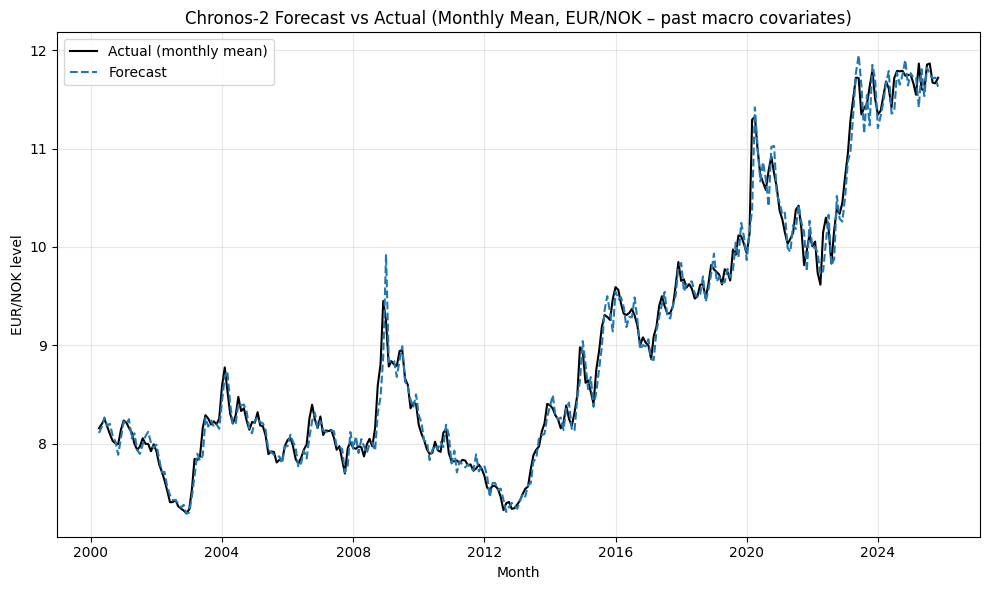

Saved: Chronos2M_daily_pastcov.png
Saved: Chronos2M_daily_pastcov.pdf


In [ ]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (monthly, levels) with daily macro covariates
- Target: EUR_NOK
- Macros: Q, d_pi, dI_t as past-only covariates (no future_df)
- Cut: last business day of previous month (based on EUR_NOK B-days)
- Forecast: next calendar month daily, aggregated to monthly mean over business days
- Evaluation: uses EVAL_MONTHLY with cut_level RW benchmark (driftless)
"""

from __future__ import annotations
import io, time
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_pastcov.png"
    fig_pdf: str = "Chronos2M_daily_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
MACRO_COLS = ["Q", "d_pi", "dI_t"]


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading: daily EUR_NOK (B + D) + macro covariates
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B) with ffill
      DF_d : daily (D) DataFrame with columns [EUR_NOK, Q, d_pi, dI_t], ffilled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES, *MACRO_COLS}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[["Date", TARGET_SERIES] + MACRO_COLS]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in [TARGET_SERIES] + MACRO_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.dropna(subset=[TARGET_SERIES])
    if df.empty:
        raise ValueError("Dataset is empty after cleaning.")

    # Business-day target
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Calendar-day dataframe
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Chronos-2 model builder (univariate + past-only macro covariates)
# -----------------------------
def build_model_chronos2(
    max_context: int,
) -> Callable[[pd.DataFrame, int], np.ndarray]:
    """
    Returns:
      forecast_fn(hist_df, H) -> np.ndarray length H (daily point forecasts)
    hist_df columns: [EUR_NOK, Q, d_pi, dI_t]
    """
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install a CUDA build of PyTorch and a recent NVIDIA driver.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> np.ndarray:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            y = df["0.5"].to_numpy()
        elif "predictions" in df.columns:
            y = df["predictions"].to_numpy()
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            y = df["forecast"].to_numpy()
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    y = df[cand].to_numpy()
                    break
            else:
                raise RuntimeError(f"Chronos2 predict_df: unsupported schema. Columns={list(df.columns)}.")
        return np.asarray(y, dtype=float)

    def _forecast(hist_df: pd.DataFrame, H: int) -> np.ndarray:
        ctx = hist_df.tail(max_context).copy()

        df_ctx = ctx.reset_index().rename(columns={"DATE": "timestamp", TARGET_SERIES: "target"})
        df_ctx["item_id"] = TARGET_SERIES
        df_ctx = df_ctx[["item_id", "timestamp", "target"] + MACRO_COLS]

        with torch.inference_mode():
            pred = pipeline.predict_df(
                df_ctx,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                # no future_df -> past-only covariates
            )

        med = _extract_median(pred)
        return med[:H]

    return _forecast


# -----------------------------
# Monthly walk-forward -> period_df for EVAL_MONTHLY
# -----------------------------
def walk_forward_chronos2_monthly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], np.ndarray],
) -> pd.DataFrame:
    """
    Returns period_df with PeriodIndex(freq='M') and columns:
      y_true, y_pred, cut_level
    """
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue

        y_true = float(S_b.loc[idx_m_b].mean())
        cut_level = float(S_b.loc[cut])  # <- RW benchmark ved cut (driftless)

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        pf = forecast_fn(hist_df, H)
        if pf.shape[0] < H:
            dropped[str(m)] = f"horizon_short({pf.shape[0]})"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {
            "month": m,
            "y_true": y_true,
            "y_pred": y_pred,
            "cut_level": cut_level,
        }

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("month").sort_index()
        if isinstance(period_df.index, pd.PeriodIndex):
            period_df.index = period_df.index.asfreq("M")
        else:
            period_df.index = pd.PeriodIndex(period_df.index, freq="M")

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if (period_df.empty or m not in period_df.index)]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return period_df


# -----------------------------
# Main (uses EVAL_MONTHLY)
# -----------------------------
def main():
    # 1) Load data
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 2) Build model
    forecast_fn = build_model_chronos2(max_context=CFG.max_context)

    # 3) Walk-forward -> period_df
    period_df = walk_forward_chronos2_monthly_pastcov(S_b, DF_d, forecast_fn)

    # 4) Evaluation + DM vs RW (cut-level)
    core, res = EVAL_MONTHLY["evaluate_period_df"](
        period_df,
        loss="mse",
        h=1,
        label="Chronos-2 (past macro covariates)",
        print_output=True,
    )

    # 5) Plot
    EVAL_MONTHLY["plot_period_simple"](
        period_df,
        title="Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – past macro covariates)",
        png_path=CFG.fig_png,
        pdf_path=CFG.fig_pdf,
        y_label="EUR/NOK level",
        show=True,
    )

if __name__ == "__main__":
    main()


### Q

Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416
Columns (DF_d): ['EUR_NOK', 'Q', 'd_pi', 'dI_t']

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Chronos-2 (past macro covariates) (quarterly mean) ===
Observations: 103
RMSE (level): 0.204926
MAE  (level): 0.145903
Directional accuracy: 80/102 (78.4%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: -1.1329
p-value     : 0.2573


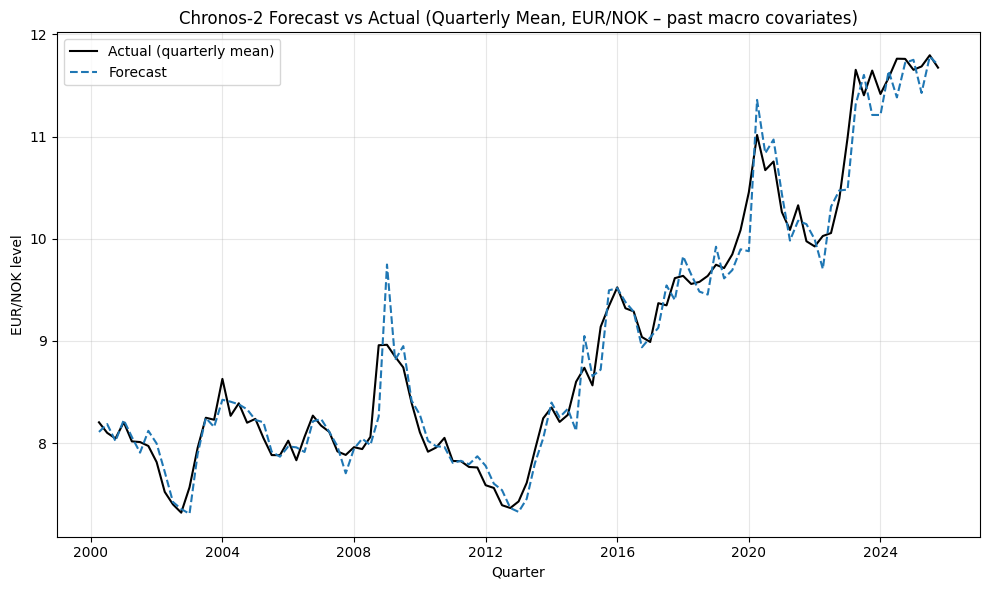

Saved: Chronos2Q_daily_pastcov.png
Saved: Chronos2Q_daily_pastcov.pdf


In [ ]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (quarterly, levels) with daily macro covariates
- Target: EUR_NOK
- Macros: Q, d_pi, dI_t as past-only covariates (no future_df)
- Cut: last business day of previous quarter (based on EUR_NOK B-days)
- Forecast: next calendar quarter daily, aggregated to quarterly mean over business days
- Evaluation: uses EVAL_QUARTERLY with cut_level RW benchmark (driftless)
"""

from __future__ import annotations
import io, time
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable

import numpy as np
import pandas as pd
import requests, certifi

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    q_freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 128
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2Q_daily_pastcov.png"
    fig_pdf: str = "Chronos2Q_daily_pastcov.pdf"

CFG = Config()

TARGET_SERIES = "EUR_NOK"
MACRO_COLS = ["Q", "d_pi", "dI_t"]


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading: daily EUR_NOK (B + D) + macro covariates
# -----------------------------
def load_series(url: str) -> Tuple[pd.Series, pd.DataFrame]:
    """
    Returns:
      S_b  : EUR_NOK on business days (B) with ffill
      DF_d : daily (D) DataFrame with columns [EUR_NOK, Q, d_pi, dI_t], ffilled
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", TARGET_SERIES, *MACRO_COLS}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[["Date", TARGET_SERIES] + MACRO_COLS]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", TARGET_SERIES])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for col in [TARGET_SERIES] + MACRO_COLS:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    df = df.dropna(subset=[TARGET_SERIES])
    if df.empty:
        raise ValueError("Dataset is empty after cleaning.")

    # Business-day target
    S_b = df[TARGET_SERIES].asfreq("B").ffill().astype(float)
    S_b.name = TARGET_SERIES

    # Calendar-day dataframe
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF_d = df.reindex(full_idx).ffill()
    DF_d.index.name = "DATE"

    return S_b, DF_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Chronos-2 model builder (univariate + past-only macro covariates)
# -----------------------------
def build_model_chronos2(
    max_context: int,
) -> Callable[[pd.DataFrame, int], np.ndarray]:
    """
    Returns:
      forecast_fn(hist_df, H) -> np.ndarray length H (daily point forecasts)
    hist_df columns: [EUR_NOK, Q, d_pi, dI_t]
    """
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install a CUDA build of PyTorch and a recent NVIDIA driver.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> np.ndarray:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            y = df["0.5"].to_numpy()
        elif "predictions" in df.columns:
            y = df["predictions"].to_numpy()
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            y = df["forecast"].to_numpy()
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    y = df[cand].to_numpy()
                    break
            else:
                raise RuntimeError(f"Chronos2 predict_df: unsupported schema. Columns={list(df.columns)}.")
        return np.asarray(y, dtype=float)

    def _forecast(hist_df: pd.DataFrame, H: int) -> np.ndarray:
        ctx = hist_df.tail(max_context).copy()

        df_ctx = ctx.reset_index().rename(columns={"DATE": "timestamp", TARGET_SERIES: "target"})
        df_ctx["item_id"] = TARGET_SERIES
        df_ctx = df_ctx[["item_id", "timestamp", "target"] + MACRO_COLS]

        with torch.inference_mode():
            pred = pipeline.predict_df(
                df_ctx,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
            )

        med = _extract_median(pred)
        return med[:H]

    return _forecast


# -----------------------------
# Quarterly walk-forward -> period_df for EVAL_QUARTERLY
# -----------------------------
def walk_forward_chronos2_quarterly_pastcov(
    S_b: pd.Series,
    DF_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], np.ndarray],
) -> pd.DataFrame:
    """
    Returns period_df with PeriodIndex(freq='Q-DEC') and columns:
      y_true, y_pred, cut_level
    """
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_df = DF_d.loc[:cut]
        if hist_df.shape[0] < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue

        y_true = float(S_b.loc[idx_q_b].mean())
        cut_level = float(S_b.loc[cut])  # <- RW benchmark ved cut (driftless)

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        pf = forecast_fn(hist_df, H)
        if pf.shape[0] < H:
            dropped[str(q)] = f"horizon_short({pf.shape[0]})"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx, name="point")

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {
            "quarter": q,
            "y_true": y_true,
            "y_pred": y_pred,
            "cut_level": cut_level,
        }

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("quarter").sort_index()
        if isinstance(period_df.index, pd.PeriodIndex):
            period_df.index = period_df.index.asfreq("Q-DEC")
        else:
            period_df.index = pd.PeriodIndex(period_df.index, freq="Q-DEC")

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if (period_df.empty or q not in period_df.index)]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return period_df


# -----------------------------
# Main (uses EVAL_QUARTERLY)
# -----------------------------
def main():
    # 1) Load data
    S_b, DF_d = load_series(CFG.url)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {DF_d.index.min().date()} → {DF_d.index.max().date()} | n={len(DF_d)}")
        print(f"Columns (DF_d): {list(DF_d.columns)}")

    # 2) Build model
    forecast_fn = build_model_chronos2(max_context=CFG.max_context)

    # 3) Walk-forward -> period_df
    period_df = walk_forward_chronos2_quarterly_pastcov(S_b, DF_d, forecast_fn)

    # 4) Evaluation + DM vs RW (cut-level)
    core, res = EVAL_QUARTERLY["evaluate_period_df"](
        period_df,
        loss="mse",
        h=1,
        label="Chronos-2 (past macro covariates)",
        print_output=True,
    )

    # 5) Plot
    EVAL_QUARTERLY["plot_period_simple"](
        period_df,
        title="Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK – past macro covariates)",
        png_path=CFG.fig_png,
        pdf_path=CFG.fig_pdf,
        y_label="EUR/NOK level",
        show=True,
    )

if __name__ == "__main__":
    main()


## EN-EX

### M

/usr/local/lib/python3.12/dist-packages/torch/utils/_contextlib.py:120: FutureWarning: The `predict_batches_jointly` argument is deprecated and will be removed in a future version. Please use `cross_learning=True` to enable the cross-learning mode.
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/_contextlib.py:120: FutureWarning: The `predict_batches_jointly` argument is deprecated and will be removed in a future version. Please use `cross_learning=True` to enable the cross-learning mode.
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/_contextlib.py:120: FutureWarning: The `predict_batches_jointly` argument is deprecated and will be removed in a future version. Please use `cross_learning=True` to enable the cross-learning mode.
  return func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/_contextlib.py:120: FutureWarning: The `predict_batches_jointly` argument is deprecated and will be removed 


Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Chronos-2 (past covariates; no cross-learning) (monthly mean) ===
Observations: 308
RMSE (level): 0.142222
MAE  (level): 0.096292
Directional accuracy: 210/307 (68.4%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: 1.0712
p-value     : 0.2841


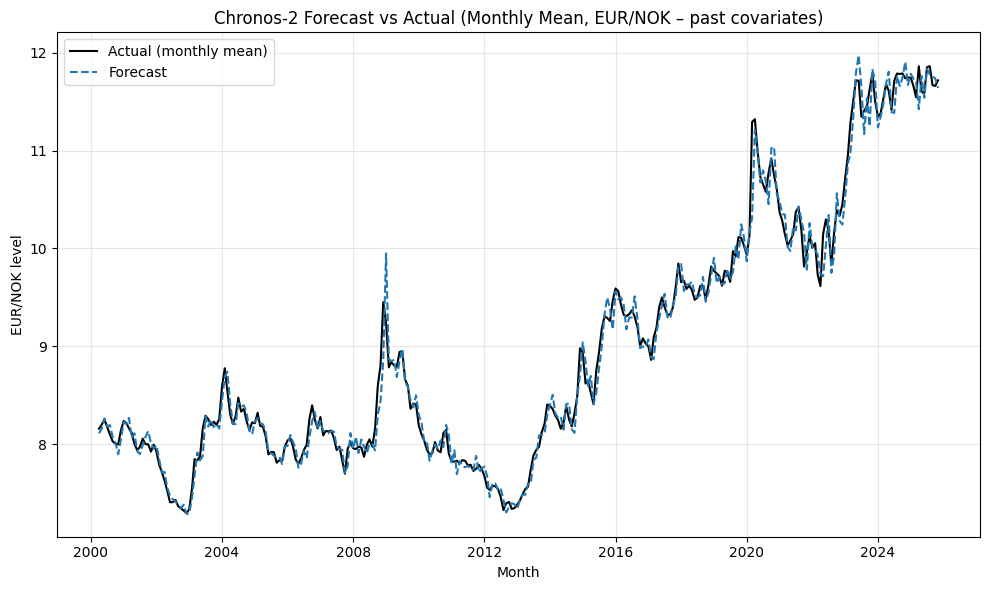

Saved: Chronos2M_daily_pastcov.png
Saved: Chronos2M_daily_pastcov.pdf


In [ ]:
# Chronos_Fx-Monthly_ExogMacro (helpers: data_loader + EVAL_MONTHLY)

from __future__ import annotations
import io
from dataclasses import dataclass
from typing import Dict, Callable, List, Optional, Tuple

import numpy as np
import pandas as pd

import torch
from chronos import BaseChronosPipeline

# --- assumes you already executed:
# - DATA_CFG (with url/retries/timeout)
# - download_csv_text(...)
# - load_fx_series_daily_and_business(...)
# - last_trading_day(...)
# - EVAL_MONTHLY

TARGET_SERIES = "EUR_NOK"
EXOG_COLS = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]
MACRO_COLS = ["Q", "d_pi", "dI_t"]
ALL_COV_COLS = EXOG_COLS + MACRO_COLS

@dataclass
class CFG_M:
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_pastcov.png"
    fig_pdf: str = "Chronos2M_daily_pastcov.pdf"

CFG = CFG_M()

def load_daily_covariates(url: str, cov_cols: List[str]) -> pd.DataFrame:
    """
    Loads covariates as calendar-day (D) ffilled DF, indexed by DATE.
    Reads the same CSV as the helper loader; keep this minimal and consistent.
    """
    text = download_csv_text(url, DATA_CFG.retries, DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required = {"Date", *cov_cols}
    missing = required - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[["Date"] + cov_cols]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for c in cov_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF = df.reindex(full_idx).ffill()
    DF.index.name = "DATE"
    return DF

def make_pastcov_context(hist_target_d: pd.Series, hist_cov_d: pd.DataFrame) -> pd.DataFrame:
    """
    Single item_id context_df:
      item_id, timestamp, target, <covariates>
    """
    hist_cov_d = hist_cov_d.loc[hist_target_d.index.min():hist_target_d.index.max()]
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()

    ctx = pd.DataFrame({
        "timestamp": hist_target_d.index,
        "item_id": TARGET_SERIES,
        "target": hist_target_d.values.astype(float),
    })
    for c in ALL_COV_COLS:
        ctx[c] = hist_cov_d[c].values.astype(float)
    return ctx.sort_values("timestamp")

def build_model_chronos2_pastcov_no_crosslearning(max_context: int) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(max_context).copy()
        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,  # no cross-learning
            )
        return _extract_median(pred)

    return _forecast

def walk_forward_monthly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(),  freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        # history is daily target up to cut (calendar days)
        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue

        y_true = float(S_b.loc[idx_m_b].mean())
        cut_level = float(S_b.loc[cut])  # RW at cut

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        context_df = make_pastcov_context(hist_target_d, COV_d.loc[:cut])
        df_pred = forecast_fn(context_df, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")

        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")
        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {"month": m, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("month").sort_index()
        period_df.index = period_df.index.asfreq("M") if isinstance(period_df.index, pd.PeriodIndex) else pd.PeriodIndex(period_df.index, freq="M")

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if (period_df.empty or m not in period_df.index)]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return period_df

def main():
    # target via helper loader
    S_b, S_d = load_fx_series_daily_and_business(
        url=DATA_CFG.url, series=TARGET_SERIES, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout
    )
    # covariates via minimal helper (daily D ffill)
    COV_d = load_daily_covariates(DATA_CFG.url, ALL_COV_COLS)

    forecast_fn = build_model_chronos2_pastcov_no_crosslearning(max_context=CFG.max_context)

    period_df = walk_forward_monthly_perioddf(S_b, S_d, COV_d, forecast_fn)

    core, res = EVAL_MONTHLY["evaluate_period_df"](
        period_df, loss="mse", h=1, label="Chronos-2 (past covariates; no cross-learning)", print_output=True
    )

    EVAL_MONTHLY["plot_period_simple"](
        period_df,
        title="Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – past covariates)",
        png_path=CFG.fig_png,
        pdf_path=CFG.fig_pdf,
        y_label="EUR/NOK level",
        show=True,
    )

if __name__ == "__main__":
    main()


### Q


Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Chronos-2 (past-only covariates) (quarterly mean) ===
Observations: 103
RMSE (level): 0.203427
MAE  (level): 0.143492
Directional accuracy: 78/102 (76.5%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: -1.2958
p-value     : 0.1950


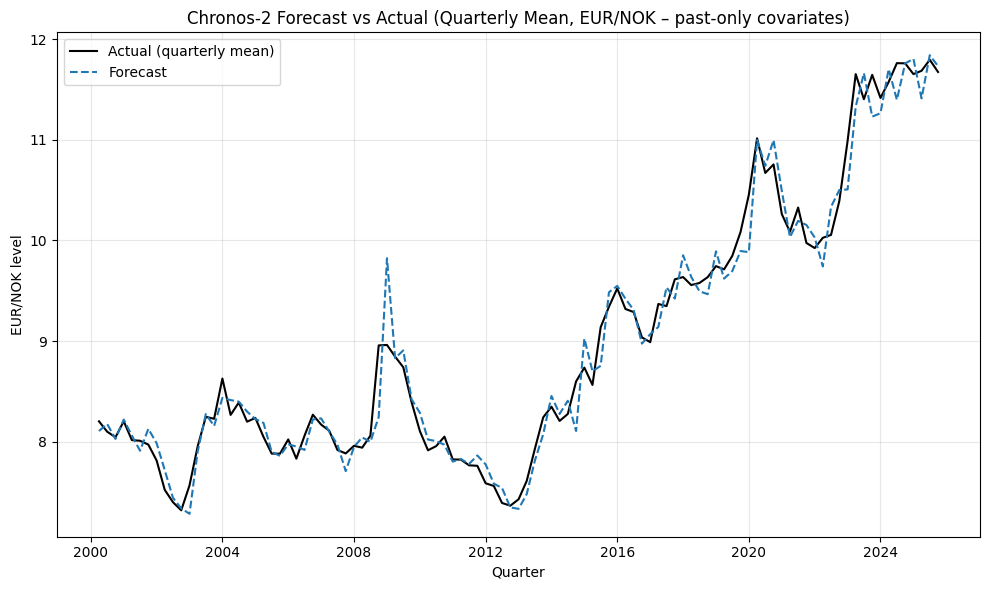

Saved: Chronos2Q_daily_pastcov.png
Saved: Chronos2Q_daily_pastcov.pdf


In [ ]:
# Chronos_Fx-Quarterly_PastCov (helpers: data_loader + EVAL_QUARTERLY)

from __future__ import annotations
import io
from dataclasses import dataclass
from typing import Dict, Callable, List, Optional, Tuple

import numpy as np
import pandas as pd

import torch
from chronos import BaseChronosPipeline

# --- assumes you already executed:
# - DATA_CFG
# - download_csv_text(...)
# - load_fx_series_daily_and_business(...)
# - last_trading_day(...)
# - EVAL_QUARTERLY

TARGET_SERIES = "EUR_NOK"
COVARIATE_COLS = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy", "Q", "d_pi", "dI_t"]

@dataclass
class CFG_Q:
    q_freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 128
    verbose: bool = True
    fig_png: str = "Chronos2Q_daily_pastcov.png"
    fig_pdf: str = "Chronos2Q_daily_pastcov.pdf"

CFG = CFG_Q()

def load_daily_covariates(url: str, cov_cols: List[str]) -> pd.DataFrame:
    text = download_csv_text(url, DATA_CFG.retries, DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required = {"Date", *cov_cols}
    missing = required - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[["Date"] + cov_cols]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in cov_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF = df.reindex(full_idx).ffill()
    DF.index.name = "DATE"
    return DF

def make_context_with_past_cov(hist_target_d: pd.Series, hist_cov_d: pd.DataFrame) -> pd.DataFrame:
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()

    ctx = pd.DataFrame({
        "timestamp": hist_target_d.index,
        "item_id": TARGET_SERIES,
        "target": hist_target_d.values.astype(float),
    })
    for c in COVARIATE_COLS:
        ctx[c] = hist_cov_d[c].values.astype(float)
    return ctx.sort_values("timestamp")

def build_model_chronos2_pastcov(max_context: int) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values(["item_id", "timestamp"]) if "item_id" in df.columns else df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Chronos2 predict_df: unsupported schema. Columns={list(df.columns)}.")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(max_context).copy()
        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
            )
        return _extract_median(pred)

    return _forecast

def walk_forward_quarterly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
) -> pd.DataFrame:

    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(),  freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue

        y_true = float(S_b.loc[idx_q_b].mean())
        cut_level = float(S_b.loc[cut])

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_context_with_past_cov(hist_target_d, COV_d.loc[:cut])
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())

        rows[str(q)] = {"quarter": q, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("quarter").sort_index()
        period_df.index = period_df.index.asfreq("Q-DEC") if isinstance(period_df.index, pd.PeriodIndex) else pd.PeriodIndex(period_df.index, freq="Q-DEC")

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if (period_df.empty or q not in period_df.index)]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return period_df

def main():
    S_b, S_d = load_fx_series_daily_and_business(
        url=DATA_CFG.url, series=TARGET_SERIES, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout
    )
    COV_d = load_daily_covariates(DATA_CFG.url, COVARIATE_COLS)

    forecast_fn = build_model_chronos2_pastcov(max_context=CFG.max_context)

    period_df = walk_forward_quarterly_perioddf(S_b, S_d, COV_d, forecast_fn)

    core, res = EVAL_QUARTERLY["evaluate_period_df"](
        period_df, loss="mse", h=1, label="Chronos-2 (past-only covariates)", print_output=True
    )

    EVAL_QUARTERLY["plot_period_simple"](
        period_df,
        title="Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK – past-only covariates)",
        png_path=CFG.fig_png,
        pdf_path=CFG.fig_pdf,
        y_label="EUR/NOK level",
        show=True,
    )

if __name__ == "__main__":
    main()


## Variable Importance

### M


Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Chronos-2 (past covariates; no cross-learning) (monthly mean) ===
Observations: 308
RMSE (level): 0.142222
MAE  (level): 0.096292
Directional accuracy: 210/307 (68.4%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: 1.0712
p-value     : 0.2841

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

Dropped mont

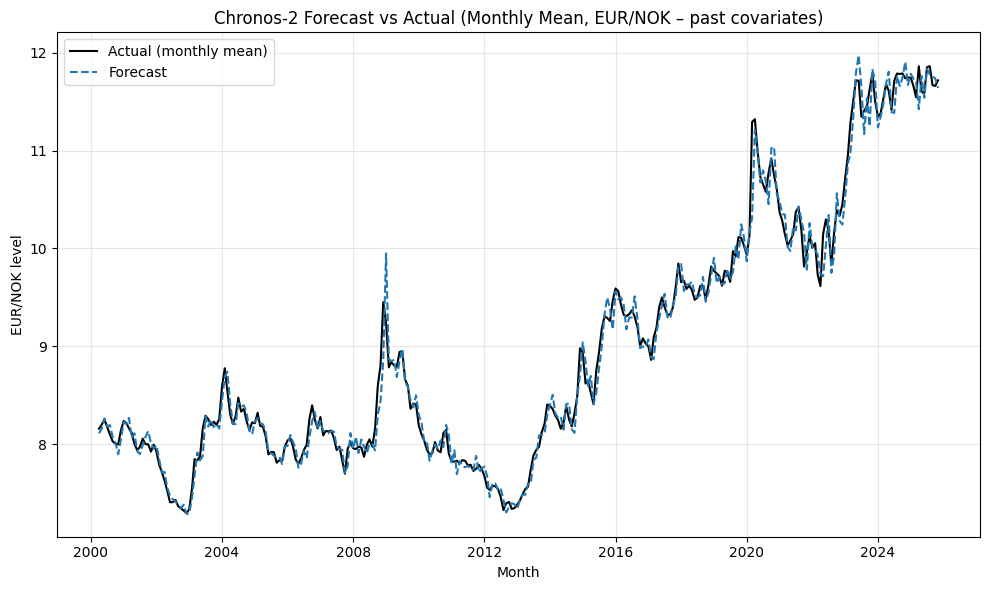

Saved: Chronos2M_daily_pastcov.png
Saved: Chronos2M_daily_pastcov.pdf


In [ ]:
# Chronos_Fx-Monthly_ExogMacro_RobustImportance
# Robust "importance" via:
#  (1) lock eval months to baseline (overlap only)
#  (2) rank on delta mean(d_t) and delta DM-stat (NOT p-values)
#  (3) block bootstrap CIs over months

from __future__ import annotations
import io
from dataclasses import dataclass
from typing import Dict, Callable, List, Tuple, Optional

import numpy as np
import pandas as pd

import torch
from chronos import BaseChronosPipeline
import warnings

warnings.filterwarnings(
    "ignore",
    message=r".*predict_batches_jointly.*deprecated.*",
    category=FutureWarning,
)

TARGET_SERIES = "EUR_NOK"

EXOG_COLS = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]
MACRO_COLS = ["Q", "d_pi", "dI_t"]
ALL_COV_COLS = EXOG_COLS + MACRO_COLS

@dataclass
class CFG_M:
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    verbose: bool = True
    fig_png: str = "Chronos2M_daily_pastcov.png"
    fig_pdf: str = "Chronos2M_daily_pastcov.pdf"
    # robustness knobs
    loss: str = "mse"                 # "mse" or "mae"
    h_dm: int = 1                     # DM horizon for period-means
    block_len: int = 12               # months per bootstrap block
    n_boot: int = 500                 # bootstrap replications
    random_seed: int = 123

CFG = CFG_M()

# -----------------------------
# Covariates loader (D, ffill)
# -----------------------------
def load_daily_covariates(url: str, cov_cols: List[str]) -> pd.DataFrame:
    text = download_csv_text(url, DATA_CFG.retries, DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required = {"Date", *cov_cols}
    missing = required - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[["Date"] + cov_cols]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in cov_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF = df.reindex(full_idx).ffill()
    DF.index.name = "DATE"
    return DF

# -----------------------------
# Context builder (single item, past covariates)
# -----------------------------
def make_pastcov_context(hist_target_d: pd.Series, hist_cov_d: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()

    ctx = pd.DataFrame(
        {
            "timestamp": hist_target_d.index,
            "item_id": TARGET_SERIES,
            "target": hist_target_d.values.astype(float),
        }
    )
    for c in cov_cols:
        ctx[c] = hist_cov_d[c].values.astype(float)

    return ctx.sort_values("timestamp")

# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
# -----------------------------
def build_model_chronos2_pastcov_no_crosslearning(max_context: int) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(max_context).copy()
        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,  # disable cross-learning
            )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward -> period_df (M) with cut_level for EVAL_MONTHLY
# -----------------------------
def walk_forward_monthly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue

        y_true = float(S_b.loc[idx_m_b].mean())
        cut_level = float(S_b.loc[cut])

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_pastcov_context(hist_target_d, COV_d.loc[:cut], cov_cols)
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(m)] = {"month": m, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("month").sort_index()
        if not isinstance(period_df.index, pd.PeriodIndex):
            period_df.index = pd.PeriodIndex(period_df.index, freq="M")

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if (period_df.empty or m not in period_df.index)]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return period_df

# -----------------------------
# Robust scoring utilities
# -----------------------------
def _loss_vec(err: pd.Series, loss: str) -> pd.Series:
    loss = loss.lower()
    if loss == "mae":
        return err.abs()
    if loss == "mse":
        return err.pow(2)
    raise ValueError("loss must be 'mse' or 'mae'")

def compute_dm_components(period_df: pd.DataFrame, loss: str) -> pd.Series:
    """
    Returns d_t series = L(e_model) - L(e_rw), where RW uses cut_level (driftless).
    """
    df = period_df.copy()
    df = df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    if df.empty:
        return pd.Series(dtype=float)

    e_m = df["y_true"] - df["y_pred"]
    e_r = df["y_true"] - df["cut_level"].astype(float)
    d = _loss_vec(e_m, loss) - _loss_vec(e_r, loss)
    d.index = df.index
    return d

def dm_stat_from_d(d: pd.Series, h: int = 1) -> float:
    """
    Same idea as your DM-test, but computed from d_t directly.
    For monthly/quarterly period-means: h=1 is standard.
    """
    d = d.dropna()
    N = int(len(d))
    if N < 5:
        return float("nan")

    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan")

    return float(d_mean / np.sqrt(var_bar))

def block_bootstrap_ci(
    d: pd.Series,
    block_len: int,
    n_boot: int,
    seed: int,
) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    """
    Block bootstrap CIs for:
      - mean(d)
      - DM-stat (computed from bootstrapped d)
    """
    rng = np.random.default_rng(seed)
    d = d.dropna().astype(float)
    T = len(d)
    if T < 10:
        return (float("nan"), float("nan")), (float("nan"), float("nan"))

    x = d.to_numpy()
    # start indices for blocks
    max_start = max(1, T - block_len + 1)
    starts = np.arange(max_start)

    means = np.empty(n_boot, dtype=float)
    dmstats = np.empty(n_boot, dtype=float)

    for b in range(n_boot):
        sample = []
        while len(sample) < T:
            s = int(rng.choice(starts))
            sample.extend(x[s : s + block_len])
        sample = np.asarray(sample[:T], dtype=float)
        means[b] = float(np.mean(sample))
        dmstats[b] = dm_stat_from_d(pd.Series(sample), h=CFG.h_dm)

    ci_mean = (float(np.quantile(means, 0.025)), float(np.quantile(means, 0.975)))
    ci_dm   = (float(np.quantile(dmstats, 0.025)), float(np.quantile(dmstats, 0.975)))
    return ci_mean, ci_dm

# -----------------------------
# Robust leave-one-out (multiple runs, overlap locked)
# -----------------------------
def robust_leave_one_out(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    # Baseline
    base_df = walk_forward_monthly_perioddf(S_b, S_d, COV_d, forecast_fn, cov_cols)
    base_df = base_df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    base_months = base_df.index

    d_base = compute_dm_components(base_df, CFG.loss).reindex(base_months).dropna()
    base_mean = float(d_base.mean()) if len(d_base) else float("nan")
    base_dm   = dm_stat_from_d(d_base, h=CFG.h_dm)

    (ci_mean_base, ci_dm_base) = block_bootstrap_ci(
        d_base, block_len=CFG.block_len, n_boot=CFG.n_boot, seed=CFG.random_seed
    )

    rows = []
    rows.append({
        "covariate": "__BASELINE__",
        "n_months": int(len(d_base)),
        "mean_d": base_mean,
        "mean_d_ci_lo": ci_mean_base[0],
        "mean_d_ci_hi": ci_mean_base[1],
        "dm_stat": base_dm,
        "dm_ci_lo": ci_dm_base[0],
        "dm_ci_hi": ci_dm_base[1],
        "delta_mean_d_vs_base": 0.0,
        "delta_dm_vs_base": 0.0,
    })

    # LOO, but ALWAYS evaluated on baseline months (overlap locked)
    for c in cov_cols:
        reduced = [x for x in cov_cols if x != c]
        df_i = walk_forward_monthly_perioddf(S_b, S_d, COV_d, forecast_fn, reduced)

        # lock to baseline months
        df_i = df_i.reindex(base_months)
        df_i = df_i.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()

        d_i = compute_dm_components(df_i, CFG.loss).reindex(base_months).dropna()

        mean_i = float(d_i.mean()) if len(d_i) else float("nan")
        dm_i = dm_stat_from_d(d_i, h=CFG.h_dm)
        (ci_mean_i, ci_dm_i) = block_bootstrap_ci(
            d_i, block_len=CFG.block_len, n_boot=CFG.n_boot, seed=CFG.random_seed + 1000 + hash(c) % 100000
        )

        rows.append({
            "covariate": c,
            "n_months": int(len(d_i)),
            "mean_d": mean_i,
            "mean_d_ci_lo": ci_mean_i[0],
            "mean_d_ci_hi": ci_mean_i[1],
            "dm_stat": dm_i,
            "dm_ci_lo": ci_dm_i[0],
            "dm_ci_hi": ci_dm_i[1],
            # positive delta => worse (less negative) if baseline is better-than-RW
            "delta_mean_d_vs_base": (mean_i - base_mean) if np.isfinite(mean_i) and np.isfinite(base_mean) else np.nan,
            "delta_dm_vs_base": (dm_i - base_dm) if np.isfinite(dm_i) and np.isfinite(base_dm) else np.nan,
        })

    out = pd.DataFrame(rows)

    # Rank: biggest deterioration when removed => most "important"
    # For DM: baseline better-than-RW usually DM<0, so removal that increases DM (delta_dm > 0) is worse.
    out = out.sort_values(["covariate"]).reset_index(drop=True)
    return out, base_df

def print_ranked_tables(robust_df: pd.DataFrame) -> None:
    base = robust_df.loc[robust_df["covariate"] == "__BASELINE__"].iloc[0]

    loo = robust_df[robust_df["covariate"] != "__BASELINE__"].copy()
    loo = loo.sort_values("delta_dm_vs_base", ascending=False)

    print("\n=== Robust LOO (locked months): rank by ΔDM-stat (higher = worse when removed) ===")
    print(loo[[
        "covariate","n_months",
        "dm_stat","dm_ci_lo","dm_ci_hi",
        "delta_dm_vs_base",
        "mean_d","mean_d_ci_lo","mean_d_ci_hi",
        "delta_mean_d_vs_base",
    ]].to_string(index=False))

    loo2 = robust_df[robust_df["covariate"] != "__BASELINE__"].copy()
    loo2 = loo2.sort_values("delta_mean_d_vs_base", ascending=False)

    print("\n=== Robust LOO (locked months): rank by Δmean(d) (higher = worse when removed) ===")
    print(loo2[[
        "covariate","n_months",
        "mean_d","mean_d_ci_lo","mean_d_ci_hi",
        "delta_mean_d_vs_base",
        "dm_stat","dm_ci_lo","dm_ci_hi",
        "delta_dm_vs_base",
    ]].to_string(index=False))

    print("\n=== Baseline summary ===")
    print(
        f"n_months={int(base['n_months'])} | "
        f"mean(d)={base['mean_d']:.6g} [{base['mean_d_ci_lo']:.6g},{base['mean_d_ci_hi']:.6g}] | "
        f"DM={base['dm_stat']:.4f} [{base['dm_ci_lo']:.4f},{base['dm_ci_hi']:.4f}]"
    )

# -----------------------------
# Main
# -----------------------------
def main():
    # target via helper loader
    S_b, S_d = load_fx_series_daily_and_business(
        url=DATA_CFG.url, series=TARGET_SERIES, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout
    )

    # covariates daily D ffill
    COV_d = load_daily_covariates(DATA_CFG.url, ALL_COV_COLS)

    forecast_fn = build_model_chronos2_pastcov_no_crosslearning(max_context=CFG.max_context)

    # Baseline period_df (for your existing eval cell)
    period_df_base = walk_forward_monthly_perioddf(S_b, S_d, COV_d, forecast_fn, ALL_COV_COLS)

    core, res = EVAL_MONTHLY["evaluate_period_df"](
        period_df_base,
        loss=CFG.loss,
        h=CFG.h_dm,
        label="Chronos-2 (past covariates; no cross-learning)",
        print_output=True,
    )

    # Robust importance (many rounds via block bootstrap)
    robust_df, base_df_locked = robust_leave_one_out(S_b, S_d, COV_d, forecast_fn, ALL_COV_COLS)
    print_ranked_tables(robust_df)

    # Plot baseline
    EVAL_MONTHLY["plot_period_simple"](
        period_df_base,
        title="Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK – past covariates)",
        png_path=CFG.fig_png,
        pdf_path=CFG.fig_pdf,
        y_label="EUR/NOK level",
        show=True,
    )

if __name__ == "__main__":
    main()



Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Chronos-2 (selected covariates only: dI_t, VIX, OSEBX, StoxEurope) (monthly mean) ===
Observations: 308
RMSE (level): 0.141370
MAE  (level): 0.095178
Directional accuracy: 215/307 (70.0%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: 0.7714
p-value     : 0.4405


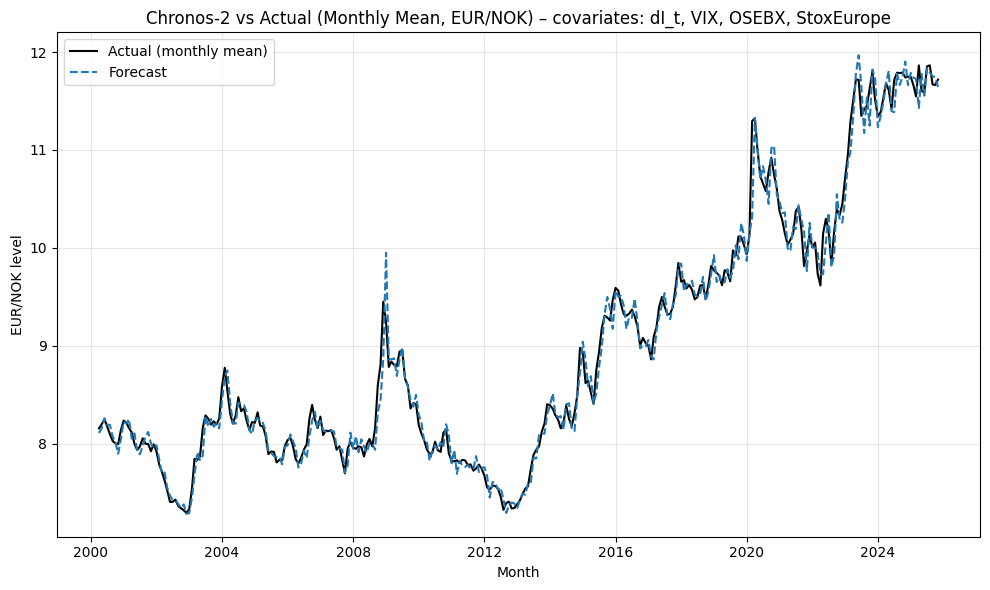

Saved: Chronos2M_selected_cov.png
Saved: Chronos2M_selected_cov.pdf


In [ ]:
# ============================================================
# Chronos_Fx-Monthly_ExogMacro_RobustLOO (ONLY selected covariates)
# Uses: helper-style DataLoader + EVAL_MONTHLY (included below)
# Selected covariates: dI_t, VIX, OSEBX, StoxEurope
# ============================================================

from __future__ import annotations

import io, time, math, warnings
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline

# -----------------------------
# Silence the Chronos/Torch deprecation warning spam
# -----------------------------
warnings.filterwarnings(
    "ignore",
    message=r".*predict_batches_jointly.*deprecated.*",
    category=FutureWarning,
)
warnings.filterwarnings("ignore", category=FutureWarning)  # keep if you want fully quiet


# ============================================================
# 1) DATA LOADER helper cell (daily target: business + calendar)
# ============================================================
@dataclass
class DataConfig:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    retries: int = 3
    timeout: int = 60

DATA_CFG = DataConfig()


def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


def load_fx_series_daily_and_business(
    url: str,
    series: str = "EUR_NOK",
    retries: int = 3,
    timeout: int = 60,
) -> Tuple[pd.Series, pd.Series]:
    """
    Load (Date, series) from CSV.
    Returns:
      S_b: business-day (B) ffilled
      S_d: calendar-day (D) ffilled
    """
    text = download_csv_text(url, retries, timeout)
    raw = pd.read_csv(io.StringIO(text))

    required = {"Date", series}
    missing = required - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[["Date", series]]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", series])
        .sort_values("DATE")
        .set_index("DATE")
    )

    df[series] = pd.to_numeric(df[series], errors="coerce")
    df = df.dropna(subset=[series])
    if df.empty:
        raise ValueError("Dataset is empty after cleaning.")

    S_b = df[series].asfreq("B").ffill().astype(float)
    S_b.name = series

    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    S_d = df[series].reindex(full_idx).ffill().astype(float)
    S_d.index.name = "DATE"
    S_d.name = series

    return S_b, S_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


def load_daily_covariates(url: str, cov_cols: List[str]) -> pd.DataFrame:
    """Load selected covariates as daily (D) ffill DF."""
    text = download_csv_text(url, DATA_CFG.retries, DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required = {"Date", *cov_cols}
    missing = required - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[["Date"] + cov_cols]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )

    for c in cov_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF = df.reindex(full_idx).ffill()
    DF.index.name = "DATE"
    return DF


# ============================================================
# 2) EVAL helper cell (MONTHLY)
# ============================================================
EVAL_MONTHLY = {}

def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def dm_test(y_true: pd.Series, y_model: pd.Series, y_rw: pd.Series, h: int = 1, loss: str = "mse") -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = (np.abs(e_m) - np.abs(e_r)) if loss.lower() == "mae" else ((e_m**2) - (e_r**2))

    N = int(len(d))
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return float(dm_stat), float(p_val)

def evaluate_period_df_monthly(
    period_df: pd.DataFrame,
    *,
    loss: str = "mse",
    h: int = 1,
    label: str = "Model",
    print_output: bool = True,
) -> Tuple[pd.DataFrame, Dict]:
    required = {"y_true", "y_pred", "cut_level"}
    missing = required - set(period_df.columns)
    if missing:
        raise ValueError(f"Mangler kolonner: {missing}. Legg til cut_level=float(S_b.loc[cut]).")

    core = period_df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    core["err"] = core["y_true"] - core["y_pred"]

    n_obs = int(len(core))
    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else float("nan")
    mae  = float(np.mean(np.abs(core["err"]))) if n_obs else float("nan")

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    total = int(mask.sum())
    hits = 0
    dir_acc = float("nan")
    if total:
        dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
        dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
        hits = int((dir_true.values == dir_pred.values).sum())
        dir_acc = float(hits / total)

    core["rw_pred"] = core["cut_level"].astype(float)

    dm_stat, p_val = dm_test(core["y_true"], core["y_pred"], core["rw_pred"], h=h, loss=loss)

    better_than_rw = bool(np.isfinite(dm_stat) and dm_stat < 0)
    sig = ""
    if better_than_rw and np.isfinite(p_val):
        if p_val < 0.01: sig = "***"
        elif p_val < 0.05: sig = "**"
        elif p_val < 0.10: sig = "*"

    res = dict(
        label=label,
        observations=n_obs,
        rmse=rmse,
        mae=mae,
        dir_hits=int(hits),
        dir_total=int(total),
        dir_acc=dir_acc,
        dm_stat=float(dm_stat) if np.isfinite(dm_stat) else float("nan"),
        dm_pvalue=float(p_val) if np.isfinite(p_val) else float("nan"),
        better_than_rw=better_than_rw,
        sig=sig,
    )

    if print_output:
        print(f"\n=== {label} (monthly mean) ===")
        print(f"Observations: {n_obs}")
        print(f"RMSE (level): {rmse:.6f}")
        print(f"MAE  (level): {mae:.6f}")
        if total:
            print(f"Directional accuracy: {hits}/{total} ({dir_acc*100:.1f}%)")
        print("\n=== Diebold–Mariano vs Random Walk (cut-level RW) ===")
        print(f"Loss: {loss.upper()} | horizon h={h}")
        print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
        print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")
        if sig:
            print(f"Significance: {sig} (model better than RW)")

    return core, res

def plot_period_simple_monthly(
    period_df: pd.DataFrame,
    *,
    title: str,
    png_path: str,
    pdf_path: Optional[str] = None,
    y_label: str = "Level",
    show: bool = True,
) -> None:
    df = period_df.dropna(subset=["y_true", "y_pred"]).copy()
    if df.empty:
        print("Nothing to plot.")
        return

    x = df.index.to_timestamp() if isinstance(df.index, pd.PeriodIndex) else df.index

    plt.figure(figsize=(10, 6))
    plt.plot(x, df["y_true"], color="black", label="Actual (monthly mean)")
    plt.plot(x, df["y_pred"], color="tab:blue", linestyle="--", label="Forecast")
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    if pdf_path:
        plt.savefig(pdf_path, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()

    print(f"Saved: {png_path}")
    if pdf_path:
        print(f"Saved: {pdf_path}")

EVAL_MONTHLY["evaluate_period_df"] = evaluate_period_df_monthly
EVAL_MONTHLY["plot_period_simple"] = plot_period_simple_monthly


# ============================================================
# 3) Model + Walk-forward (MONTHLY) using ONLY selected covariates
# ============================================================
TARGET_SERIES = "EUR_NOK"

# ONLY these covariates:
COV_COLS = ["dI_t", "VIX", "OSEBX", "StoxEurope"]

@dataclass
class CFG_M:
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    verbose: bool = True
    fig_png: str = "Chronos2M_selected_cov.png"
    fig_pdf: str = "Chronos2M_selected_cov.pdf"

CFG = CFG_M()


def make_pastcov_context(hist_target_d: pd.Series, hist_cov_d: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()
    ctx = pd.DataFrame(
        {
            "timestamp": hist_target_d.index,
            "item_id": TARGET_SERIES,
            "target": hist_target_d.values.astype(float),
        }
    )
    for c in cov_cols:
        ctx[c] = hist_cov_d[c].values.astype(float)
    return ctx.sort_values("timestamp")


def build_model_chronos2_pastcov_no_crosslearning(max_context: int) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(max_context).copy()
        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,  # legacy flag; warning suppressed above
            )
        return _extract_median(pred)

    return _forecast


def walk_forward_monthly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue

        y_true = float(S_b.loc[idx_m_b].mean())
        cut_level = float(S_b.loc[cut])

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_pastcov_context(hist_target_d, COV_d.loc[:cut], cov_cols)
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(m)] = {"month": m, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("month").sort_index()
        if not isinstance(period_df.index, pd.PeriodIndex):
            period_df.index = pd.PeriodIndex(period_df.index, freq="M")

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if (period_df.empty or m not in period_df.index)]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return period_df


# ============================================================
# 4) Main
# ============================================================
def main():
    # target series (B and D)
    S_b, S_d = load_fx_series_daily_and_business(
        url=DATA_CFG.url, series=TARGET_SERIES, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout
    )

    # selected covariates only (D, ffill)
    COV_d = load_daily_covariates(DATA_CFG.url, COV_COLS)

    # model
    forecast_fn = build_model_chronos2_pastcov_no_crosslearning(max_context=CFG.max_context)

    # walk-forward
    period_df = walk_forward_monthly_perioddf(S_b, S_d, COV_d, forecast_fn, COV_COLS)

    # eval + plot (helper cell)
    core, res = EVAL_MONTHLY["evaluate_period_df"](
        period_df,
        loss="mse",
        h=1,
        label=f"Chronos-2 (selected covariates only: {', '.join(COV_COLS)})",
        print_output=True,
    )

    EVAL_MONTHLY["plot_period_simple"](
        period_df,
        title=f"Chronos-2 vs Actual (Monthly Mean, EUR/NOK) – covariates: {', '.join(COV_COLS)}",
        png_path=CFG.fig_png,
        pdf_path=CFG.fig_pdf,
        y_label="EUR/NOK level",
        show=True,
    )

if __name__ == "__main__":
    main()


###Q


Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

=== Chronos-2 (past covariates; no cross-learning) (quarterly mean) ===
Observations: 103
RMSE (level): 0.203427
MAE  (level): 0.143492
Directional accuracy: 78/102 (76.5%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: -1.2958
p-value     : 0.1950

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter


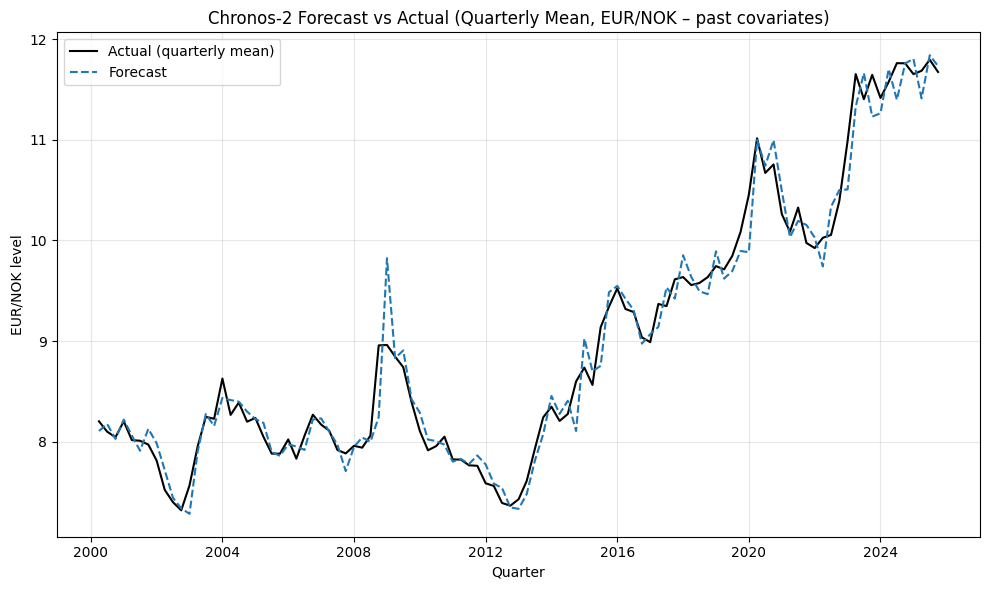

Saved: Chronos2Q_daily_pastcov.png
Saved: Chronos2Q_daily_pastcov.pdf


In [ ]:
# Chronos_Fx-Quarterly_ExogMacro_RobustImportance
# Robust "importance" via:
#  (1) lock eval quarters to baseline (overlap only)
#  (2) rank on delta mean(d_t) and delta DM-stat (NOT p-values)
#  (3) block bootstrap CIs over quarters

from __future__ import annotations
import io
from dataclasses import dataclass
from typing import Dict, Callable, List, Tuple, Optional

import numpy as np
import pandas as pd

import torch
from chronos import BaseChronosPipeline
import warnings

warnings.filterwarnings(
    "ignore",
    message=r".*predict_batches_jointly.*deprecated.*",
    category=FutureWarning,
)

TARGET_SERIES = "EUR_NOK"

EXOG_COLS = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]
MACRO_COLS = ["Q", "d_pi", "dI_t"]
ALL_COV_COLS = EXOG_COLS + MACRO_COLS

@dataclass
class CFG_Q:
    q_freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 128
    verbose: bool = True
    fig_png: str = "Chronos2Q_daily_pastcov.png"
    fig_pdf: str = "Chronos2Q_daily_pastcov.pdf"
    # robustness knobs
    loss: str = "mse"                 # "mse" or "mae"
    h_dm: int = 1                     # DM horizon for period-means
    block_len: int = 8                # quarters per bootstrap block
    n_boot: int = 500                 # bootstrap replications
    random_seed: int = 123

CFG = CFG_Q()

# -----------------------------
# Covariates loader (D, ffill)
# -----------------------------
def load_daily_covariates(url: str, cov_cols: List[str]) -> pd.DataFrame:
    text = download_csv_text(url, DATA_CFG.retries, DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required = {"Date", *cov_cols}
    missing = required - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[["Date"] + cov_cols]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in cov_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF = df.reindex(full_idx).ffill()
    DF.index.name = "DATE"
    return DF

# -----------------------------
# Context builder (single item, past covariates)
# -----------------------------
def make_pastcov_context(hist_target_d: pd.Series, hist_cov_d: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()

    ctx = pd.DataFrame(
        {
            "timestamp": hist_target_d.index,
            "item_id": TARGET_SERIES,
            "target": hist_target_d.values.astype(float),
        }
    )
    for c in cov_cols:
        ctx[c] = hist_cov_d[c].values.astype(float)

    return ctx.sort_values("timestamp")

# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
# -----------------------------
def build_model_chronos2_pastcov_no_crosslearning(max_context: int) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(max_context).copy()
        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=H,
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                predict_batches_jointly=False,  # disable cross-learning
            )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward -> period_df (Q-DEC) with cut_level for EVAL_QUARTERLY
# -----------------------------
def walk_forward_quarterly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue

        y_true = float(S_b.loc[idx_q_b].mean())
        cut_level = float(S_b.loc[cut])

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_pastcov_context(hist_target_d, COV_d.loc[:cut], cov_cols)
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(q)] = {"quarter": q, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("quarter").sort_index()
        if not isinstance(period_df.index, pd.PeriodIndex):
            period_df.index = pd.PeriodIndex(period_df.index, freq=CFG.q_freq)

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if (period_df.empty or q not in period_df.index)]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return period_df

# -----------------------------
# Robust scoring utilities
# -----------------------------
def _loss_vec(err: pd.Series, loss: str) -> pd.Series:
    loss = loss.lower()
    if loss == "mae":
        return err.abs()
    if loss == "mse":
        return err.pow(2)
    raise ValueError("loss must be 'mse' or 'mae'")

def compute_dm_components(period_df: pd.DataFrame, loss: str) -> pd.Series:
    """
    Returns d_t series = L(e_model) - L(e_rw), where RW uses cut_level (driftless).
    """
    df = period_df.copy()
    df = df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    if df.empty:
        return pd.Series(dtype=float)

    e_m = df["y_true"] - df["y_pred"]
    e_r = df["y_true"] - df["cut_level"].astype(float)
    d = _loss_vec(e_m, loss) - _loss_vec(e_r, loss)
    d.index = df.index
    return d

def dm_stat_from_d(d: pd.Series, h: int = 1) -> float:
    d = d.dropna()
    N = int(len(d))
    if N < 5:
        return float("nan")

    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan")

    return float(d_mean / np.sqrt(var_bar))

def block_bootstrap_ci(
    d: pd.Series,
    block_len: int,
    n_boot: int,
    seed: int,
) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    """
    Block bootstrap CIs for:
      - mean(d)
      - DM-stat (computed from bootstrapped d)
    """
    rng = np.random.default_rng(seed)
    d = d.dropna().astype(float)
    T = len(d)
    if T < 8:
        return (float("nan"), float("nan")), (float("nan"), float("nan"))

    x = d.to_numpy()
    max_start = max(1, T - block_len + 1)
    starts = np.arange(max_start)

    means = np.empty(n_boot, dtype=float)
    dmstats = np.empty(n_boot, dtype=float)

    for b in range(n_boot):
        sample = []
        while len(sample) < T:
            s = int(rng.choice(starts))
            sample.extend(x[s : s + block_len])
        sample = np.asarray(sample[:T], dtype=float)
        means[b] = float(np.mean(sample))
        dmstats[b] = dm_stat_from_d(pd.Series(sample), h=CFG.h_dm)

    ci_mean = (float(np.quantile(means, 0.025)), float(np.quantile(means, 0.975)))
    ci_dm   = (float(np.quantile(dmstats, 0.025)), float(np.quantile(dmstats, 0.975)))
    return ci_mean, ci_dm

# -----------------------------
# Robust leave-one-out (multiple runs, overlap locked)
# -----------------------------
def robust_leave_one_out(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Baseline
    base_df = walk_forward_quarterly_perioddf(S_b, S_d, COV_d, forecast_fn, cov_cols)
    base_df = base_df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    base_quarters = base_df.index

    d_base = compute_dm_components(base_df, CFG.loss).reindex(base_quarters).dropna()
    base_mean = float(d_base.mean()) if len(d_base) else float("nan")
    base_dm   = dm_stat_from_d(d_base, h=CFG.h_dm)

    (ci_mean_base, ci_dm_base) = block_bootstrap_ci(
        d_base, block_len=CFG.block_len, n_boot=CFG.n_boot, seed=CFG.random_seed
    )

    rows = []
    rows.append({
        "covariate": "__BASELINE__",
        "n_quarters": int(len(d_base)),
        "mean_d": base_mean,
        "mean_d_ci_lo": ci_mean_base[0],
        "mean_d_ci_hi": ci_mean_base[1],
        "dm_stat": base_dm,
        "dm_ci_lo": ci_dm_base[0],
        "dm_ci_hi": ci_dm_base[1],
        "delta_mean_d_vs_base": 0.0,
        "delta_dm_vs_base": 0.0,
    })

    # LOO, but ALWAYS evaluated on baseline quarters (overlap locked)
    for c in cov_cols:
        reduced = [x for x in cov_cols if x != c]
        df_i = walk_forward_quarterly_perioddf(S_b, S_d, COV_d, forecast_fn, reduced)

        # lock to baseline quarters
        df_i = df_i.reindex(base_quarters)
        df_i = df_i.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()

        d_i = compute_dm_components(df_i, CFG.loss).reindex(base_quarters).dropna()

        mean_i = float(d_i.mean()) if len(d_i) else float("nan")
        dm_i = dm_stat_from_d(d_i, h=CFG.h_dm)
        (ci_mean_i, ci_dm_i) = block_bootstrap_ci(
            d_i, block_len=CFG.block_len, n_boot=CFG.n_boot, seed=CFG.random_seed + 1000 + hash(c) % 100000
        )

        rows.append({
            "covariate": c,
            "n_quarters": int(len(d_i)),
            "mean_d": mean_i,
            "mean_d_ci_lo": ci_mean_i[0],
            "mean_d_ci_hi": ci_mean_i[1],
            "dm_stat": dm_i,
            "dm_ci_lo": ci_dm_i[0],
            "dm_ci_hi": ci_dm_i[1],
            "delta_mean_d_vs_base": (mean_i - base_mean) if np.isfinite(mean_i) and np.isfinite(base_mean) else np.nan,
            "delta_dm_vs_base": (dm_i - base_dm) if np.isfinite(dm_i) and np.isfinite(base_dm) else np.nan,
        })

    out = pd.DataFrame(rows).sort_values(["covariate"]).reset_index(drop=True)
    return out, base_df

def print_ranked_tables(robust_df: pd.DataFrame) -> None:
    base = robust_df.loc[robust_df["covariate"] == "__BASELINE__"].iloc[0]

    loo = robust_df[robust_df["covariate"] != "__BASELINE__"].copy()
    loo = loo.sort_values("delta_dm_vs_base", ascending=False)

    print("\n=== Robust LOO (locked quarters): rank by ΔDM-stat (higher = worse when removed) ===")
    print(loo[[
        "covariate","n_quarters",
        "dm_stat","dm_ci_lo","dm_ci_hi",
        "delta_dm_vs_base",
        "mean_d","mean_d_ci_lo","mean_d_ci_hi",
        "delta_mean_d_vs_base",
    ]].to_string(index=False))

    loo2 = robust_df[robust_df["covariate"] != "__BASELINE__"].copy()
    loo2 = loo2.sort_values("delta_mean_d_vs_base", ascending=False)

    print("\n=== Robust LOO (locked quarters): rank by Δmean(d) (higher = worse when removed) ===")
    print(loo2[[
        "covariate","n_quarters",
        "mean_d","mean_d_ci_lo","mean_d_ci_hi",
        "delta_mean_d_vs_base",
        "dm_stat","dm_ci_lo","dm_ci_hi",
        "delta_dm_vs_base",
    ]].to_string(index=False))

    print("\n=== Baseline summary ===")
    print(
        f"n_quarters={int(base['n_quarters'])} | "
        f"mean(d)={base['mean_d']:.6g} [{base['mean_d_ci_lo']:.6g},{base['mean_d_ci_hi']:.6g}] | "
        f"DM={base['dm_stat']:.4f} [{base['dm_ci_lo']:.4f},{base['dm_ci_hi']:.4f}]"
    )

# -----------------------------
# Main
# -----------------------------
def main():
    # target via helper loader
    S_b, S_d = load_fx_series_daily_and_business(
        url=DATA_CFG.url, series=TARGET_SERIES, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout
    )

    # covariates daily D ffill
    COV_d = load_daily_covariates(DATA_CFG.url, ALL_COV_COLS)

    forecast_fn = build_model_chronos2_pastcov_no_crosslearning(max_context=CFG.max_context)

    # Baseline period_df (for your existing eval cell)
    period_df_base = walk_forward_quarterly_perioddf(S_b, S_d, COV_d, forecast_fn, ALL_COV_COLS)

    core, res = EVAL_QUARTERLY["evaluate_period_df"](
        period_df_base,
        loss=CFG.loss,
        h=CFG.h_dm,
        label="Chronos-2 (past covariates; no cross-learning)",
        print_output=True,
    )

    # Robust importance (many rounds via block bootstrap)
    robust_df, base_df_locked = robust_leave_one_out(S_b, S_d, COV_d, forecast_fn, ALL_COV_COLS)
    print_ranked_tables(robust_df)

    # Plot baseline
    EVAL_QUARTERLY["plot_period_simple"](
        period_df_base,
        title="Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK – past covariates)",
        png_path=CFG.fig_png,
        pdf_path=CFG.fig_pdf,
        y_label="EUR/NOK level",
        show=True,
    )

if __name__ == "__main__":
    main()



RUN 1: VIX + Q

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_quarter

Locked quarters for fair comparison: 103

=== Chronos-2 (VIX + Q) [locked quarters] (quarterly mean) ===
Observations: 103
RMSE (level): 0.202921
MAE  (level): 0.144273
Directional accuracy: 80/102 (78.4%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: -1.4740
p-value     : 0.1405


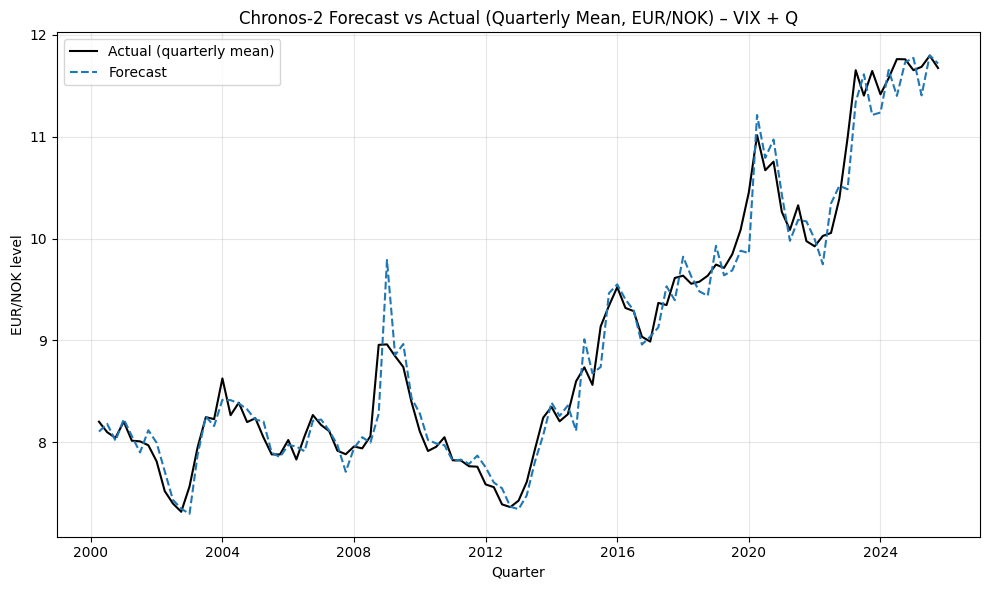

Saved: Chronos2Q_VIX_Q.png
Saved: Chronos2Q_VIX_Q.pdf

RUN 2: VIX + Q + Brent

=== Chronos-2 (VIX + Q + Brent) [locked quarters] (quarterly mean) ===
Observations: 103
RMSE (level): 0.196346
MAE  (level): 0.141176
Directional accuracy: 80/102 (78.4%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: -1.5941
p-value     : 0.1109


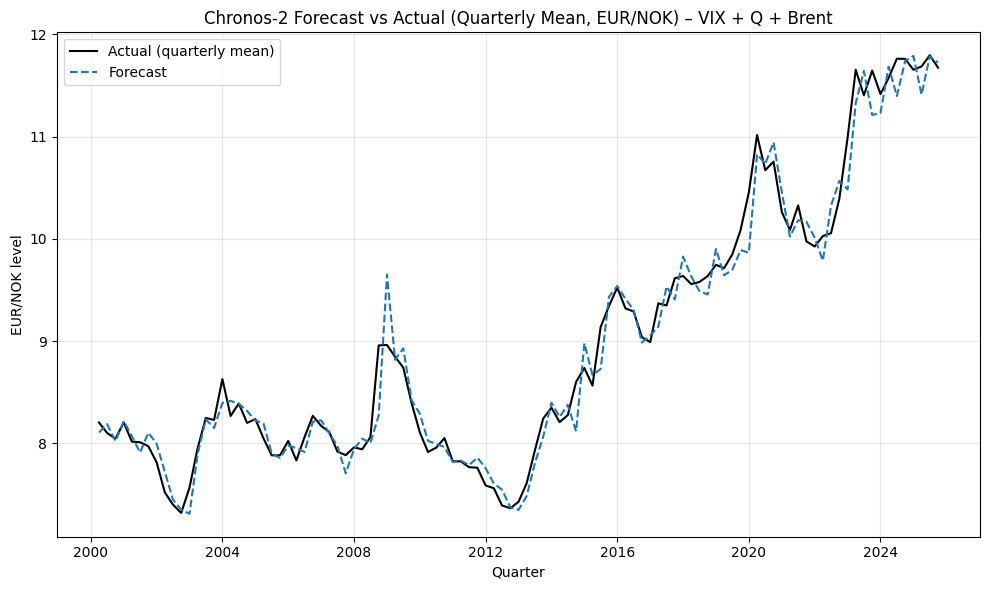

Saved: Chronos2Q_VIX_Q_Brent.png
Saved: Chronos2Q_VIX_Q_Brent.pdf

=== Comparison on locked quarters ===
n_quarters=103
VIX+Q       : DM=-1.4740 | p=0.1405 | RMSE=0.2029 | MAE=0.1443
VIX+Q+Brent : DM=-1.5941 | p=0.1109 | RMSE=0.1963 | MAE=0.1412


In [ ]:
# Chronos_Fx-Quarterly_CompareCovSets
# Runs:
#   (1) VIX + Q
#   (2) VIX + Q + Brent
# Uses existing helper cells:
#   - DATA_CFG, download_csv_text, load_fx_series_daily_and_business, last_trading_day
#   - EVAL_QUARTERLY

from __future__ import annotations

import io
import warnings
from dataclasses import dataclass
from typing import Dict, Callable, List, Tuple

import numpy as np
import pandas as pd
import torch
from chronos import BaseChronosPipeline

# -----------------------------
# Silence warnings in output
# -----------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message=r".*predict_batches_jointly.*deprecated.*", category=FutureWarning)

# -----------------------------
# Config
# -----------------------------
TARGET_SERIES = "EUR_NOK"

COVSET_1 = ["VIX", "Q"]
COVSET_2 = ["VIX", "Q", "Brent"]

@dataclass
class CFG_Q:
    q_freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 128
    verbose: bool = True

CFG = CFG_Q()

# -----------------------------
# Covariates loader (D, ffill)
# -----------------------------
def load_daily_covariates(url: str, cov_cols: List[str]) -> pd.DataFrame:
    text = download_csv_text(url, DATA_CFG.retries, DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required = {"Date", *cov_cols}
    missing = required - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[["Date"] + cov_cols]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in cov_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    DF = df.reindex(full_idx).ffill()
    DF.index.name = "DATE"
    return DF

# -----------------------------
# Context builder (single item, past covariates)
# -----------------------------
def make_pastcov_context(hist_target_d: pd.Series, hist_cov_d: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()

    ctx = pd.DataFrame(
        {
            "timestamp": hist_target_d.index,
            "item_id": TARGET_SERIES,
            "target": hist_target_d.values.astype(float),
        }
    )
    for c in cov_cols:
        ctx[c] = hist_cov_d[c].values.astype(float)

    return ctx.sort_values("timestamp")

# -----------------------------
# Chronos-2 model builder (past covariates, NO cross-learning)
#   - uses cross_learning=False when supported
#   - falls back to predict_batches_jointly=False (suppressed warning)
# -----------------------------
def build_model_chronos2_pastcov_no_crosslearning(max_context: int) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Install CUDA PyTorch + drivers.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        torch_dtype=torch.float16,
    )

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(max_context).copy()
        with torch.inference_mode():
            try:
                pred = pipeline.predict_df(
                    ctx,
                    prediction_length=H,
                    quantile_levels=[0.5],
                    id_column="item_id",
                    timestamp_column="timestamp",
                    target="target",
                    cross_learning=False,  # preferred (new API)
                )
            except TypeError:
                pred = pipeline.predict_df(
                    ctx,
                    prediction_length=H,
                    quantile_levels=[0.5],
                    id_column="item_id",
                    timestamp_column="timestamp",
                    target="target",
                    predict_batches_jointly=False,  # fallback (deprecated, warnings suppressed)
                )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward -> period_df (Q-DEC) with cut_level for EVAL_QUARTERLY
# -----------------------------
def walk_forward_quarterly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    first_q = pd.Period(S_b.index.min(), freq=CFG.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.q_freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_quarter"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue

        y_true = float(S_b.loc[idx_q_b].mean())
        cut_level = float(S_b.loc[cut])

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_pastcov_context(hist_target_d, COV_d.loc[:cut], cov_cols)
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(q)] = {"quarter": q, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("quarter").sort_index()
        if not isinstance(period_df.index, pd.PeriodIndex):
            period_df.index = pd.PeriodIndex(period_df.index, freq=CFG.q_freq)

    if CFG.verbose and dropped:
        miss = [str(q) for q in quarters if (period_df.empty or q not in period_df.index)]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return period_df

# -----------------------------
# Run both cov-sets, lock common quarters, eval + plot
# -----------------------------
def run_one(label: str, cov_cols: List[str], png: str, pdf: str) -> Tuple[pd.DataFrame, pd.DataFrame, Dict]:
    # target via helper loader
    S_b, S_d = load_fx_series_daily_and_business(
        url=DATA_CFG.url,
        series=TARGET_SERIES,
        retries=DATA_CFG.retries,
        timeout=DATA_CFG.timeout,
    )

    # covariates daily D ffill (only the ones needed)
    COV_d = load_daily_covariates(DATA_CFG.url, cov_cols)

    forecast_fn = build_model_chronos2_pastcov_no_crosslearning(max_context=CFG.max_context)

    period_df = walk_forward_quarterly_perioddf(S_b, S_d, COV_d, forecast_fn, cov_cols)
    core, res = EVAL_QUARTERLY["evaluate_period_df"](period_df, loss="mse", h=1, label=label, print_output=True)

    EVAL_QUARTERLY["plot_period_simple"](
        period_df,
        title=f"{label} (Quarterly Mean, EUR/NOK)",
        png_path=png,
        pdf_path=pdf,
        y_label="EUR/NOK level",
        show=True,
    )
    return period_df, core, res

def main():
    print("\n==============================")
    print("RUN 1: VIX + Q")
    print("==============================")
    # Build both period_dfs first (to lock quarters consistently)
    S_b, S_d = load_fx_series_daily_and_business(
        url=DATA_CFG.url,
        series=TARGET_SERIES,
        retries=DATA_CFG.retries,
        timeout=DATA_CFG.timeout,
    )

    COV_d_1 = load_daily_covariates(DATA_CFG.url, COVSET_1)
    COV_d_2 = load_daily_covariates(DATA_CFG.url, COVSET_2)

    forecast_fn = build_model_chronos2_pastcov_no_crosslearning(max_context=CFG.max_context)

    period_1 = walk_forward_quarterly_perioddf(S_b, S_d, COV_d_1, forecast_fn, COVSET_1)
    period_2 = walk_forward_quarterly_perioddf(S_b, S_d, COV_d_2, forecast_fn, COVSET_2)

    if period_1.empty or period_2.empty:
        raise RuntimeError("One of the period_dfs is empty. Cannot lock quarters for comparison.")

    common_q = period_1.index.intersection(period_2.index)
    period_1_lock = period_1.loc[common_q].copy()
    period_2_lock = period_2.loc[common_q].copy()

    print("\nLocked quarters for fair comparison:", len(common_q))

    core1, res1 = EVAL_QUARTERLY["evaluate_period_df"](
        period_1_lock,
        loss="mse",
        h=1,
        label="Chronos-2 (VIX + Q) [locked quarters]",
        print_output=True,
    )
    EVAL_QUARTERLY["plot_period_simple"](
        period_1_lock,
        title="Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK) – VIX + Q",
        png_path="Chronos2Q_VIX_Q.png",
        pdf_path="Chronos2Q_VIX_Q.pdf",
        y_label="EUR/NOK level",
        show=True,
    )

    print("\n==============================")
    print("RUN 2: VIX + Q + Brent")
    print("==============================")
    core2, res2 = EVAL_QUARTERLY["evaluate_period_df"](
        period_2_lock,
        loss="mse",
        h=1,
        label="Chronos-2 (VIX + Q + Brent) [locked quarters]",
        print_output=True,
    )
    EVAL_QUARTERLY["plot_period_simple"](
        period_2_lock,
        title="Chronos-2 Forecast vs Actual (Quarterly Mean, EUR/NOK) – VIX + Q + Brent",
        png_path="Chronos2Q_VIX_Q_Brent.png",
        pdf_path="Chronos2Q_VIX_Q_Brent.pdf",
        y_label="EUR/NOK level",
        show=True,
    )

    # Compact comparison print
    def _fmt(x):
        return f"{x:.4f}" if np.isfinite(x) else "nan"

    print("\n=== Comparison on locked quarters ===")
    print(f"n_quarters={len(common_q)}")
    print(f"VIX+Q       : DM={_fmt(res1.get('dm_stat', np.nan))} | p={_fmt(res1.get('dm_pvalue', np.nan))} | RMSE={_fmt(res1.get('rmse', np.nan))} | MAE={_fmt(res1.get('mae', np.nan))}")
    print(f"VIX+Q+Brent : DM={_fmt(res2.get('dm_stat', np.nan))} | p={_fmt(res2.get('dm_pvalue', np.nan))} | RMSE={_fmt(res2.get('rmse', np.nan))} | MAE={_fmt(res2.get('mae', np.nan))}")

if __name__ == "__main__":
    main()


## Finetuning Best Param

### M

In [ ]:
# ============================
# CELL: Robust fine-tune tuning (MONTHLY) -> res_df + BEST_FT_PARAMS
# ============================

from __future__ import annotations
import io, time, itertools, random
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import requests, certifi
from sklearn.metrics import mean_absolute_error

import torch
from chronos import BaseChronosPipeline  # chronos-forecasting>=2.0


# -----------------------------
# Config / constants
# -----------------------------
FINETUNE_FX_COLS = [
    "AUD", "CAD", "CHF", "DKK", "GBP",
    "ISK", "JPY", "NZD", "SEK", "USD", "XDR",
]

NB_PANEL_URL = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
)

@dataclass
class FTConfig:
    prediction_length: int = 32
    num_steps: int = 50
    learning_rate: float = 1e-5
    batch_size: int = 2
    logging_steps: int = 10
    max_context: int = 2048
    min_hist_days: int = 40
    max_horizon_days: int = 64
    freq: str = "M"      # MONTHLY
    verbose: bool = True

FTCFG = FTConfig()


# -----------------------------
# Helpers
# -----------------------------
def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def download_csv_text(url: str, retries: int = 3, timeout: int = 60) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                time.sleep(1.5 * k)
    raise RuntimeError(f"Download failed: {last_err}")

def load_finetune_fx_panel(url: str) -> pd.DataFrame:
    text = download_csv_text(url)
    raw = pd.read_csv(
        io.StringIO(text),
        sep=";",
        decimal=".",
        encoding="utf-8-sig",
    )
    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in FINETUNE_FX_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df

def build_base_chronos_pipeline() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available.")
    # Chronos API: prefer dtype=... (torch_dtype is deprecated in some versions)
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        dtype=torch.float16,
    )

def finetune_chronos_on_nb_panel(
    pipeline: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    ft_params: FTConfig,
) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        series = fx_panel[col].dropna().astype(np.float32).values
        if series.size < ft_params.prediction_length * 2:
            continue
        train_inputs.append({"target": series, "past_covariates": {}, "future_covariates": {}})

    if not train_inputs:
        raise RuntimeError("No valid series for fine-tuning.")

    return pipeline.fit(
        inputs=train_inputs,
        prediction_length=ft_params.prediction_length,
        num_steps=ft_params.num_steps,
        learning_rate=ft_params.learning_rate,
        batch_size=ft_params.batch_size,
        logging_steps=ft_params.logging_steps,
    )

def series_daily_and_b(df_d: pd.DataFrame, col: str) -> Tuple[pd.Series, pd.Series]:
    S_d = df_d[col].astype(float)
    S_b = S_d.asfreq("B").ffill()
    return S_b, S_d

def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None

def extract_median(pred: pd.DataFrame) -> np.ndarray:
    df = pred.copy()
    if "timestamp" in df.columns:
        df = df.sort_values("timestamp")
    if "0.5" in df.columns:
        arr = df["0.5"].to_numpy()
    elif "predictions" in df.columns:
        arr = df["predictions"].to_numpy()
    elif "forecast" in df.columns and "quantile" in df.columns:
        df = df.loc[df["quantile"] == 0.5].copy()
        arr = df["forecast"].to_numpy()
    else:
        for cand in ("forecast", "p50", "median", "mean"):
            if cand in df.columns:
                arr = df[cand].to_numpy()
                break
        else:
            raise RuntimeError("Unsupported Chronos schema.")
    return np.asarray(arr, dtype=float)

def build_model_chronos2_priceonly(
    pipeline: BaseChronosPipeline,
    max_context: int,
) -> Callable[[np.ndarray, int], np.ndarray]:
    def forecast_fn(x: np.ndarray, H: int) -> np.ndarray:
        ctx = np.asarray(x, dtype=float).ravel()[-max_context:]
        ts = pd.date_range("2000-01-01", periods=len(ctx), freq="D")
        df = pd.DataFrame({"item_id": "series_1", "timestamp": ts, "target": ctx})
        with torch.inference_mode():
            pred = pipeline.predict_df(
                df,
                prediction_length=int(H),
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
            )
        med = extract_median(pred)
        if med.shape[0] < H:
            raise RuntimeError(f"Chronos returned horizon {med.shape[0]} < H={H}")
        return med[:H]
    return forecast_fn

def period_range_locked(S_b: pd.Series, freq: str, start_period: Optional[pd.Period]) -> pd.PeriodIndex:
    first_p = pd.Period(S_b.index.min(), freq=freq)
    last_p  = pd.Period(S_b.index.max(), freq=freq)
    if start_period is not None:
        first_p = max(first_p, start_period)
    return pd.period_range(first_p, last_p, freq=freq)

def walk_forward_priceonly_period_locked(
    S_b: pd.Series,
    S_d: pd.Series,
    forecast_fn: Callable[[np.ndarray, int], np.ndarray],
    periods: pd.PeriodIndex,
    min_hist_days: int,
    max_context: int,
    max_horizon_days: int,
) -> pd.DataFrame:
    rows: Dict[str, Dict[str, float]] = {}
    for p in periods:
        prev_p = p - 1
        p_start, p_end = p.start_time, p.end_time
        prev_start, prev_end = prev_p.start_time, prev_p.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            continue

        hist_d = S_d.loc[:cut]
        if hist_d.size < min_hist_days:
            continue

        idx_p_b = S_b.index[(S_b.index >= p_start) & (S_b.index <= p_end)]
        if idx_p_b.size < 1:
            continue

        y_true = float(S_b.loc[idx_p_b].mean())

        H = (p_end.date() - p_start.date()).days + 1
        if H <= 0 or H > max_horizon_days:
            continue

        ctx_len = min(max_context, len(hist_d))
        x = hist_d.values[-ctx_len:]
        pf = forecast_fn(x, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx)

        pred_b = pred_daily.reindex(idx_p_b, method=None)
        if pred_b.isna().all():
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(p)] = {"period": p, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("period").sort_index()
        if not isinstance(df.index, pd.PeriodIndex):
            df.index = pd.PeriodIndex(df.index, freq=FTCFG.freq)
    return df

def rmse_mae(df_eval: pd.DataFrame) -> Tuple[float, float]:
    core = df_eval.dropna()
    if core.empty:
        return np.nan, np.nan
    err = core["y_true"] - core["y_pred"]
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"]))
    return rmse, mae

def robust_score_for_params(
    train_panel: pd.DataFrame,
    val_daily: pd.DataFrame,
    periods_by_series: Dict[str, pd.PeriodIndex],
    ft_params: FTConfig,
    R: int,
    base_seed: int = 123,
) -> Dict[str, float]:
    rep_scores_rmse: List[float] = []
    rep_scores_mae: List[float] = []

    for r in range(R):
        seed_everything(base_seed + r)

        base_pipe = build_base_chronos_pipeline()
        ft_pipe = finetune_chronos_on_nb_panel(base_pipe, train_panel, ft_params)
        forecast_fn = build_model_chronos2_priceonly(ft_pipe, max_context=ft_params.max_context)

        series_rmse: List[float] = []
        series_mae: List[float] = []

        for col in FINETUNE_FX_COLS:
            if col not in val_daily.columns:
                continue

            S_b, S_d = series_daily_and_b(val_daily, col)
            periods = periods_by_series[col]

            df_eval = walk_forward_priceonly_period_locked(
                S_b=S_b,
                S_d=S_d,
                forecast_fn=forecast_fn,
                periods=periods,
                min_hist_days=ft_params.min_hist_days,
                max_context=ft_params.max_context,
                max_horizon_days=ft_params.max_horizon_days,
            )
            r_rmse, r_mae = rmse_mae(df_eval)
            if np.isfinite(r_rmse):
                series_rmse.append(r_rmse)
                series_mae.append(r_mae)

        rep_scores_rmse.append(float(np.median(series_rmse)) if series_rmse else np.nan)
        rep_scores_mae.append(float(np.median(series_mae)) if series_mae else np.nan)

    rep_scores_rmse = np.asarray(rep_scores_rmse, dtype=float)
    rep_scores_mae  = np.asarray(rep_scores_mae, dtype=float)

    return {
        "rep_median_rmse": float(np.nanmedian(rep_scores_rmse)),
        "rep_iqr_rmse": float(np.nanpercentile(rep_scores_rmse, 75) - np.nanpercentile(rep_scores_rmse, 25)),
        "rep_median_mae": float(np.nanmedian(rep_scores_mae)),
        "rep_iqr_mae": float(np.nanpercentile(rep_scores_mae, 75) - np.nanpercentile(rep_scores_mae, 25)),
        "R": int(R),
    }


# -----------------------------
# Run tuning
# -----------------------------
def run_monthly_tuning() -> pd.DataFrame:
    fx_panel_full = load_finetune_fx_panel(NB_PANEL_URL)

    # Train / validation split
    val_start = pd.Timestamp("1996-01-01")
    train_panel = fx_panel_full.loc[:val_start - pd.Timedelta(days=1)]
    val_panel   = fx_panel_full.loc[val_start:]

    # Daily ffill validation (for walk-forward daily horizons)
    val_daily = val_panel.asfreq("D").ffill()

    # Lock periods per series to validation window
    val_start_period = pd.Period(val_daily.index.min(), freq=FTCFG.freq)
    periods_by_series: Dict[str, pd.PeriodIndex] = {}
    for col in FINETUNE_FX_COLS:
        if col not in val_daily.columns:
            continue
        S_b, _ = series_daily_and_b(val_daily, col)
        periods_by_series[col] = period_range_locked(S_b, freq=FTCFG.freq, start_period=val_start_period)

    # Grid
    grid = {
        "learning_rate": [5e-6, 1e-5, 2e-5],
        "num_steps": [20, 50, 100],
        "batch_size": [2, 4],
        "prediction_length": [32],
    }
    param_list = list(itertools.product(
        grid["learning_rate"],
        grid["num_steps"],
        grid["batch_size"],
        grid["prediction_length"],
    ))

    R = 5  # repetitions per param set
    results: List[Dict] = []

    for lr, steps, bs, pl in param_list:
        ft_params = FTConfig(
            prediction_length=pl,
            num_steps=steps,
            learning_rate=lr,
            batch_size=bs,
            logging_steps=FTCFG.logging_steps,
            max_context=FTCFG.max_context,
            min_hist_days=FTCFG.min_hist_days,
            max_horizon_days=FTCFG.max_horizon_days,
            freq="M",
            verbose=False,
        )

        score = robust_score_for_params(
            train_panel=train_panel,
            val_daily=val_daily,
            periods_by_series=periods_by_series,
            ft_params=ft_params,
            R=R,
            base_seed=123,
        )

        row = {
            "learning_rate": lr,
            "num_steps": steps,
            "batch_size": bs,
            "prediction_length": pl,
            **score,
        }
        results.append(row)

        print(
            f"[M] lr={lr:.0e}, steps={steps}, bs={bs} -> "
            f"RMSE_med={row['rep_median_rmse']:.4f} (IQR={row['rep_iqr_rmse']:.4f}) | "
            f"MAE_med={row['rep_median_mae']:.4f} (IQR={row['rep_iqr_mae']:.4f})"
        )

    res_df = pd.DataFrame(results).sort_values(["rep_median_rmse", "rep_iqr_rmse"]).reset_index(drop=True)

    print("\nTop-10 (Monthly):")
    print(res_df.head(10).to_string(index=False))

    best = res_df.iloc[0].to_dict()
    print("\nBest params (Monthly):")
    print(best)

    return res_df


res_df = run_monthly_tuning()

BEST_FT_PARAMS = FTConfig(
    prediction_length=int(res_df.loc[0, "prediction_length"]),
    num_steps=int(res_df.loc[0, "num_steps"]),
    learning_rate=float(res_df.loc[0, "learning_rate"]),
    batch_size=int(res_df.loc[0, "batch_size"]),
    logging_steps=FTCFG.logging_steps,
    max_context=FTCFG.max_context,
    min_hist_days=FTCFG.min_hist_days,
    max_horizon_days=FTCFG.max_horizon_days,
    freq="M",
    verbose=True,
)

print("\nBEST_FT_PARAMS object ready for next cell:")
print(BEST_FT_PARAMS)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.791500
20,1.723500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.791500
20,1.723500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.791500
20,1.723500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.791500
20,1.723500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.791500
20,1.723500


[M] lr=5e-06, steps=20, bs=2 -> RMSE_med=0.1239 (IQR=0.0000) | MAE_med=0.0904 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.683900
20,2.543100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.683900
20,2.543100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.683900
20,2.543100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.683900
20,2.543100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.683900
20,2.543100


[M] lr=5e-06, steps=20, bs=4 -> RMSE_med=0.1173 (IQR=0.0000) | MAE_med=0.0813 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.788200
20,1.713000
30,2.624100
40,2.709600
50,1.441500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.788200
20,1.713000
30,2.624100
40,2.709600
50,1.441500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.788200
20,1.713000
30,2.624100
40,2.709600
50,1.441500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.788200
20,1.713000
30,2.624100
40,2.709600
50,1.441500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.788200
20,1.713000
30,2.624100
40,2.709600
50,1.441500


[M] lr=5e-06, steps=50, bs=2 -> RMSE_med=0.1215 (IQR=0.0000) | MAE_med=0.0895 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.690300
20,2.559900
30,1.397900
40,2.270400
50,2.461100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.690300
20,2.559900
30,1.397900
40,2.270400
50,2.461100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.690300
20,2.559900
30,1.397900
40,2.270400
50,2.461100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.690300
20,2.559900
30,1.397900
40,2.270400
50,2.461100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.690300
20,2.559900
30,1.397900
40,2.270400
50,2.461100


[M] lr=5e-06, steps=50, bs=4 -> RMSE_med=0.1168 (IQR=0.0000) | MAE_med=0.0778 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.788100
20,1.711800
30,2.661900
40,2.724300
50,1.348800
60,2.602200
70,2.320200
80,1.929000
90,2.710600
100,1.964100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.788100
20,1.711800
30,2.661900
40,2.724300
50,1.348800
60,2.602200
70,2.320200
80,1.929000
90,2.710600
100,1.964100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.788100
20,1.711800
30,2.661900
40,2.724300
50,1.348800
60,2.602200
70,2.320200
80,1.929000
90,2.710600
100,1.964100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.788100
20,1.711800
30,2.661900
40,2.724300
50,1.348800
60,2.602200
70,2.320200
80,1.929000
90,2.710600
100,1.964100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.788100
20,1.711800
30,2.661900
40,2.724300
50,1.348800
60,2.602200
70,2.320200
80,1.929000
90,2.710600
100,1.964100


[M] lr=5e-06, steps=100, bs=2 -> RMSE_med=0.1187 (IQR=0.0000) | MAE_med=0.0829 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.691000
20,2.566200
30,1.394900
40,2.279500
50,2.493000
60,2.100600
70,2.951900
80,2.288800
90,1.875600
100,3.116300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.691000
20,2.566200
30,1.394900
40,2.279500
50,2.493000
60,2.100600
70,2.951900
80,2.288800
90,1.875600
100,3.116300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.691000
20,2.566200
30,1.394900
40,2.279500
50,2.493000
60,2.100600
70,2.951900
80,2.288800
90,1.875600
100,3.116300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.691000
20,2.566200
30,1.394900
40,2.279500
50,2.493000
60,2.100600
70,2.951900
80,2.288800
90,1.875600
100,3.116300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.691000
20,2.566200
30,1.394900
40,2.279500
50,2.493000
60,2.100600
70,2.951900
80,2.288800
90,1.875600
100,3.116300


[M] lr=5e-06, steps=100, bs=4 -> RMSE_med=0.1148 (IQR=0.0000) | MAE_med=0.0828 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.825600
20,1.819600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.825600
20,1.819600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.825600
20,1.819600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.825600
20,1.819600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.825600
20,1.819600


[M] lr=1e-05, steps=20, bs=2 -> RMSE_med=0.1224 (IQR=0.0000) | MAE_med=0.0876 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.748400
20,2.585100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.748400
20,2.585100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.748400
20,2.585100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.748400
20,2.585100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.748400
20,2.585100


[M] lr=1e-05, steps=20, bs=4 -> RMSE_med=0.1166 (IQR=0.0000) | MAE_med=0.0775 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.831100
20,1.815400
30,2.811600
40,2.926200
50,1.349300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.831100
20,1.815400
30,2.811600
40,2.926200
50,1.349300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.831100
20,1.815400
30,2.811600
40,2.926200
50,1.349300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.831100
20,1.815400
30,2.811600
40,2.926200
50,1.349300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.831100
20,1.815400
30,2.811600
40,2.926200
50,1.349300


[M] lr=1e-05, steps=50, bs=2 -> RMSE_med=0.1235 (IQR=0.0000) | MAE_med=0.0946 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.759200
20,2.623000
30,1.437100
40,2.270800
50,2.460200


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.759200
20,2.623000
30,1.437100
40,2.270800
50,2.460200


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.759200
20,2.623000
30,1.437100
40,2.270800
50,2.460200


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.759200
20,2.623000
30,1.437100
40,2.270800
50,2.460200


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.759200
20,2.623000
30,1.437100
40,2.270800
50,2.460200


[M] lr=1e-05, steps=50, bs=4 -> RMSE_med=0.1199 (IQR=0.0000) | MAE_med=0.0840 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.832300
20,1.823800
30,2.843500
40,2.942700
50,1.325900
60,2.817200
70,2.506700
80,1.872100
90,2.768400
100,2.069100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.832300
20,1.823800
30,2.843500
40,2.942700
50,1.325900
60,2.817200
70,2.506700
80,1.872100
90,2.768400
100,2.069100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.832300
20,1.823800
30,2.843500
40,2.942700
50,1.325900
60,2.817200
70,2.506700
80,1.872100
90,2.768400
100,2.069100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.832300
20,1.823800
30,2.843500
40,2.942700
50,1.325900
60,2.817200
70,2.506700
80,1.872100
90,2.768400
100,2.069100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.832300
20,1.823800
30,2.843500
40,2.942700
50,1.325900
60,2.817200
70,2.506700
80,1.872100
90,2.768400
100,2.069100


[M] lr=1e-05, steps=100, bs=2 -> RMSE_med=0.1204 (IQR=0.0000) | MAE_med=0.0865 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.766700
20,2.641800
30,1.453000
40,2.252700
50,2.533900
60,1.968500
70,2.996300
80,2.338900
90,1.862800
100,3.128300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.766700
20,2.641800
30,1.453000
40,2.252700
50,2.533900
60,1.968500
70,2.996300
80,2.338900
90,1.862800
100,3.128300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.766700
20,2.641800
30,1.453000
40,2.252700
50,2.533900
60,1.968500
70,2.996300
80,2.338900
90,1.862800
100,3.128300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.766700
20,2.641800
30,1.453000
40,2.252700
50,2.533900
60,1.968500
70,2.996300
80,2.338900
90,1.862800
100,3.128300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.766700
20,2.641800
30,1.453000
40,2.252700
50,2.533900
60,1.968500
70,2.996300
80,2.338900
90,1.862800
100,3.128300


[M] lr=1e-05, steps=100, bs=4 -> RMSE_med=0.1170 (IQR=0.0000) | MAE_med=0.0803 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.965100
20,1.979000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.965100
20,1.979000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.965100
20,1.979000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.965100
20,1.979000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.965100
20,1.979000


[M] lr=2e-05, steps=20, bs=2 -> RMSE_med=0.1317 (IQR=0.0000) | MAE_med=0.1014 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.899000
20,2.667000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.899000
20,2.667000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.899000
20,2.667000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.899000
20,2.667000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.899000
20,2.667000


[M] lr=2e-05, steps=20, bs=4 -> RMSE_med=0.1284 (IQR=0.0000) | MAE_med=0.0884 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.983300
20,2.033100
30,2.959600
40,2.959100
50,1.383700


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.983300
20,2.033100
30,2.959600
40,2.959100
50,1.383700


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.983300
20,2.033100
30,2.959600
40,2.959100
50,1.383700


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.983300
20,2.033100
30,2.959600
40,2.959100
50,1.383700


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.983300
20,2.033100
30,2.959600
40,2.959100
50,1.383700


[M] lr=2e-05, steps=50, bs=2 -> RMSE_med=0.1251 (IQR=0.0000) | MAE_med=0.0974 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.910100
20,2.787300
30,1.611500
40,2.205300
50,2.562400


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.910100
20,2.787300
30,1.611500
40,2.205300
50,2.562400


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.910100
20,2.787300
30,1.611500
40,2.205300
50,2.562400


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.910100
20,2.787300
30,1.611500
40,2.205300
50,2.562400


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.910100
20,2.787300
30,1.611500
40,2.205300
50,2.562400


[M] lr=2e-05, steps=50, bs=4 -> RMSE_med=0.1243 (IQR=0.0000) | MAE_med=0.0890 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.988300
20,2.061800
30,2.966600
40,3.195000
50,1.510600
60,2.988700
70,2.373400
80,1.870500
90,2.880400
100,2.052100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.988300
20,2.061800
30,2.966600
40,3.195000
50,1.510600
60,2.988700
70,2.373400
80,1.870500
90,2.880400
100,2.052100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.988300
20,2.061800
30,2.966600
40,3.195000
50,1.510600
60,2.988700
70,2.373400
80,1.870500
90,2.880400
100,2.052100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.988300
20,2.061800
30,2.966600
40,3.195000
50,1.510600
60,2.988700
70,2.373400
80,1.870500
90,2.880400
100,2.052100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.988300
20,2.061800
30,2.966600
40,3.195000
50,1.510600
60,2.988700
70,2.373400
80,1.870500
90,2.880400
100,2.052100


[M] lr=2e-05, steps=100, bs=2 -> RMSE_med=0.1280 (IQR=0.0000) | MAE_med=0.0914 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.916400
20,2.826900
30,1.632800
40,2.204000
50,2.766600
60,2.037200
70,3.125200
80,2.265200
90,1.915000
100,3.151300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.916400
20,2.826900
30,1.632800
40,2.204000
50,2.766600
60,2.037200
70,3.125200
80,2.265200
90,1.915000
100,3.151300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.916400
20,2.826900
30,1.632800
40,2.204000
50,2.766600
60,2.037200
70,3.125200
80,2.265200
90,1.915000
100,3.151300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.916400
20,2.826900
30,1.632800
40,2.204000
50,2.766600
60,2.037200
70,3.125200
80,2.265200
90,1.915000
100,3.151300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.916400
20,2.826900
30,1.632800
40,2.204000
50,2.766600
60,2.037200
70,3.125200
80,2.265200
90,1.915000
100,3.151300


[M] lr=2e-05, steps=100, bs=4 -> RMSE_med=0.1226 (IQR=0.0000) | MAE_med=0.0863 (IQR=0.0000)

Top-10 (Monthly):
 learning_rate  num_steps  batch_size  prediction_length  rep_median_rmse  rep_iqr_rmse  rep_median_mae  rep_iqr_mae  R
      0.000005        100           4                 32         0.114848           0.0        0.082829          0.0  5
      0.000010         20           4                 32         0.116607           0.0        0.077494          0.0  5
      0.000005         50           4                 32         0.116762           0.0        0.077757          0.0  5
      0.000010        100           4                 32         0.117002           0.0        0.080301          0.0  5
      0.000005         20           4                 32         0.117279           0.0        0.081254          0.0  5
      0.000005        100           2                 32         0.118655           0.0        0.082888          0.0  5
      0.000010         50           4            


[Finetune] Using HARDCODED best params: BestFTParams(prediction_length=32, num_steps=100, learning_rate=5e-06, batch_size=4, logging_steps=10)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.145100
20,1.308700
30,1.941500
40,1.716800
50,2.579900
60,1.435300
70,1.573300
80,2.064500
90,1.432800
100,1.450900



Dropped months and reasons:
  2000-01: no_cut_in_prev_period
  2000-02: hist<40
  2000-03: hist<40

=== Chronos-2 (FINETUNED) – past covariates; no cross-learning (HARDCODED best params) (monthly mean) ===
Observations: 308
RMSE (level): 0.140014
MAE  (level): 0.097128
Directional accuracy: 206/307 (67.1%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: 0.3130
p-value     : 0.7543

Dropped months and reasons:
  2000-01: no_cut_in_prev_period
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_period
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_period
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_period
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_period
  2000-02: hist<40
  2000-03: hist<40

Dropped months and reasons:
  2000-01: no_cut_in_prev_period
  2000-0

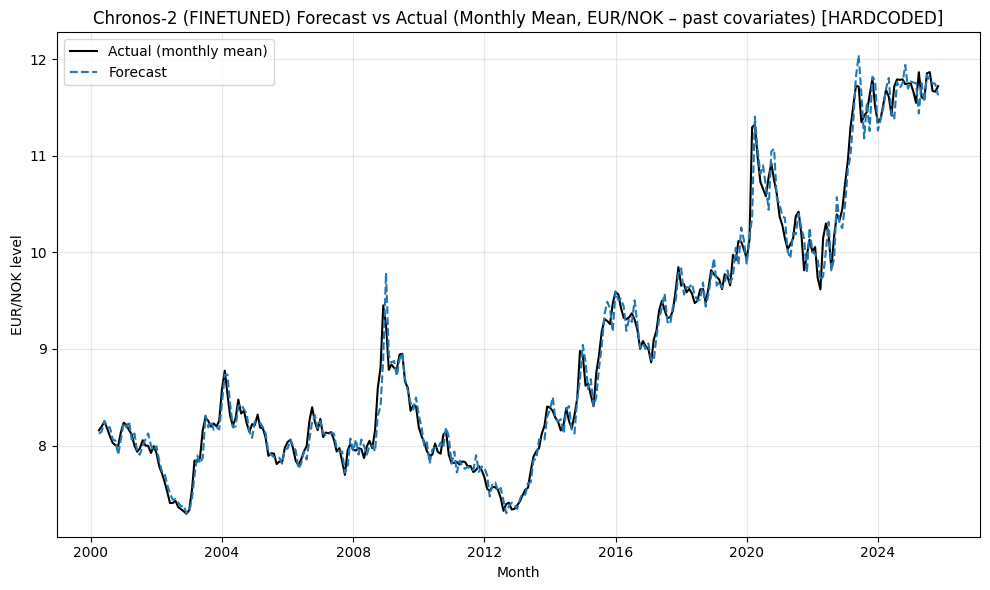

Saved: Chronos2M_LOO_FT.png
Saved: Chronos2M_LOO_FT.pdf

DONE: core_ft, res_ft, loo_ft, period_df_base are in memory.


In [17]:
# ============================
# ONE-CELL: Fine-tune Chronos-2 on NB panel -> Monthly baseline -> Robust LOO
# Requires these to already exist in your notebook:
#   - download_csv_text, DATA_CFG
#   - load_fx_series_daily_and_business, last_trading_day
#   - load_daily_covariates
#   - EVAL_MONTHLY (evaluate_period_df + plot_period_simple)
# ============================

import io
import warnings
from dataclasses import dataclass
from typing import Dict, List, Callable, Tuple, Optional

import numpy as np
import pandas as pd
import torch
from chronos import BaseChronosPipeline

# --- ignore noisy warnings ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=r".*predict_batches_jointly.*deprecated.*")
warnings.filterwarnings("ignore", message=r".*Could not estimate the number of tokens.*")
warnings.filterwarnings("ignore", message=r".*floating-point operations will not be computed.*")

# -----------------------------
# Config (match your setup)
# -----------------------------
TARGET_SERIES = "EUR_NOK"
EXOG_COLS  = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]
MACRO_COLS = ["Q", "d_pi", "dI_t"]
ALL_COV_COLS = EXOG_COLS + MACRO_COLS

FINETUNE_FX_COLS = ["AUD", "CAD", "CHF", "DKK", "GBP", "ISK", "JPY", "NZD", "SEK", "USD", "XDR"]
NB_PANEL_URL = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
)

@dataclass
class BestFTParams:
    prediction_length: int = 32
    num_steps: int = 100
    learning_rate: float = 5e-06
    batch_size: int = 4
    logging_steps: int = 10

BEST_PARAMS = BestFTParams()

@dataclass
class CFG_M:
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    verbose: bool = True
    # robustness knobs
    loss: str = "mse"       # "mse" or "mae"
    h_dm: int = 1           # horizon for DM on period means
    block_len: int = 12     # months per bootstrap block
    n_boot: int = 500
    random_seed: int = 123

CFG = CFG_M()

# -----------------------------
# NB panel loader (fine-tune corpus)
# -----------------------------
def load_finetune_fx_panel_nb(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=";", decimal=".", encoding="utf-8-sig")

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in FINETUNE_FX_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df

# -----------------------------
# Chronos-2 base + finetune
# -----------------------------
def build_base_chronos2() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available.")
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        dtype=torch.float16,
    )

def finetune_chronos2_on_nb_panel(
    base_pipe: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    params: BestFTParams,
) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        s = fx_panel[col].dropna().astype(np.float32).values
        if s.size < params.prediction_length * 2:
            continue
        train_inputs.append({"target": s, "past_covariates": {}, "future_covariates": {}})

    if not train_inputs:
        raise RuntimeError("No valid series for fine-tuning.")

    print("\n[Finetune] Using HARDCODED best params:", params)

    ft_pipe = base_pipe.fit(
        inputs=train_inputs,
        prediction_length=int(params.prediction_length),
        num_steps=int(params.num_steps),
        learning_rate=float(params.learning_rate),
        batch_size=int(params.batch_size),
        logging_steps=int(params.logging_steps),
    )
    return ft_pipe

# -----------------------------
# Past-covariate context builder
# -----------------------------
def make_pastcov_context(
    hist_target_d: pd.Series,
    hist_cov_d: pd.DataFrame,
    cov_cols: List[str],
) -> pd.DataFrame:
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()

    ctx = pd.DataFrame(
        {
            "timestamp": hist_target_d.index,
            "item_id": TARGET_SERIES,
            "target": hist_target_d.values.astype(float),
        }
    )
    for c in cov_cols:
        ctx[c] = hist_cov_d[c].values.astype(float)

    return ctx.sort_values("timestamp")

# -----------------------------
# Forecast fn (past covariates; NO cross-learning)
# -----------------------------
def build_forecast_fn_pastcov_no_crosslearning(
    pipeline: BaseChronosPipeline,
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(max_context).copy()
        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=int(H),
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                cross_learning=False,   # <- explicit
            )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward -> period_df (Monthly)
# -----------------------------
def walk_forward_monthly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_period"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue

        y_true = float(S_b.loc[idx_m_b].mean())
        cut_level = float(S_b.loc[cut])

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_pastcov_context(hist_target_d, COV_d.loc[:cut], cov_cols)
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(m)] = {"month": m, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("month").sort_index()
        if not isinstance(period_df.index, pd.PeriodIndex):
            period_df.index = pd.PeriodIndex(period_df.index, freq="M")

    if CFG.verbose:
        miss = [str(m) for m in months if (period_df.empty or m not in period_df.index)]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return period_df

# -----------------------------
# Robust LOO utilities (same logic as your earlier cell)
# -----------------------------
def _loss_vec(err: pd.Series, loss: str) -> pd.Series:
    loss = loss.lower()
    if loss == "mae":
        return err.abs()
    if loss == "mse":
        return err.pow(2)
    raise ValueError("loss must be 'mse' or 'mae'")

def compute_dm_components(period_df: pd.DataFrame, loss: str) -> pd.Series:
    df = period_df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    if df.empty:
        return pd.Series(dtype=float)
    e_m = df["y_true"] - df["y_pred"]
    e_r = df["y_true"] - df["cut_level"].astype(float)
    d = _loss_vec(e_m, loss) - _loss_vec(e_r, loss)
    d.index = df.index
    return d

def dm_stat_from_d(d: pd.Series, h: int = 1) -> float:
    d = d.dropna()
    N = int(len(d))
    if N < 5:
        return float("nan")

    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan")

    return float(d_mean / np.sqrt(var_bar))

def block_bootstrap_ci(
    d: pd.Series,
    block_len: int,
    n_boot: int,
    seed: int,
) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    rng = np.random.default_rng(seed)
    d = d.dropna().astype(float)
    T = len(d)
    if T < 10:
        return (float("nan"), float("nan")), (float("nan"), float("nan"))

    x = d.to_numpy()
    max_start = max(1, T - block_len + 1)
    starts = np.arange(max_start)

    means = np.empty(n_boot, dtype=float)
    dmstats = np.empty(n_boot, dtype=float)

    for b in range(n_boot):
        sample = []
        while len(sample) < T:
            s = int(rng.choice(starts))
            sample.extend(x[s : s + block_len])
        sample = np.asarray(sample[:T], dtype=float)
        means[b] = float(np.mean(sample))
        dmstats[b] = dm_stat_from_d(pd.Series(sample), h=CFG.h_dm)

    ci_mean = (float(np.quantile(means, 0.025)), float(np.quantile(means, 0.975)))
    ci_dm   = (float(np.quantile(dmstats, 0.025)), float(np.quantile(dmstats, 0.975)))
    return ci_mean, ci_dm

def robust_leave_one_out(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    base_df = walk_forward_monthly_perioddf(S_b, S_d, COV_d, forecast_fn, cov_cols)
    base_df = base_df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    base_months = base_df.index

    d_base = compute_dm_components(base_df, CFG.loss).reindex(base_months).dropna()
    base_mean = float(d_base.mean()) if len(d_base) else float("nan")
    base_dm   = dm_stat_from_d(d_base, h=CFG.h_dm)
    ci_mean_base, ci_dm_base = block_bootstrap_ci(
        d_base, block_len=CFG.block_len, n_boot=CFG.n_boot, seed=CFG.random_seed
    )

    rows = [{
        "covariate": "__BASELINE__",
        "n_months": int(len(d_base)),
        "mean_d": base_mean,
        "mean_d_ci_lo": ci_mean_base[0],
        "mean_d_ci_hi": ci_mean_base[1],
        "dm_stat": base_dm,
        "dm_ci_lo": ci_dm_base[0],
        "dm_ci_hi": ci_dm_base[1],
        "delta_mean_d_vs_base": 0.0,
        "delta_dm_vs_base": 0.0,
    }]

    for c in cov_cols:
        reduced = [x for x in cov_cols if x != c]
        df_i = walk_forward_monthly_perioddf(S_b, S_d, COV_d, forecast_fn, reduced)

        df_i = df_i.reindex(base_months)
        df_i = df_i.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()

        d_i = compute_dm_components(df_i, CFG.loss).reindex(base_months).dropna()

        mean_i = float(d_i.mean()) if len(d_i) else float("nan")
        dm_i = dm_stat_from_d(d_i, h=CFG.h_dm)
        ci_mean_i, ci_dm_i = block_bootstrap_ci(
            d_i,
            block_len=CFG.block_len,
            n_boot=CFG.n_boot,
            seed=CFG.random_seed + 1000 + (hash(c) % 100000),
        )

        rows.append({
            "covariate": c,
            "n_months": int(len(d_i)),
            "mean_d": mean_i,
            "mean_d_ci_lo": ci_mean_i[0],
            "mean_d_ci_hi": ci_mean_i[1],
            "dm_stat": dm_i,
            "dm_ci_lo": ci_dm_i[0],
            "dm_ci_hi": ci_dm_i[1],
            "delta_mean_d_vs_base": (mean_i - base_mean) if np.isfinite(mean_i) and np.isfinite(base_mean) else np.nan,
            "delta_dm_vs_base": (dm_i - base_dm) if np.isfinite(dm_i) and np.isfinite(base_dm) else np.nan,
        })

    out = pd.DataFrame(rows).sort_values(["covariate"]).reset_index(drop=True)
    return out, base_df

def print_ranked_tables(robust_df: pd.DataFrame) -> None:
    base = robust_df.loc[robust_df["covariate"] == "__BASELINE__"].iloc[0]
    loo = robust_df[robust_df["covariate"] != "__BASELINE__"].copy()

    loo_dm = loo.sort_values("delta_dm_vs_base", ascending=False)
    print("\n=== Robust LOO (locked months): rank by ΔDM-stat (higher = worse when removed) ===")
    print(loo_dm[[
        "covariate","n_months","dm_stat","dm_ci_lo","dm_ci_hi","delta_dm_vs_base",
        "mean_d","mean_d_ci_lo","mean_d_ci_hi","delta_mean_d_vs_base"
    ]].to_string(index=False))

    loo_md = loo.sort_values("delta_mean_d_vs_base", ascending=False)
    print("\n=== Robust LOO (locked months): rank by Δmean(d) (higher = worse when removed) ===")
    print(loo_md[[
        "covariate","n_months","mean_d","mean_d_ci_lo","mean_d_ci_hi","delta_mean_d_vs_base",
        "dm_stat","dm_ci_lo","dm_ci_hi","delta_dm_vs_base"
    ]].to_string(index=False))

    print("\n=== Baseline summary ===")
    print(
        f"n_months={int(base['n_months'])} | "
        f"mean(d)={base['mean_d']:.6g} [{base['mean_d_ci_lo']:.6g},{base['mean_d_ci_hi']:.6g}] | "
        f"DM={base['dm_stat']:.4f} [{base['dm_ci_lo']:.4f},{base['dm_ci_hi']:.4f}]"
    )

# ============================
# RUN
# ============================

# 1) Fine-tune
fx_panel = load_finetune_fx_panel_nb(NB_PANEL_URL)
base_pipe = build_base_chronos2()
ft_pipe = finetune_chronos2_on_nb_panel(base_pipe, fx_panel, BEST_PARAMS)

# 2) Load target + covariates (your existing loaders)
S_b, S_d = load_fx_series_daily_and_business(
    url=DATA_CFG.url,
    series=TARGET_SERIES,
    retries=DATA_CFG.retries,
    timeout=DATA_CFG.timeout,
)
COV_d = load_daily_covariates(DATA_CFG.url, ALL_COV_COLS)

# 3) Forecast fn
forecast_fn = build_forecast_fn_pastcov_no_crosslearning(ft_pipe, max_context=CFG.max_context)

# 4) Baseline period_df
period_df_base = walk_forward_monthly_perioddf(S_b, S_d, COV_d, forecast_fn, ALL_COV_COLS)

# 5) Evaluate (your existing eval cell)
core_ft, res_ft = EVAL_MONTHLY["evaluate_period_df"](
    period_df_base,
    loss=CFG.loss,
    h=CFG.h_dm,
    label="Chronos-2 (FINETUNED) – past covariates; no cross-learning (HARDCODED best params)",
    print_output=True,
)

# 6) Robust LOO
loo_ft, _ = robust_leave_one_out(S_b, S_d, COV_d, forecast_fn, ALL_COV_COLS)
print_ranked_tables(loo_ft)

# 7) Plot (optional)
EVAL_MONTHLY["plot_period_simple"](
    period_df_base,
    title="Chronos-2 (FINETUNED) Forecast vs Actual (Monthly Mean, EUR/NOK – past covariates) [HARDCODED]",
    png_path="Chronos2M_LOO_FT.png",
    pdf_path="Chronos2M_LOO_FT.pdf",
    y_label="EUR/NOK level",
    show=True,
)

print("\nDONE: core_ft, res_ft, loo_ft, period_df_base are in memory.")



[Finetune] Using HARDCODED best params: BestFTParams(prediction_length=32, num_steps=100, learning_rate=5e-06, batch_size=4, logging_steps=10)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.144800
20,1.308400
30,1.940500
40,1.718300
50,2.578500
60,1.435200
70,1.571500
80,2.065000
90,1.432300
100,1.450500



Dropped months and reasons:
  2000-01: no_cut_in_prev_period
  2000-02: hist<40
  2000-03: hist<40

=== Chronos-2 (FINETUNED) – selected covariates (Monthly) (monthly mean) ===
Observations: 308
RMSE (level): 0.142329
MAE  (level): 0.097531
Directional accuracy: 211/307 (68.7%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: 1.6223
p-value     : 0.1047


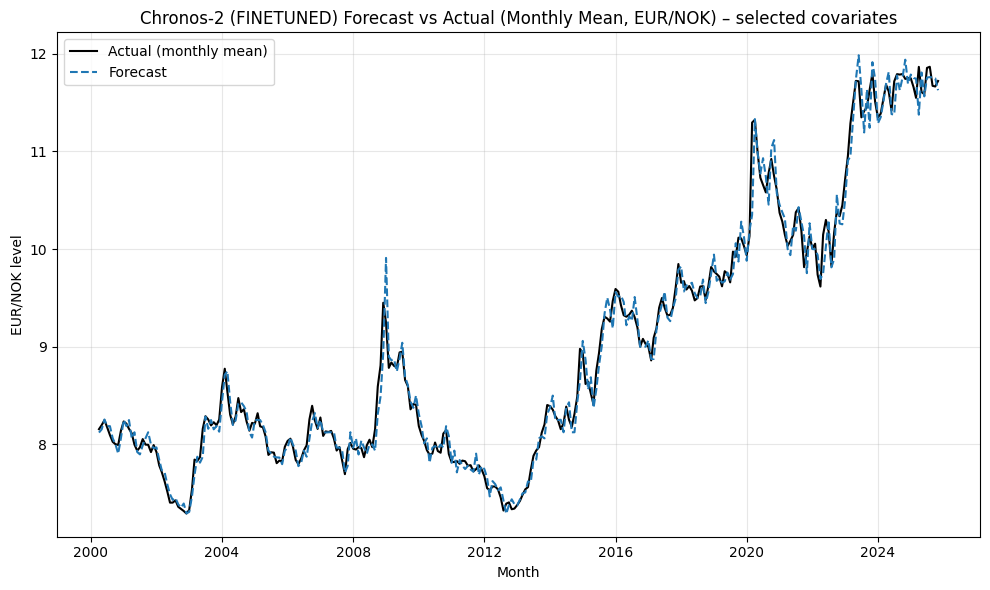

Saved: Chronos2M_FT_SelectedCov.png
Saved: Chronos2M_FT_SelectedCov.pdf

DONE: core_keep, res_keep, period_df_keep are in memory.
Kept covariates: ['Brent', 'OBX_Energy', 'SP500', 'StoxEurope', 'dI_t', 'Q']


In [18]:
# ============================
# ONE-CELL: Fine-tune -> Monthly eval+plot for selected covariates
# Requires these to already exist:
#   - download_csv_text, DATA_CFG
#   - load_fx_series_daily_and_business, last_trading_day
#   - load_daily_covariates
#   - EVAL_MONTHLY (evaluate_period_df + plot_period_simple)
# ============================

import io
import warnings
from dataclasses import dataclass
from typing import Dict, List, Callable, Tuple

import numpy as np
import pandas as pd
import torch
from chronos import BaseChronosPipeline

# --- ignore noisy warnings ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=r".*deprecated.*")
warnings.filterwarnings("ignore", message=r".*Could not estimate the number of tokens.*")
warnings.filterwarnings("ignore", message=r".*floating-point operations will not be computed.*")

# -----------------------------
# Config (monthly)
# -----------------------------
TARGET_SERIES = "EUR_NOK"

# Full list exists in your dataset; we will SELECT a subset for the run
EXOG_COLS  = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]
MACRO_COLS = ["Q", "d_pi", "dI_t"]
ALL_COV_COLS = EXOG_COLS + MACRO_COLS

# Selected covariates to keep (based on your LOO ranking)
KEEP_COV_COLS = ["Brent", "OBX_Energy", "SP500", "StoxEurope", "dI_t", "Q"]

FINETUNE_FX_COLS = ["AUD", "CAD", "CHF", "DKK", "GBP", "ISK", "JPY", "NZD", "SEK", "USD", "XDR"]
NB_PANEL_URL = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
)

@dataclass
class BestFTParams:
    prediction_length: int = 32
    num_steps: int = 100
    learning_rate: float = 5e-06
    batch_size: int = 4
    logging_steps: int = 10

BEST_PARAMS = BestFTParams()

@dataclass
class CFG_M:
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    verbose: bool = True
    loss: str = "mse"
    h_dm: int = 1

CFG = CFG_M()

# -----------------------------
# NB panel loader (fine-tune corpus)
# -----------------------------
def load_finetune_fx_panel_nb(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=";", decimal=".", encoding="utf-8-sig")

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in FINETUNE_FX_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df

# -----------------------------
# Chronos-2 base + finetune
# -----------------------------
def build_base_chronos2() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available.")
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        dtype=torch.float16,
    )

def finetune_chronos2_on_nb_panel(
    base_pipe: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    params: BestFTParams,
) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        s = fx_panel[col].dropna().astype(np.float32).values
        if s.size < params.prediction_length * 2:
            continue
        train_inputs.append({"target": s, "past_covariates": {}, "future_covariates": {}})

    if not train_inputs:
        raise RuntimeError("No valid series for fine-tuning.")

    print("\n[Finetune] Using HARDCODED best params:", params)

    ft_pipe = base_pipe.fit(
        inputs=train_inputs,
        prediction_length=int(params.prediction_length),
        num_steps=int(params.num_steps),
        learning_rate=float(params.learning_rate),
        batch_size=int(params.batch_size),
        logging_steps=int(params.logging_steps),
    )
    return ft_pipe

# -----------------------------
# Context builder (past covariates)
# -----------------------------
def make_pastcov_context(
    hist_target_d: pd.Series,
    hist_cov_d: pd.DataFrame,
    cov_cols: List[str],
) -> pd.DataFrame:
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()

    ctx = pd.DataFrame(
        {
            "timestamp": hist_target_d.index,
            "item_id": TARGET_SERIES,
            "target": hist_target_d.values.astype(float),
        }
    )
    for c in cov_cols:
        ctx[c] = hist_cov_d[c].values.astype(float)

    return ctx.sort_values("timestamp")

# -----------------------------
# Forecast fn
# -----------------------------
def build_forecast_fn_pastcov(
    pipeline: BaseChronosPipeline,
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(max_context).copy()
        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=int(H),
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                cross_learning=False,
            )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward -> period_df (Monthly)
# -----------------------------
def walk_forward_monthly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_period"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue

        y_true = float(S_b.loc[idx_m_b].mean())
        cut_level = float(S_b.loc[cut])

        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_pastcov_context(hist_target_d, COV_d.loc[:cut], cov_cols)
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(m)] = {"month": m, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("month").sort_index()
        if not isinstance(period_df.index, pd.PeriodIndex):
            period_df.index = pd.PeriodIndex(period_df.index, freq="M")

    if CFG.verbose:
        miss = [str(m) for m in months if (period_df.empty or m not in period_df.index)]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return period_df

# ============================
# RUN: finetune -> monthly eval+plot (selected covariates)
# ============================

# 1) Fine-tune
fx_panel = load_finetune_fx_panel_nb(NB_PANEL_URL)
base_pipe = build_base_chronos2()
ft_pipe = finetune_chronos2_on_nb_panel(base_pipe, fx_panel, BEST_PARAMS)

# 2) Load target + covariates
S_b, S_d = load_fx_series_daily_and_business(
    url=DATA_CFG.url,
    series=TARGET_SERIES,
    retries=DATA_CFG.retries,
    timeout=DATA_CFG.timeout,
)

# Load ONLY the covariates we keep
COV_d_keep = load_daily_covariates(DATA_CFG.url, KEEP_COV_COLS)

# 3) Forecast fn
forecast_fn = build_forecast_fn_pastcov(ft_pipe, max_context=CFG.max_context)

# 4) Monthly period_df with selected covariates
period_df_keep = walk_forward_monthly_perioddf(S_b, S_d, COV_d_keep, forecast_fn, KEEP_COV_COLS)

# 5) Evaluate
core_keep, res_keep = EVAL_MONTHLY["evaluate_period_df"](
    period_df_keep,
    loss=CFG.loss,
    h=CFG.h_dm,
    label="Chronos-2 (FINETUNED) – selected covariates (Monthly)",
    print_output=True,
)

# 6) Plot
EVAL_MONTHLY["plot_period_simple"](
    period_df_keep,
    title="Chronos-2 (FINETUNED) Forecast vs Actual (Monthly Mean, EUR/NOK) – selected covariates",
    png_path="Chronos2M_FT_SelectedCov.png",
    pdf_path="Chronos2M_FT_SelectedCov.pdf",
    y_label="EUR/NOK level",
    show=True,
)

print("\nDONE: core_keep, res_keep, period_df_keep are in memory.")
print("Kept covariates:", KEEP_COV_COLS)


### Q

In [7]:
# ============================
# CELL: Robust fine-tune tuning (QUARTERLY / Q-DEC) -> res_df_q + BEST_FT_PARAMS_Q
# ============================

from __future__ import annotations
import io, time, itertools, random
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable, List

import numpy as np
import pandas as pd
import torch
from chronos import BaseChronosPipeline
from sklearn.metrics import mean_absolute_error

# -----------------------------
# Config / constants
# -----------------------------
FINETUNE_FX_COLS = [
    "AUD", "CAD", "CHF", "DKK", "GBP",
    "ISK", "JPY", "NZD", "SEK", "USD", "XDR",
]

NB_PANEL_URL = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
)

@dataclass
class FTConfigQ:
    prediction_length: int = 32
    num_steps: int = 50
    learning_rate: float = 1e-5
    batch_size: int = 2
    logging_steps: int = 10
    max_context: int = 2048
    min_hist_days: int = 40
    max_horizon_days: int = 128   # kvartal ~ 92 dager, 128 er safe
    freq: str = "Q-DEC"
    verbose: bool = True

FTCFG_Q = FTConfigQ()

# -----------------------------
# Helpers
# -----------------------------
def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def load_finetune_fx_panel(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=";", decimal=".", encoding="utf-8-sig")

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in FINETUNE_FX_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df

def build_base_chronos_pipeline() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available.")
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        dtype=torch.float16,
    )

def finetune_chronos_on_nb_panel(
    pipeline: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    ft_params: FTConfigQ,
) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        series = fx_panel[col].dropna().astype(np.float32).values
        if series.size < ft_params.prediction_length * 2:
            continue
        train_inputs.append({"target": series, "past_covariates": {}, "future_covariates": {}})

    if not train_inputs:
        raise RuntimeError("No valid series for fine-tuning.")

    return pipeline.fit(
        inputs=train_inputs,
        prediction_length=int(ft_params.prediction_length),
        num_steps=int(ft_params.num_steps),
        learning_rate=float(ft_params.learning_rate),
        batch_size=int(ft_params.batch_size),
        logging_steps=int(ft_params.logging_steps),
    )

def series_daily_and_b(df_d: pd.DataFrame, col: str) -> Tuple[pd.Series, pd.Series]:
    S_d = df_d[col].astype(float)
    S_b = S_d.asfreq("B").ffill()
    return S_b, S_d

def extract_median(pred: pd.DataFrame) -> np.ndarray:
    df = pred.copy()
    if "timestamp" in df.columns:
        df = df.sort_values("timestamp")
    if "0.5" in df.columns:
        arr = df["0.5"].to_numpy()
    elif "predictions" in df.columns:
        arr = df["predictions"].to_numpy()
    elif "forecast" in df.columns and "quantile" in df.columns:
        df = df.loc[df["quantile"] == 0.5].copy()
        arr = df["forecast"].to_numpy()
    else:
        for cand in ("forecast", "p50", "median", "mean"):
            if cand in df.columns:
                arr = df[cand].to_numpy()
                break
        else:
            raise RuntimeError("Unsupported Chronos schema.")
    return np.asarray(arr, dtype=float)

def build_model_chronos2_priceonly(
    pipeline: BaseChronosPipeline,
    max_context: int,
) -> Callable[[np.ndarray, int], np.ndarray]:
    def forecast_fn(x: np.ndarray, H: int) -> np.ndarray:
        ctx = np.asarray(x, dtype=float).ravel()[-max_context:]
        ts = pd.date_range("2000-01-01", periods=len(ctx), freq="D")
        df = pd.DataFrame({"item_id": "series_1", "timestamp": ts, "target": ctx})
        with torch.inference_mode():
            pred = pipeline.predict_df(
                df,
                prediction_length=int(H),
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
            )
        med = extract_median(pred)
        if med.shape[0] < H:
            raise RuntimeError(f"Chronos returned horizon {med.shape[0]} < H={H}")
        return med[:H]
    return forecast_fn

def period_range_locked(S_b: pd.Series, freq: str, start_period: Optional[pd.Period]) -> pd.PeriodIndex:
    first_p = pd.Period(S_b.index.min(), freq=freq)
    last_p  = pd.Period(S_b.index.max(), freq=freq)
    if start_period is not None:
        first_p = max(first_p, start_period)
    return pd.period_range(first_p, last_p, freq=freq)

def walk_forward_priceonly_period_locked(
    S_b: pd.Series,
    S_d: pd.Series,
    forecast_fn: Callable[[np.ndarray, int], np.ndarray],
    periods: pd.PeriodIndex,
    min_hist_days: int,
    max_context: int,
    max_horizon_days: int,
    freq: str,
) -> pd.DataFrame:
    rows: Dict[str, Dict[str, float]] = {}

    for p in periods:
        prev_p = p - 1
        p_start, p_end = p.start_time, p.end_time
        prev_start, prev_end = prev_p.start_time, prev_p.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            continue

        hist_d = S_d.loc[:cut]
        if hist_d.size < min_hist_days:
            continue

        idx_p_b = S_b.index[(S_b.index >= p_start) & (S_b.index <= p_end)]
        if idx_p_b.size < 1:
            continue

        y_true = float(S_b.loc[idx_p_b].mean())

        H = (p_end.date() - p_start.date()).days + 1
        if H <= 0 or H > max_horizon_days:
            continue

        ctx_len = min(max_context, len(hist_d))
        x = hist_d.values[-ctx_len:]
        pf = forecast_fn(x, H)

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx)

        pred_b = pred_daily.reindex(idx_p_b, method=None)
        if pred_b.isna().all():
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(p)] = {"period": p, "y_true": y_true, "y_pred": y_pred}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("period").sort_index()
        if not isinstance(df.index, pd.PeriodIndex):
            df.index = pd.PeriodIndex(df.index, freq=freq)
    return df

def rmse_mae(df_eval: pd.DataFrame) -> Tuple[float, float]:
    core = df_eval.dropna()
    if core.empty:
        return np.nan, np.nan
    err = core["y_true"] - core["y_pred"]
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"]))
    return rmse, mae

def robust_score_for_params(
    train_panel: pd.DataFrame,
    val_daily: pd.DataFrame,
    periods_by_series: Dict[str, pd.PeriodIndex],
    ft_params: FTConfigQ,
    R: int,
    base_seed: int = 123,
) -> Dict[str, float]:
    rep_scores_rmse: List[float] = []
    rep_scores_mae: List[float] = []

    for r in range(R):
        seed_everything(base_seed + r)

        base_pipe = build_base_chronos_pipeline()
        ft_pipe = finetune_chronos_on_nb_panel(base_pipe, train_panel, ft_params)
        forecast_fn = build_model_chronos2_priceonly(ft_pipe, max_context=ft_params.max_context)

        series_rmse: List[float] = []
        series_mae: List[float] = []

        for col in FINETUNE_FX_COLS:
            if col not in val_daily.columns:
                continue

            S_b, S_d = series_daily_and_b(val_daily, col)
            periods = periods_by_series[col]

            df_eval = walk_forward_priceonly_period_locked(
                S_b=S_b,
                S_d=S_d,
                forecast_fn=forecast_fn,
                periods=periods,
                min_hist_days=ft_params.min_hist_days,
                max_context=ft_params.max_context,
                max_horizon_days=ft_params.max_horizon_days,
                freq=ft_params.freq,
            )
            r_rmse, r_mae = rmse_mae(df_eval)
            if np.isfinite(r_rmse):
                series_rmse.append(r_rmse)
                series_mae.append(r_mae)

        rep_scores_rmse.append(float(np.median(series_rmse)) if series_rmse else np.nan)
        rep_scores_mae.append(float(np.median(series_mae)) if series_mae else np.nan)

    rep_scores_rmse = np.asarray(rep_scores_rmse, dtype=float)
    rep_scores_mae  = np.asarray(rep_scores_mae, dtype=float)

    return {
        "rep_median_rmse": float(np.nanmedian(rep_scores_rmse)),
        "rep_iqr_rmse": float(np.nanpercentile(rep_scores_rmse, 75) - np.nanpercentile(rep_scores_rmse, 25)),
        "rep_median_mae": float(np.nanmedian(rep_scores_mae)),
        "rep_iqr_mae": float(np.nanpercentile(rep_scores_mae, 75) - np.nanpercentile(rep_scores_mae, 25)),
        "R": int(R),
    }

# -----------------------------
# Run tuning (Quarterly)
# -----------------------------
def run_quarterly_tuning() -> pd.DataFrame:
    fx_panel_full = load_finetune_fx_panel(NB_PANEL_URL)

    # Train / validation split
    val_start = pd.Timestamp("1996-01-01")
    train_panel = fx_panel_full.loc[:val_start - pd.Timedelta(days=1)]
    val_panel   = fx_panel_full.loc[val_start:]

    # Daily ffill validation
    val_daily = val_panel.asfreq("D").ffill()

    # Lock periods per series to validation window (Q-DEC)
    val_start_period = pd.Period(val_daily.index.min(), freq=FTCFG_Q.freq)
    periods_by_series: Dict[str, pd.PeriodIndex] = {}
    for col in FINETUNE_FX_COLS:
        if col not in val_daily.columns:
            continue
        S_b, _ = series_daily_and_b(val_daily, col)
        periods_by_series[col] = period_range_locked(S_b, freq=FTCFG_Q.freq, start_period=val_start_period)

    # Grid
    grid = {
        "learning_rate": [5e-6, 1e-5, 2e-5],
        "num_steps": [20, 50, 100],
        "batch_size": [2, 4],
        "prediction_length": [32],
    }
    param_list = list(itertools.product(
        grid["learning_rate"],
        grid["num_steps"],
        grid["batch_size"],
        grid["prediction_length"],
    ))

    R = 5
    results: List[Dict] = []

    for lr, steps, bs, pl in param_list:
        ft_params = FTConfigQ(
            prediction_length=pl,
            num_steps=steps,
            learning_rate=lr,
            batch_size=bs,
            logging_steps=FTCFG_Q.logging_steps,
            max_context=FTCFG_Q.max_context,
            min_hist_days=FTCFG_Q.min_hist_days,
            max_horizon_days=FTCFG_Q.max_horizon_days,
            freq=FTCFG_Q.freq,
            verbose=False,
        )

        score = robust_score_for_params(
            train_panel=train_panel,
            val_daily=val_daily,
            periods_by_series=periods_by_series,
            ft_params=ft_params,
            R=R,
            base_seed=123,
        )

        row = {
            "learning_rate": lr,
            "num_steps": steps,
            "batch_size": bs,
            "prediction_length": pl,
            **score,
        }
        results.append(row)

        print(
            f"[Q] lr={lr:.0e}, steps={steps}, bs={bs} -> "
            f"RMSE_med={row['rep_median_rmse']:.4f} (IQR={row['rep_iqr_rmse']:.4f}) | "
            f"MAE_med={row['rep_median_mae']:.4f} (IQR={row['rep_iqr_mae']:.4f})"
        )

    res_df_q = pd.DataFrame(results).sort_values(["rep_median_rmse", "rep_iqr_rmse"]).reset_index(drop=True)

    print("\nTop-10 (Quarterly / Q-DEC):")
    print(res_df_q.head(10).to_string(index=False))

    best = res_df_q.iloc[0].to_dict()
    print("\nBest params (Quarterly / Q-DEC):")
    print(best)

    return res_df_q

res_df_q = run_quarterly_tuning()

BEST_FT_PARAMS_Q = FTConfigQ(
    prediction_length=int(res_df_q.loc[0, "prediction_length"]),
    num_steps=int(res_df_q.loc[0, "num_steps"]),
    learning_rate=float(res_df_q.loc[0, "learning_rate"]),
    batch_size=int(res_df_q.loc[0, "batch_size"]),
    logging_steps=FTCFG_Q.logging_steps,
    max_context=FTCFG_Q.max_context,
    min_hist_days=FTCFG_Q.min_hist_days,
    max_horizon_days=FTCFG_Q.max_horizon_days,
    freq=FTCFG_Q.freq,
    verbose=True,
)

print("\nBEST_FT_PARAMS_Q object ready for next cell:")
print(BEST_FT_PARAMS_Q)


/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.857300
20,1.771300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.857300
20,1.771300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.857300
20,1.771300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.857300
20,1.771300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.857300
20,1.771300


[Q] lr=5e-06, steps=20, bs=2 -> RMSE_med=0.2026 (IQR=0.0000) | MAE_med=0.1429 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.642800
20,2.528700


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.642800
20,2.528700


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.642800
20,2.528800


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.642800
20,2.528700


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.642800
20,2.528700


[Q] lr=5e-06, steps=20, bs=4 -> RMSE_med=0.2120 (IQR=0.0000) | MAE_med=0.1458 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.856600
20,1.780300
30,2.420800
40,2.627100
50,1.346500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.856600
20,1.780300
30,2.420800
40,2.627100
50,1.346500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.856600
20,1.780300
30,2.420800
40,2.627100
50,1.346500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.856600
20,1.780300
30,2.420800
40,2.627100
50,1.346500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.856600
20,1.780300
30,2.420800
40,2.627100
50,1.346500


[Q] lr=5e-06, steps=50, bs=2 -> RMSE_med=0.2118 (IQR=0.0000) | MAE_med=0.1504 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.649400
20,2.550000
30,1.306900
40,2.222900
50,2.566000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.649300
20,2.550600
30,1.307600
40,2.222200
50,2.567200


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.649300
20,2.550600
30,1.307600
40,2.222500
50,2.567000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.649300
20,2.550600
30,1.307600
40,2.222500
50,2.567000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.649300
20,2.550600
30,1.307600
40,2.222500
50,2.567000


[Q] lr=5e-06, steps=50, bs=4 -> RMSE_med=0.2171 (IQR=0.0000) | MAE_med=0.1554 (IQR=0.0001)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.856100
20,1.785800
30,2.418400
40,2.683200
50,1.332200
60,2.703100
70,2.207300
80,1.881700
90,2.488000
100,1.917600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.856100
20,1.785800
30,2.418400
40,2.683200
50,1.332200
60,2.703100
70,2.207300
80,1.881700
90,2.488000
100,1.917600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.856100
20,1.785800
30,2.418400
40,2.683200
50,1.332200
60,2.703100
70,2.207300
80,1.881700
90,2.488000
100,1.917600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.856100
20,1.785800
30,2.418400
40,2.683200
50,1.332200
60,2.703100
70,2.207300
80,1.881700
90,2.488000
100,1.917600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.856100
20,1.785800
30,2.418400
40,2.683200
50,1.332200
60,2.703100
70,2.207300
80,1.881700
90,2.488000
100,1.917600


[Q] lr=5e-06, steps=100, bs=2 -> RMSE_med=0.2078 (IQR=0.0000) | MAE_med=0.1429 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.651400
20,2.558100
30,1.296800
40,2.255800
50,2.600400
60,2.058000
70,2.926200
80,2.279400
90,1.893400
100,3.033200


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.651400
20,2.558100
30,1.296800
40,2.255800
50,2.600400
60,2.058000
70,2.926200
80,2.279400
90,1.893400
100,3.032500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.651400
20,2.558100
30,1.296800
40,2.255800
50,2.600400
60,2.058000
70,2.926200
80,2.279500
90,1.892600
100,3.034000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.651400
20,2.558100
30,1.296800
40,2.255800
50,2.600600
60,2.057500
70,2.925900
80,2.279200
90,1.892600
100,3.033800


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.651400
20,2.558100
30,1.296800
40,2.255800
50,2.600400
60,2.057400
70,2.925600
80,2.280400
90,1.890600
100,3.034400


[Q] lr=5e-06, steps=100, bs=4 -> RMSE_med=0.2152 (IQR=0.0000) | MAE_med=0.1465 (IQR=0.0002)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.863800
20,1.859000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.863800
20,1.859000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.863800
20,1.859000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.863800
20,1.859000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.863800
20,1.859000


[Q] lr=1e-05, steps=20, bs=2 -> RMSE_med=0.2149 (IQR=0.0000) | MAE_med=0.1565 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.709400
20,2.568900


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.709400
20,2.568900


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.709400
20,2.568900


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.709400
20,2.568900


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.709400
20,2.568900


[Q] lr=1e-05, steps=20, bs=4 -> RMSE_med=0.2134 (IQR=0.0000) | MAE_med=0.1493 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.865800
20,1.890300
30,2.570900
40,2.795700
50,1.337800


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.865800
20,1.890300
30,2.570900
40,2.795700
50,1.337800


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.865800
20,1.890300
30,2.570900
40,2.795700
50,1.337800


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.865800
20,1.890300
30,2.570900
40,2.795700
50,1.337800


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.865800
20,1.890300
30,2.570900
40,2.795700
50,1.337800


[Q] lr=1e-05, steps=50, bs=2 -> RMSE_med=0.2036 (IQR=0.0000) | MAE_med=0.1538 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.724500
20,2.615000
30,1.316000
40,2.325600
50,2.632600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.724500
20,2.615000
30,1.316000
40,2.325600
50,2.632600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.724500
20,2.615200
30,1.315000
40,2.324200
50,2.636100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.724500
20,2.615000
30,1.316000
40,2.325600
50,2.632600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.724500
20,2.615000
30,1.316000
40,2.325600
50,2.632600


[Q] lr=1e-05, steps=50, bs=4 -> RMSE_med=0.2166 (IQR=0.0000) | MAE_med=0.1522 (IQR=0.0001)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.864600
20,1.898600
30,2.572800
40,2.869200
50,1.334900
60,2.903900
70,2.414600
80,1.828000
90,2.496800
100,2.005800


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.864600
20,1.898600
30,2.572800
40,2.869200
50,1.334900
60,2.903900
70,2.414600
80,1.828000
90,2.496800
100,2.005800


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.864600
20,1.898600
30,2.572800
40,2.869200
50,1.334900
60,2.903900
70,2.414600
80,1.828000
90,2.496800
100,2.005800


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.864600
20,1.898600
30,2.572800
40,2.869200
50,1.334900
60,2.903900
70,2.414600
80,1.828000
90,2.496800
100,2.005800


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.864600
20,1.898600
30,2.572800
40,2.869200
50,1.334900
60,2.903900
70,2.414600
80,1.828000
90,2.496800
100,2.005800


[Q] lr=1e-05, steps=100, bs=2 -> RMSE_med=0.1943 (IQR=0.0000) | MAE_med=0.1422 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.729400
20,2.635600
30,1.344900
40,2.299100
50,2.724000
60,2.025000
70,2.977900
80,2.285900
90,1.874900
100,3.060000


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.729400
20,2.635600
30,1.344900
40,2.299500
50,2.723800
60,2.022600
70,2.978100
80,2.287800
90,1.874900
100,3.061300


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.729400
20,2.635600
30,1.344900
40,2.299500
50,2.723800
60,2.022700
70,2.977100
80,2.287000
90,1.874100
100,3.061600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.729400
20,2.635600
30,1.344900
40,2.297600
50,2.724000
60,2.023700
70,2.978500
80,2.288500
90,1.874800
100,3.059700


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.729400
20,2.635600
30,1.344900
40,2.299000
50,2.724000
60,2.023200
70,2.977300
80,2.287100
90,1.875700
100,3.060700


[Q] lr=1e-05, steps=100, bs=4 -> RMSE_med=0.2112 (IQR=0.0006) | MAE_med=0.1473 (IQR=0.0001)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.940900
20,2.047700


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.940900
20,2.047700


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.940900
20,2.047700


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.940900
20,2.047700


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.940900
20,2.047700


[Q] lr=2e-05, steps=20, bs=2 -> RMSE_med=0.2396 (IQR=0.0000) | MAE_med=0.1889 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.864400
20,2.655100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.864400
20,2.655100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.864400
20,2.655100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.864400
20,2.655100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.864400
20,2.655100


[Q] lr=2e-05, steps=20, bs=4 -> RMSE_med=0.2196 (IQR=0.0000) | MAE_med=0.1649 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.961200
20,2.039900
30,2.841900
40,2.828300
50,1.560500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.961200
20,2.039900
30,2.841900
40,2.828300
50,1.560500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.961200
20,2.039900
30,2.841900
40,2.828300
50,1.560500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.961200
20,2.039900
30,2.841900
40,2.828300
50,1.560500


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.961200
20,2.039900
30,2.841900
40,2.828300
50,1.560500


[Q] lr=2e-05, steps=50, bs=2 -> RMSE_med=0.2123 (IQR=0.0000) | MAE_med=0.1699 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.876700
20,2.805600
30,1.519500
40,2.376300
50,2.696200


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.876800
20,2.803600
30,1.518100
40,2.380700
50,2.689200


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.876700
20,2.805600
30,1.519500
40,2.377000
50,2.694600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.876800
20,2.804200
30,1.521800
40,2.375000
50,2.693800


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.876800
20,2.804200
30,1.521800
40,2.375000
50,2.694600


[Q] lr=2e-05, steps=50, bs=4 -> RMSE_med=0.2180 (IQR=0.0007) | MAE_med=0.1593 (IQR=0.0001)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.970000
20,2.055600
30,3.006300
40,2.776300
50,1.721100
60,3.012500
70,2.553500
80,1.999200
90,2.476100
100,1.978100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.970000
20,2.055600
30,3.006300
40,2.776300
50,1.721100
60,3.012500
70,2.553500
80,1.999200
90,2.476100
100,1.978100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.970000
20,2.055600
30,3.006300
40,2.776300
50,1.721100
60,3.012500
70,2.553500
80,1.999200
90,2.476100
100,1.978100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.970000
20,2.055600
30,3.006300
40,2.776300
50,1.721100
60,3.012500
70,2.553500
80,1.999200
90,2.476100
100,1.978100


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.970000
20,2.055600
30,3.006300
40,2.776300
50,1.721100
60,3.012500
70,2.553500
80,1.999200
90,2.476100
100,1.978100


[Q] lr=2e-05, steps=100, bs=2 -> RMSE_med=0.1941 (IQR=0.0000) | MAE_med=0.1445 (IQR=0.0000)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.881300
20,2.847700
30,1.553500
40,2.288300
50,2.944300
60,2.064000
70,3.172500
80,2.278500
90,1.912800
100,3.158400


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.881300
20,2.846500
30,1.552300
40,2.285200
50,2.928000
60,2.067500
70,3.179200
80,2.274100
90,1.917800
100,3.162900


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.881300
20,2.847700
30,1.553500
40,2.288300
50,2.944500
60,2.065000
70,3.170500
80,2.273400
90,1.911000
100,3.162800


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.881300
20,2.847700
30,1.553500
40,2.288300
50,2.944500
60,2.064400
70,3.171600
80,2.274100
90,1.909100
100,3.161600


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,1.881300
20,2.847700
30,1.553500
40,2.288300
50,2.944500
60,2.065000
70,3.170500
80,2.273400
90,1.911000
100,3.162800


[Q] lr=2e-05, steps=100, bs=4 -> RMSE_med=0.2118 (IQR=0.0005) | MAE_med=0.1474 (IQR=0.0003)

Top-10 (Quarterly / Q-DEC):
 learning_rate  num_steps  batch_size  prediction_length  rep_median_rmse  rep_iqr_rmse  rep_median_mae  rep_iqr_mae  R
      0.000020        100           2                 32         0.194113      0.000000        0.144484     0.000000  5
      0.000010        100           2                 32         0.194273      0.000000        0.142187     0.000000  5
      0.000005         20           2                 32         0.202615      0.000000        0.142929     0.000000  5
      0.000010         50           2                 32         0.203558      0.000000        0.153820     0.000000  5
      0.000005        100           2                 32         0.207802      0.000000        0.142935     0.000000  5
      0.000010        100           4                 32         0.211178      0.000577        0.147288     0.000096  5
      0.000020        100           4  


[Finetune-Q] Using HARDCODED best params: BestFTParamsQ(prediction_length=32, num_steps=100, learning_rate=2e-05, batch_size=2, logging_steps=10)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.043900
20,2.374700
30,3.151200
40,1.492200
50,2.545600
60,2.034600
70,2.029900
80,2.019100
90,1.528100
100,2.183600



Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

=== Chronos-2 (FINETUNED) – past covariates (BEST Q params) (quarterly mean) ===
Observations: 103
RMSE (level): 0.221603
MAE  (level): 0.152376
Directional accuracy: 78/102 (76.5%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: 0.9603
p-value     : 0.3369

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

==

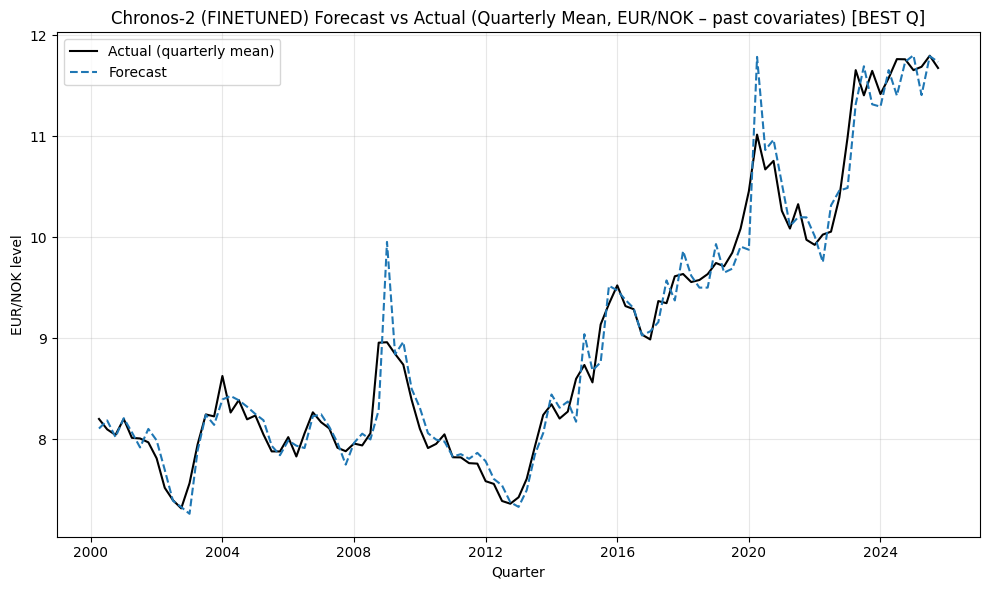

Saved: Chronos2Q_LOO_FT.png
Saved: Chronos2Q_LOO_FT.pdf

DONE: core_ft_q, res_ft_q, loo_ft_q, period_df_base_q are in memory.


In [19]:
# ============================
# ONE-CELL: Fine-tune Chronos-2 on NB panel -> Quarterly baseline (Q-DEC) -> Robust LOO
# Requires already in notebook:
#   - download_csv_text, DATA_CFG
#   - load_fx_series_daily_and_business, last_trading_day
#   - load_daily_covariates
#   - EVAL_QUARTERLY (evaluate_period_df + plot_period_simple)
# ============================

import io
import warnings
from dataclasses import dataclass
from typing import Dict, List, Callable, Tuple

import numpy as np
import pandas as pd
import torch
from chronos import BaseChronosPipeline

# --- ignore noisy warnings ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=r".*predict_batches_jointly.*deprecated.*")
warnings.filterwarnings("ignore", message=r".*Could not estimate the number of tokens.*")
warnings.filterwarnings("ignore", message=r".*floating-point operations will not be computed.*")

# -----------------------------
# Config (Quarterly / Q-DEC)
# -----------------------------
TARGET_SERIES = "EUR_NOK"
EXOG_COLS  = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]
MACRO_COLS = ["Q", "d_pi", "dI_t"]
ALL_COV_COLS = EXOG_COLS + MACRO_COLS

FINETUNE_FX_COLS = ["AUD", "CAD", "CHF", "DKK", "GBP", "ISK", "JPY", "NZD", "SEK", "USD", "XDR"]
NB_PANEL_URL = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
)

@dataclass
class BestFTParamsQ:
    prediction_length: int = 32
    num_steps: int = 100
    learning_rate: float = 2e-05
    batch_size: int = 2
    logging_steps: int = 10

BEST_PARAMS_Q = BestFTParamsQ()

@dataclass
class CFG_Q:
    freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon_days: int = 128
    verbose: bool = True
    # robustness knobs
    loss: str = "mse"
    h_dm: int = 1
    block_len: int = 8
    n_boot: int = 500
    random_seed: int = 123

CFG = CFG_Q()

# -----------------------------
# NB panel loader (fine-tune corpus)
# -----------------------------
def load_finetune_fx_panel_nb(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=";", decimal=".", encoding="utf-8-sig")

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in FINETUNE_FX_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df

# -----------------------------
# Chronos-2 base + finetune
# -----------------------------
def build_base_chronos2() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available.")
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        dtype=torch.float16,
    )

def finetune_chronos2_on_nb_panel(
    base_pipe: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    params: BestFTParamsQ,
) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        s = fx_panel[col].dropna().astype(np.float32).values
        if s.size < params.prediction_length * 2:
            continue
        train_inputs.append({"target": s, "past_covariates": {}, "future_covariates": {}})

    if not train_inputs:
        raise RuntimeError("No valid series for fine-tuning.")

    print("\n[Finetune-Q] Using HARDCODED best params:", params)

    ft_pipe = base_pipe.fit(
        inputs=train_inputs,
        prediction_length=int(params.prediction_length),
        num_steps=int(params.num_steps),
        learning_rate=float(params.learning_rate),
        batch_size=int(params.batch_size),
        logging_steps=int(params.logging_steps),
    )
    return ft_pipe

# -----------------------------
# Past-covariate context builder
# -----------------------------
def make_pastcov_context(hist_target_d: pd.Series, hist_cov_d: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()
    ctx = pd.DataFrame(
        {
            "timestamp": hist_target_d.index,
            "item_id": TARGET_SERIES,
            "target": hist_target_d.values.astype(float),
        }
    )
    for c in cov_cols:
        ctx[c] = hist_cov_d[c].values.astype(float)
    return ctx.sort_values("timestamp")

# -----------------------------
# Forecast fn (past covariates)
# -----------------------------
def build_forecast_fn_pastcov(
    pipeline: BaseChronosPipeline,
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")
        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")
        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(max_context).copy()
        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=int(H),
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                cross_learning=False,
            )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward -> period_df (Quarterly / Q-DEC)
# -----------------------------
def walk_forward_quarterly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    first_q = pd.Period(S_b.index.min(), freq=CFG.freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_period"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue

        y_true = float(S_b.loc[idx_q_b].mean())
        cut_level = float(S_b.loc[cut])

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon_days:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_pastcov_context(hist_target_d, COV_d.loc[:cut], cov_cols)
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(q)] = {"quarter": q, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("quarter").sort_index()
        if not isinstance(period_df.index, pd.PeriodIndex):
            period_df.index = pd.PeriodIndex(period_df.index, freq=CFG.freq)

    if CFG.verbose:
        miss = [str(q) for q in quarters if (period_df.empty or q not in period_df.index)]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return period_df

# -----------------------------
# Robust LOO utilities (Quarterly)
# -----------------------------
def _loss_vec(err: pd.Series, loss: str) -> pd.Series:
    loss = loss.lower()
    if loss == "mae":
        return err.abs()
    if loss == "mse":
        return err.pow(2)
    raise ValueError("loss must be 'mse' or 'mae'")

def compute_dm_components(period_df: pd.DataFrame, loss: str) -> pd.Series:
    df = period_df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    if df.empty:
        return pd.Series(dtype=float)
    e_m = df["y_true"] - df["y_pred"]
    e_r = df["y_true"] - df["cut_level"].astype(float)
    d = _loss_vec(e_m, loss) - _loss_vec(e_r, loss)
    d.index = df.index
    return d

def dm_stat_from_d(d: pd.Series, h: int = 1) -> float:
    d = d.dropna()
    N = int(len(d))
    if N < 5:
        return float("nan")
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N
    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N
    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan")
    return float(d_mean / np.sqrt(var_bar))

def block_bootstrap_ci(d: pd.Series, block_len: int, n_boot: int, seed: int) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    rng = np.random.default_rng(seed)
    d = d.dropna().astype(float)
    T = len(d)
    if T < 8:
        return (float("nan"), float("nan")), (float("nan"), float("nan"))

    x = d.to_numpy()
    max_start = max(1, T - block_len + 1)
    starts = np.arange(max_start)

    means = np.empty(n_boot, dtype=float)
    dmstats = np.empty(n_boot, dtype=float)

    for b in range(n_boot):
        sample = []
        while len(sample) < T:
            s = int(rng.choice(starts))
            sample.extend(x[s : s + block_len])
        sample = np.asarray(sample[:T], dtype=float)
        means[b] = float(np.mean(sample))
        dmstats[b] = dm_stat_from_d(pd.Series(sample), h=CFG.h_dm)

    ci_mean = (float(np.quantile(means, 0.025)), float(np.quantile(means, 0.975)))
    ci_dm   = (float(np.quantile(dmstats, 0.025)), float(np.quantile(dmstats, 0.975)))
    return ci_mean, ci_dm

def robust_leave_one_out(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    base_df = walk_forward_quarterly_perioddf(S_b, S_d, COV_d, forecast_fn, cov_cols)
    base_df = base_df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    base_q = base_df.index

    d_base = compute_dm_components(base_df, CFG.loss).reindex(base_q).dropna()
    base_mean = float(d_base.mean()) if len(d_base) else float("nan")
    base_dm   = dm_stat_from_d(d_base, h=CFG.h_dm)
    ci_mean_base, ci_dm_base = block_bootstrap_ci(d_base, block_len=CFG.block_len, n_boot=CFG.n_boot, seed=CFG.random_seed)

    rows = [{
        "covariate": "__BASELINE__",
        "n_periods": int(len(d_base)),
        "mean_d": base_mean,
        "mean_d_ci_lo": ci_mean_base[0],
        "mean_d_ci_hi": ci_mean_base[1],
        "dm_stat": base_dm,
        "dm_ci_lo": ci_dm_base[0],
        "dm_ci_hi": ci_dm_base[1],
        "delta_mean_d_vs_base": 0.0,
        "delta_dm_vs_base": 0.0,
    }]

    for c in cov_cols:
        reduced = [x for x in cov_cols if x != c]
        df_i = walk_forward_quarterly_perioddf(S_b, S_d, COV_d, forecast_fn, reduced)
        df_i = df_i.reindex(base_q).dropna(subset=["y_true", "y_pred", "cut_level"]).copy()

        d_i = compute_dm_components(df_i, CFG.loss).reindex(base_q).dropna()
        mean_i = float(d_i.mean()) if len(d_i) else float("nan")
        dm_i = dm_stat_from_d(d_i, h=CFG.h_dm)
        ci_mean_i, ci_dm_i = block_bootstrap_ci(
            d_i, block_len=CFG.block_len, n_boot=CFG.n_boot,
            seed=CFG.random_seed + 1000 + (hash(c) % 100000)
        )

        rows.append({
            "covariate": c,
            "n_periods": int(len(d_i)),
            "mean_d": mean_i,
            "mean_d_ci_lo": ci_mean_i[0],
            "mean_d_ci_hi": ci_mean_i[1],
            "dm_stat": dm_i,
            "dm_ci_lo": ci_dm_i[0],
            "dm_ci_hi": ci_dm_i[1],
            "delta_mean_d_vs_base": (mean_i - base_mean) if np.isfinite(mean_i) and np.isfinite(base_mean) else np.nan,
            "delta_dm_vs_base": (dm_i - base_dm) if np.isfinite(dm_i) and np.isfinite(base_dm) else np.nan,
        })

    out = pd.DataFrame(rows).sort_values(["covariate"]).reset_index(drop=True)
    return out, base_df

def print_ranked_tables(robust_df: pd.DataFrame) -> None:
    base = robust_df.loc[robust_df["covariate"] == "__BASELINE__"].iloc[0]
    loo = robust_df[robust_df["covariate"] != "__BASELINE__"].copy()

    loo_dm = loo.sort_values("delta_dm_vs_base", ascending=False)
    print("\n=== Robust LOO (locked quarters): rank by ΔDM-stat (higher = worse when removed) ===")
    print(loo_dm[[
        "covariate","n_periods","dm_stat","dm_ci_lo","dm_ci_hi","delta_dm_vs_base",
        "mean_d","mean_d_ci_lo","mean_d_ci_hi","delta_mean_d_vs_base"
    ]].to_string(index=False))

    loo_md = loo.sort_values("delta_mean_d_vs_base", ascending=False)
    print("\n=== Robust LOO (locked quarters): rank by Δmean(d) (higher = worse when removed) ===")
    print(loo_md[[
        "covariate","n_periods","mean_d","mean_d_ci_lo","mean_d_ci_hi","delta_mean_d_vs_base",
        "dm_stat","dm_ci_lo","dm_ci_hi","delta_dm_vs_base"
    ]].to_string(index=False))

    print("\n=== Baseline summary ===")
    print(
        f"n_periods={int(base['n_periods'])} | "
        f"mean(d)={base['mean_d']:.6g} [{base['mean_d_ci_lo']:.6g},{base['mean_d_ci_hi']:.6g}] | "
        f"DM={base['dm_stat']:.4f} [{base['dm_ci_lo']:.4f},{base['dm_ci_hi']:.4f}]"
    )

# ============================
# RUN
# ============================

# 1) Fine-tune
fx_panel = load_finetune_fx_panel_nb(NB_PANEL_URL)
base_pipe = build_base_chronos2()
ft_pipe = finetune_chronos2_on_nb_panel(base_pipe, fx_panel, BEST_PARAMS_Q)

# 2) Load target + covariates
S_b, S_d = load_fx_series_daily_and_business(
    url=DATA_CFG.url, series=TARGET_SERIES, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout
)
COV_d = load_daily_covariates(DATA_CFG.url, ALL_COV_COLS)

# 3) Forecast fn
forecast_fn = build_forecast_fn_pastcov(ft_pipe, max_context=CFG.max_context)

# 4) Baseline period_df (Quarterly)
period_df_base_q = walk_forward_quarterly_perioddf(S_b, S_d, COV_d, forecast_fn, ALL_COV_COLS)

# 5) Evaluate (Quarterly eval cell)
core_ft_q, res_ft_q = EVAL_QUARTERLY["evaluate_period_df"](
    period_df_base_q,
    loss=CFG.loss,
    h=CFG.h_dm,
    label="Chronos-2 (FINETUNED) – past covariates (BEST Q params)",
    print_output=True,
)

# 6) Robust LOO (Quarterly)
loo_ft_q, _ = robust_leave_one_out(S_b, S_d, COV_d, forecast_fn, ALL_COV_COLS)
print_ranked_tables(loo_ft_q)

# 7) Plot (optional)
EVAL_QUARTERLY["plot_period_simple"](
    period_df_base_q,
    title="Chronos-2 (FINETUNED) Forecast vs Actual (Quarterly Mean, EUR/NOK – past covariates) [BEST Q]",
    png_path="Chronos2Q_LOO_FT.png",
    pdf_path="Chronos2Q_LOO_FT.pdf",
    y_label="EUR/NOK level",
    show=True,
)

print("\nDONE: core_ft_q, res_ft_q, loo_ft_q, period_df_base_q are in memory.")



[Finetune-Q] lr=2e-05, steps=100, bs=2, pred_len=32


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.043900
20,2.374700
30,3.151200
40,1.492200
50,2.545600
60,2.034600
70,2.029900
80,2.019100
90,1.528100
100,2.183600



Dropped periods and reasons:
  2000Q1: no_cut_in_prev_period

=== Chronos-2 (FINETUNED) – selected covariates (Quarterly) (quarterly mean) ===
Observations: 103
RMSE (level): 0.210052
MAE  (level): 0.149897
Directional accuracy: 79/102 (77.5%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: -0.4830
p-value     : 0.6291


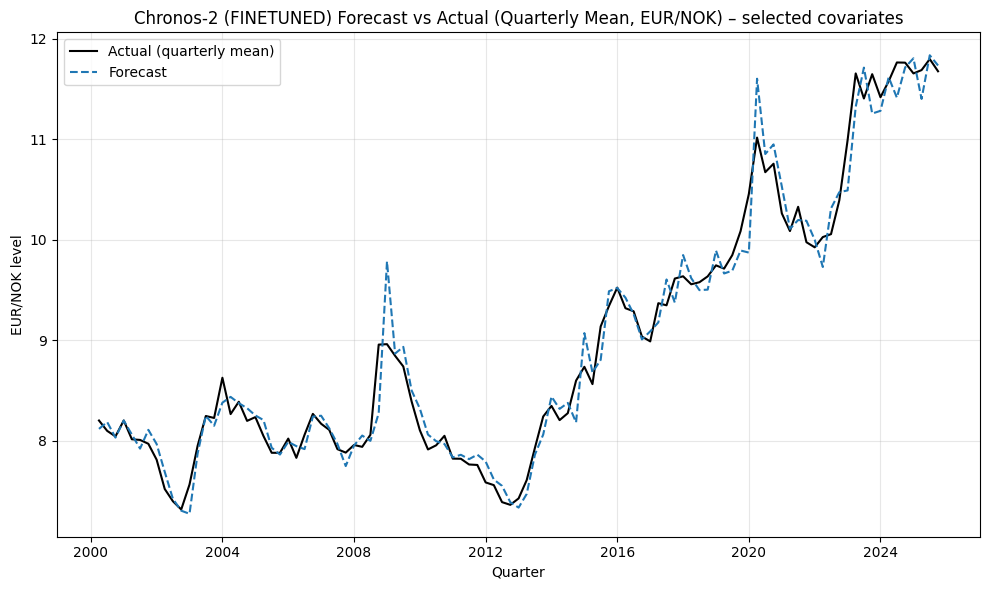

Saved: Chronos2Q_FT_SelectedCov.png
Saved: Chronos2Q_FT_SelectedCov.pdf

DONE: core_keep_q, res_keep_q, period_df_keep_q are in memory.
Kept covariates (Q): ['d_pi', 'Brent', 'StoxEurope', 'OBX_Energy', 'VIX', 'dI_t']


In [22]:
# ============================
# ONE-CELL: Fine-tune (Q) -> Quarterly eval+plot using selected covariates
# Requires in notebook already:
#   - download_csv_text, DATA_CFG
#   - load_fx_series_daily_and_business, last_trading_day
#   - load_daily_covariates
#   - EVAL_Q (evaluate_period_df + plot_period_simple)
#   - BEST_FT_PARAMS_Q (FTConfigQ) from your tuning output
# ============================

import io
import warnings
from dataclasses import dataclass
from typing import Dict, List, Callable

import numpy as np
import pandas as pd
import torch
from chronos import BaseChronosPipeline

# --- ignore noisy warnings ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=r".*deprecated.*")
warnings.filterwarnings("ignore", message=r".*Could not estimate the number of tokens.*")
warnings.filterwarnings("ignore", message=r".*floating-point operations will not be computed.*")

TARGET_SERIES = "EUR_NOK"

# Covariates to keep (from your Robust LOO for Q)
KEEP_COV_COLS_Q = ["d_pi", "Brent", "StoxEurope", "OBX_Energy", "VIX", "dI_t"]

# NB panel for fine-tune
FINETUNE_FX_COLS = ["AUD", "CAD", "CHF", "DKK", "GBP", "ISK", "JPY", "NZD", "SEK", "USD", "XDR"]
NB_PANEL_URL = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
)

# ---------- Load NB panel ----------
def load_finetune_fx_panel_nb(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=";", decimal=".", encoding="utf-8-sig")

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in FINETUNE_FX_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df

# ---------- Build base pipeline ----------
def build_base_chronos2() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available.")
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        dtype=torch.float16,
    )

# ---------- Fine-tune ----------
def finetune_chronos2_on_nb_panel(
    base_pipe: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    ft_cfg,
) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        s = fx_panel[col].dropna().astype(np.float32).values
        if s.size < int(ft_cfg.prediction_length) * 2:
            continue
        train_inputs.append({"target": s, "past_covariates": {}, "future_covariates": {}})

    if not train_inputs:
        raise RuntimeError("No valid series for fine-tuning.")

    print(
        f"\n[Finetune-Q] lr={ft_cfg.learning_rate}, steps={ft_cfg.num_steps}, bs={ft_cfg.batch_size}, pred_len={ft_cfg.prediction_length}"
    )

    ft_pipe = base_pipe.fit(
        inputs=train_inputs,
        prediction_length=int(ft_cfg.prediction_length),
        num_steps=int(ft_cfg.num_steps),
        learning_rate=float(ft_cfg.learning_rate),
        batch_size=int(ft_cfg.batch_size),
        logging_steps=int(getattr(ft_cfg, "logging_steps", 10)),
    )
    return ft_pipe

# ---------- Context builder ----------
def make_pastcov_context(hist_target_d: pd.Series, hist_cov_d: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()
    ctx = pd.DataFrame(
        {"timestamp": hist_target_d.index, "item_id": TARGET_SERIES, "target": hist_target_d.values.astype(float)}
    )
    for c in cov_cols:
        ctx[c] = hist_cov_d[c].values.astype(float)
    return ctx.sort_values("timestamp")

# ---------- Forecast fn ----------
def build_forecast_fn(pipeline: BaseChronosPipeline, max_context: int) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")

        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")

        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(int(max_context)).copy()
        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=int(H),
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                cross_learning=False,
            )
        return _extract_median(pred)

    return _forecast

# ---------- Walk-forward quarterly -> period_df ----------
@dataclass
class CFG_Q:
    freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon_days: int = 128
    verbose: bool = True
    loss: str = "mse"
    h_dm: int = 1

CFG = CFG_Q()

def walk_forward_quarterly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    first_q = pd.Period(S_b.index.min(), freq=CFG.freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.freq)
    periods = pd.period_range(first_q, last_q, freq=CFG.freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for q in periods:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_period"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_period"
            continue

        y_true = float(S_b.loc[idx_q_b].mean())
        cut_level = float(S_b.loc[cut])

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon_days:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_pastcov_context(hist_target_d, COV_d.loc[:cut], cov_cols)
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(q)] = {"period": q, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("period").sort_index()
        if not isinstance(period_df.index, pd.PeriodIndex):
            period_df.index = pd.PeriodIndex(period_df.index, freq=CFG.freq)

    if CFG.verbose:
        miss = [str(p) for p in periods if (period_df.empty or p not in period_df.index)]
        if miss:
            print("\nDropped periods and reasons:")
            for pp in miss:
                print(f"  {pp}: {dropped.get(pp, 'unknown')}")

    return period_df

# ============================
# RUN
# ============================

# 1) Fine-tune Q
fx_panel = load_finetune_fx_panel_nb(NB_PANEL_URL)
base_pipe = build_base_chronos2()
ft_pipe_q = finetune_chronos2_on_nb_panel(base_pipe, fx_panel, BEST_FT_PARAMS_Q)

# 2) Load target + covariates (selected)
S_b, S_d = load_fx_series_daily_and_business(
    url=DATA_CFG.url,
    series=TARGET_SERIES,
    retries=DATA_CFG.retries,
    timeout=DATA_CFG.timeout,
)
COV_d_keep = load_daily_covariates(DATA_CFG.url, KEEP_COV_COLS_Q)

# 3) Forecast fn
forecast_fn = build_forecast_fn(ft_pipe_q, max_context=CFG.max_context)

# 4) Quarterly period_df
period_df_keep_q = walk_forward_quarterly_perioddf(S_b, S_d, COV_d_keep, forecast_fn, KEEP_COV_COLS_Q)

core_keep_q, res_keep_q = EVAL_QUARTERLY["evaluate_period_df"](
    period_df_keep_q,
    loss=CFG.loss,
    h=CFG.h_dm,
    label="Chronos-2 (FINETUNED) – selected covariates (Quarterly)",
    print_output=True,
)

EVAL_QUARTERLY["plot_period_simple"](
    period_df_keep_q,
    title="Chronos-2 (FINETUNED) Forecast vs Actual (Quarterly Mean, EUR/NOK) – selected covariates",
    png_path="Chronos2Q_FT_SelectedCov.png",
    pdf_path="Chronos2Q_FT_SelectedCov.pdf",
    y_label="EUR/NOK level",
    show=True,
)


print("\nDONE: core_keep_q, res_keep_q, period_df_keep_q are in memory.")
print("Kept covariates (Q):", KEEP_COV_COLS_Q)


### Q- M Params


[Finetune-QTEST] Using MONTHLY params in QUARTERLY code: BestFTParams_M(prediction_length=32, num_steps=100, learning_rate=5e-06, batch_size=4, logging_steps=10)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.144600
20,1.308500
30,1.940200
40,1.713800
50,2.576300
60,1.434900
70,1.572000
80,2.065700
90,1.434300
100,1.451400



Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

=== Chronos-2 (FINETUNED) – past covariates (MONTHLY params in Quarterly code) (quarterly mean) ===
Observations: 103
RMSE (level): 0.198386
MAE  (level): 0.143761
Directional accuracy: 77/102 (75.5%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: -1.6519
p-value     : 0.0986
Significance: * (model better than RW)

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

Droppe

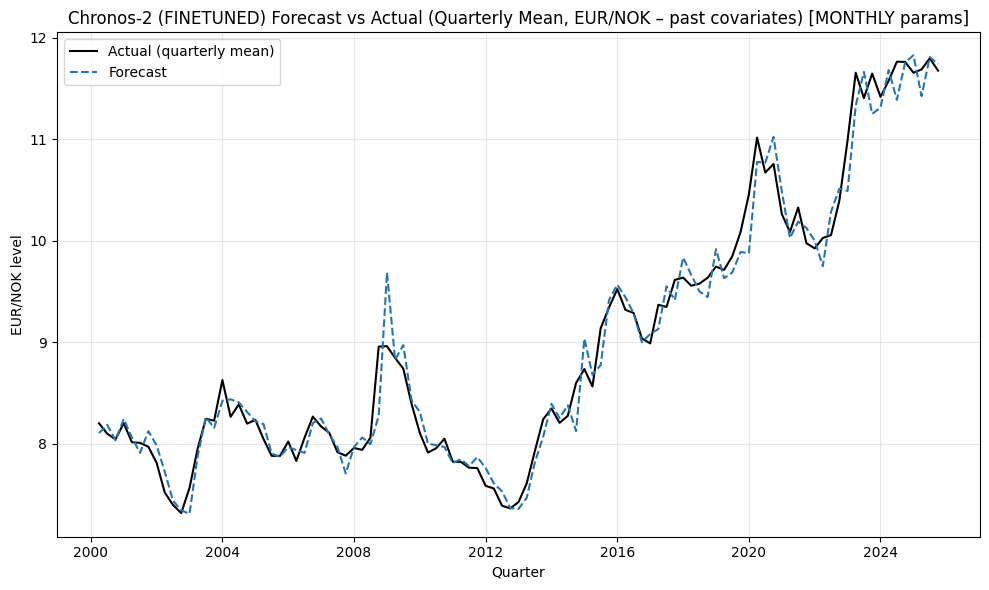

Saved: Chronos2Q_LOO_FT_MonthlyParams.png
Saved: Chronos2Q_LOO_FT_MonthlyParams.pdf

DONE: core_ft_q_mparams, res_ft_q_mparams, loo_ft_q_mparams, period_df_base_q_mparams are in memory.


In [23]:
# ============================
# ONE-CELL TEST: Quarterly (Q-DEC) pipeline, but using MONTHLY fine-tune params
# Requires already in notebook:
#   - download_csv_text, DATA_CFG
#   - load_fx_series_daily_and_business, last_trading_day
#   - load_daily_covariates
#   - EVAL_QUARTERLY (evaluate_period_df + plot_period_simple)
# ============================

import io
import warnings
from dataclasses import dataclass
from typing import Dict, List, Callable, Tuple

import numpy as np
import pandas as pd
import torch
from chronos import BaseChronosPipeline

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=r".*predict_batches_jointly.*deprecated.*")
warnings.filterwarnings("ignore", message=r".*Could not estimate the number of tokens.*")
warnings.filterwarnings("ignore", message=r".*floating-point operations will not be computed.*")

# -----------------------------
# Config (Quarterly / Q-DEC)
# -----------------------------
TARGET_SERIES = "EUR_NOK"
EXOG_COLS  = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]
MACRO_COLS = ["Q", "d_pi", "dI_t"]
ALL_COV_COLS = EXOG_COLS + MACRO_COLS

FINETUNE_FX_COLS = ["AUD", "CAD", "CHF", "DKK", "GBP", "ISK", "JPY", "NZD", "SEK", "USD", "XDR"]
NB_PANEL_URL = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
)

# -----------------------------
# MONTHLY fine-tune params (forced into quarterly code)
# -----------------------------
@dataclass
class BestFTParams_M:
    prediction_length: int = 32
    num_steps: int = 100
    learning_rate: float = 5e-06
    batch_size: int = 4
    logging_steps: int = 10

BEST_PARAMS_M = BestFTParams_M()

@dataclass
class CFG_Q:
    freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon_days: int = 128
    verbose: bool = True
    # robustness knobs
    loss: str = "mse"
    h_dm: int = 1
    block_len: int = 8
    n_boot: int = 500
    random_seed: int = 123

CFG = CFG_Q()

# -----------------------------
# NB panel loader (fine-tune corpus)
# -----------------------------
def load_finetune_fx_panel_nb(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=";", decimal=".", encoding="utf-8-sig")

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in FINETUNE_FX_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all", subset=FINETUNE_FX_COLS)
    return df

# -----------------------------
# Chronos-2 base + finetune
# -----------------------------
def build_base_chronos2() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available.")
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        dtype=torch.float16,
    )

def finetune_chronos2_on_nb_panel(
    base_pipe: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    params: BestFTParams_M,
) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        s = fx_panel[col].dropna().astype(np.float32).values
        if s.size < params.prediction_length * 2:
            continue
        train_inputs.append({"target": s, "past_covariates": {}, "future_covariates": {}})

    if not train_inputs:
        raise RuntimeError("No valid series for fine-tuning.")

    print("\n[Finetune-QTEST] Using MONTHLY params in QUARTERLY code:", params)

    ft_pipe = base_pipe.fit(
        inputs=train_inputs,
        prediction_length=int(params.prediction_length),
        num_steps=int(params.num_steps),
        learning_rate=float(params.learning_rate),
        batch_size=int(params.batch_size),
        logging_steps=int(params.logging_steps),
    )
    return ft_pipe

# -----------------------------
# Past-covariate context builder
# -----------------------------
def make_pastcov_context(hist_target_d: pd.Series, hist_cov_d: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()
    ctx = pd.DataFrame(
        {
            "timestamp": hist_target_d.index,
            "item_id": TARGET_SERIES,
            "target": hist_target_d.values.astype(float),
        }
    )
    for c in cov_cols:
        ctx[c] = hist_cov_d[c].values.astype(float)
    return ctx.sort_values("timestamp")

# -----------------------------
# Forecast fn (past covariates)
# -----------------------------
def build_forecast_fn_pastcov(
    pipeline: BaseChronosPipeline,
    max_context: int,
) -> Callable[[pd.DataFrame, int], pd.DataFrame]:

    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")
        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")
        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(max_context).copy()
        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=int(H),
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                cross_learning=False,
            )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward -> period_df (Quarterly / Q-DEC)
# -----------------------------
def walk_forward_quarterly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    first_q = pd.Period(S_b.index.min(), freq=CFG.freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_period"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue

        y_true = float(S_b.loc[idx_q_b].mean())
        cut_level = float(S_b.loc[cut])

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon_days:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_pastcov_context(hist_target_d, COV_d.loc[:cut], cov_cols)
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(q)] = {"quarter": q, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("quarter").sort_index()
        if not isinstance(period_df.index, pd.PeriodIndex):
            period_df.index = pd.PeriodIndex(period_df.index, freq=CFG.freq)

    if CFG.verbose:
        miss = [str(q) for q in quarters if (period_df.empty or q not in period_df.index)]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return period_df

# -----------------------------
# Robust LOO utilities (Quarterly)
# -----------------------------
def _loss_vec(err: pd.Series, loss: str) -> pd.Series:
    loss = loss.lower()
    if loss == "mae":
        return err.abs()
    if loss == "mse":
        return err.pow(2)
    raise ValueError("loss must be 'mse' or 'mae'")

def compute_dm_components(period_df: pd.DataFrame, loss: str) -> pd.Series:
    df = period_df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    if df.empty:
        return pd.Series(dtype=float)
    e_m = df["y_true"] - df["y_pred"]
    e_r = df["y_true"] - df["cut_level"].astype(float)
    d = _loss_vec(e_m, loss) - _loss_vec(e_r, loss)
    d.index = df.index
    return d

def dm_stat_from_d(d: pd.Series, h: int = 1) -> float:
    d = d.dropna()
    N = int(len(d))
    if N < 5:
        return float("nan")
    d_mean = float(d.mean())
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N
    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N
    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan")
    return float(d_mean / np.sqrt(var_bar))

def block_bootstrap_ci(d: pd.Series, block_len: int, n_boot: int, seed: int) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    rng = np.random.default_rng(seed)
    d = d.dropna().astype(float)
    T = len(d)
    if T < 8:
        return (float("nan"), float("nan")), (float("nan"), float("nan"))

    x = d.to_numpy()
    max_start = max(1, T - block_len + 1)
    starts = np.arange(max_start)

    means = np.empty(n_boot, dtype=float)
    dmstats = np.empty(n_boot, dtype=float)

    for b in range(n_boot):
        sample = []
        while len(sample) < T:
            s = int(rng.choice(starts))
            sample.extend(x[s : s + block_len])
        sample = np.asarray(sample[:T], dtype=float)
        means[b] = float(np.mean(sample))
        dmstats[b] = dm_stat_from_d(pd.Series(sample), h=CFG.h_dm)

    ci_mean = (float(np.quantile(means, 0.025)), float(np.quantile(means, 0.975)))
    ci_dm   = (float(np.quantile(dmstats, 0.025)), float(np.quantile(dmstats, 0.975)))
    return ci_mean, ci_dm

def robust_leave_one_out(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    base_df = walk_forward_quarterly_perioddf(S_b, S_d, COV_d, forecast_fn, cov_cols)
    base_df = base_df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    base_q = base_df.index

    d_base = compute_dm_components(base_df, CFG.loss).reindex(base_q).dropna()
    base_mean = float(d_base.mean()) if len(d_base) else float("nan")
    base_dm   = dm_stat_from_d(d_base, h=CFG.h_dm)
    ci_mean_base, ci_dm_base = block_bootstrap_ci(d_base, block_len=CFG.block_len, n_boot=CFG.n_boot, seed=CFG.random_seed)

    rows = [{
        "covariate": "__BASELINE__",
        "n_periods": int(len(d_base)),
        "mean_d": base_mean,
        "mean_d_ci_lo": ci_mean_base[0],
        "mean_d_ci_hi": ci_mean_base[1],
        "dm_stat": base_dm,
        "dm_ci_lo": ci_dm_base[0],
        "dm_ci_hi": ci_dm_base[1],
        "delta_mean_d_vs_base": 0.0,
        "delta_dm_vs_base": 0.0,
    }]

    for c in cov_cols:
        reduced = [x for x in cov_cols if x != c]
        df_i = walk_forward_quarterly_perioddf(S_b, S_d, COV_d, forecast_fn, reduced)
        df_i = df_i.reindex(base_q).dropna(subset=["y_true", "y_pred", "cut_level"]).copy()

        d_i = compute_dm_components(df_i, CFG.loss).reindex(base_q).dropna()
        mean_i = float(d_i.mean()) if len(d_i) else float("nan")
        dm_i = dm_stat_from_d(d_i, h=CFG.h_dm)
        ci_mean_i, ci_dm_i = block_bootstrap_ci(
            d_i, block_len=CFG.block_len, n_boot=CFG.n_boot,
            seed=CFG.random_seed + 1000 + (hash(c) % 100000)
        )

        rows.append({
            "covariate": c,
            "n_periods": int(len(d_i)),
            "mean_d": mean_i,
            "mean_d_ci_lo": ci_mean_i[0],
            "mean_d_ci_hi": ci_mean_i[1],
            "dm_stat": dm_i,
            "dm_ci_lo": ci_dm_i[0],
            "dm_ci_hi": ci_dm_i[1],
            "delta_mean_d_vs_base": (mean_i - base_mean) if np.isfinite(mean_i) and np.isfinite(base_mean) else np.nan,
            "delta_dm_vs_base": (dm_i - base_dm) if np.isfinite(dm_i) and np.isfinite(base_dm) else np.nan,
        })

    out = pd.DataFrame(rows).sort_values(["covariate"]).reset_index(drop=True)
    return out, base_df

def print_ranked_tables(robust_df: pd.DataFrame) -> None:
    base = robust_df.loc[robust_df["covariate"] == "__BASELINE__"].iloc[0]
    loo = robust_df[robust_df["covariate"] != "__BASELINE__"].copy()

    loo_dm = loo.sort_values("delta_dm_vs_base", ascending=False)
    print("\n=== Robust LOO (locked quarters): rank by ΔDM-stat (higher = worse when removed) ===")
    print(loo_dm[[
        "covariate","n_periods","dm_stat","dm_ci_lo","dm_ci_hi","delta_dm_vs_base",
        "mean_d","mean_d_ci_lo","mean_d_ci_hi","delta_mean_d_vs_base"
    ]].to_string(index=False))

    loo_md = loo.sort_values("delta_mean_d_vs_base", ascending=False)
    print("\n=== Robust LOO (locked quarters): rank by Δmean(d) (higher = worse when removed) ===")
    print(loo_md[[
        "covariate","n_periods","mean_d","mean_d_ci_lo","mean_d_ci_hi","delta_mean_d_vs_base",
        "dm_stat","dm_ci_lo","dm_ci_hi","delta_dm_vs_base"
    ]].to_string(index=False))

    print("\n=== Baseline summary ===")
    print(
        f"n_periods={int(base['n_periods'])} | "
        f"mean(d)={base['mean_d']:.6g} [{base['mean_d_ci_lo']:.6g},{base['mean_d_ci_hi']:.6g}] | "
        f"DM={base['dm_stat']:.4f} [{base['dm_ci_lo']:.4f},{base['dm_ci_hi']:.4f}]"
    )

# ============================
# RUN
# ============================

# 1) Fine-tune using MONTHLY params (but everything else is Quarterly)
fx_panel = load_finetune_fx_panel_nb(NB_PANEL_URL)
base_pipe = build_base_chronos2()
ft_pipe = finetune_chronos2_on_nb_panel(base_pipe, fx_panel, BEST_PARAMS_M)

# 2) Load target + covariates
S_b, S_d = load_fx_series_daily_and_business(
    url=DATA_CFG.url, series=TARGET_SERIES, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout
)
COV_d = load_daily_covariates(DATA_CFG.url, ALL_COV_COLS)

# 3) Forecast fn
forecast_fn = build_forecast_fn_pastcov(ft_pipe, max_context=CFG.max_context)

# 4) Baseline period_df (Quarterly)
period_df_base_q_mparams = walk_forward_quarterly_perioddf(S_b, S_d, COV_d, forecast_fn, ALL_COV_COLS)

# 5) Evaluate (Quarterly eval cell)
core_ft_q_mparams, res_ft_q_mparams = EVAL_QUARTERLY["evaluate_period_df"](
    period_df_base_q_mparams,
    loss=CFG.loss,
    h=CFG.h_dm,
    label="Chronos-2 (FINETUNED) – past covariates (MONTHLY params in Quarterly code)",
    print_output=True,
)

# 6) Robust LOO (Quarterly)
loo_ft_q_mparams, _ = robust_leave_one_out(S_b, S_d, COV_d, forecast_fn, ALL_COV_COLS)
print_ranked_tables(loo_ft_q_mparams)

# 7) Plot
EVAL_QUARTERLY["plot_period_simple"](
    period_df_base_q_mparams,
    title="Chronos-2 (FINETUNED) Forecast vs Actual (Quarterly Mean, EUR/NOK – past covariates) [MONTHLY params]",
    png_path="Chronos2Q_LOO_FT_MonthlyParams.png",
    pdf_path="Chronos2Q_LOO_FT_MonthlyParams.pdf",
    y_label="EUR/NOK level",
    show=True,
)

print("\nDONE: core_ft_q_mparams, res_ft_q_mparams, loo_ft_q_mparams, period_df_base_q_mparams are in memory.")



[Finetune] Using MONTHLY params in QUARTERLY evaluation: BestFTParams_M(prediction_length=32, num_steps=100, learning_rate=5e-06, batch_size=4, logging_steps=10)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.143900
20,1.308100
30,1.942900
40,1.713700
50,2.575700
60,1.434600
70,1.566500
80,2.069200
90,1.433000
100,1.452200



Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

=== Chronos-2 (FINETUNED) (Quarterly, monthly FT params) (quarterly mean) ===
Observations: 103
RMSE (level): 0.198547
MAE  (level): 0.143652
Directional accuracy: 77/102 (75.5%)

=== Diebold–Mariano vs Random Walk (cut-level RW) ===
Loss: MSE | horizon h=1
DM-statistic: -1.6668
p-value     : 0.0956
Significance: * (model better than RW)


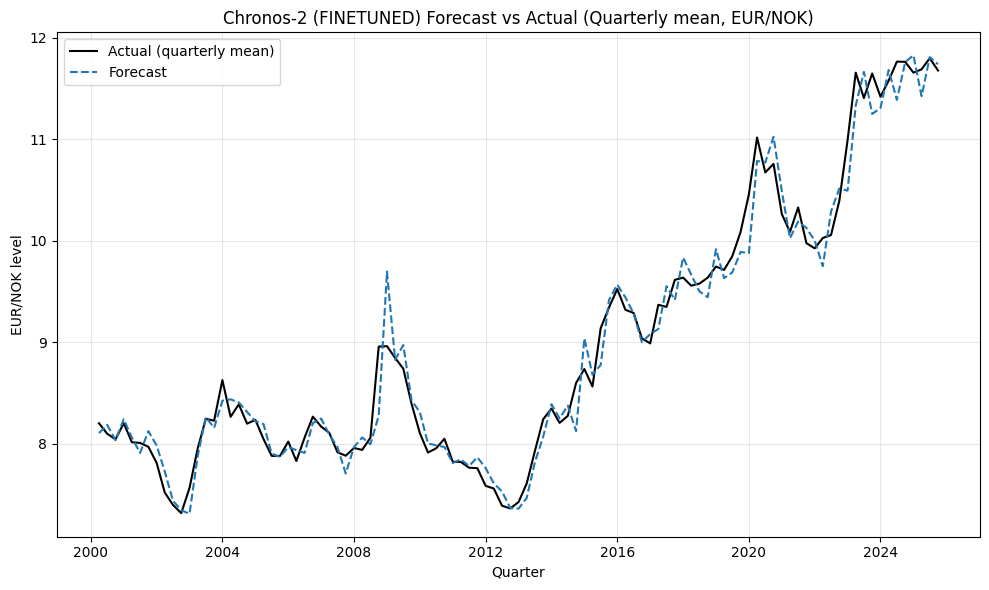

Saved: Chronos2Q_FT_Significant.png
Saved: Chronos2Q_FT_Significant.pdf

DONE: core_sig_q, res_sig_q, period_df_sig_q are in memory.


In [24]:
# ============================
# ONE-CELL: SIGNIFICANT MODEL ONLY
# Chronos-2 FINETUNED with MONTHLY FT params, evaluated on QUARTERLY (Q-DEC)
# Runs: finetune -> period_df -> eval -> plot
#
# Requires already in notebook:
#   - download_csv_text, DATA_CFG
#   - load_fx_series_daily_and_business, last_trading_day
#   - load_daily_covariates
#   - EVAL_QUARTERLY (evaluate_period_df + plot_period_simple)
# ============================

import io
import warnings
from dataclasses import dataclass
from typing import Dict, List, Callable

import numpy as np
import pandas as pd
import torch
from chronos import BaseChronosPipeline

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=r".*predict_batches_jointly.*deprecated.*")
warnings.filterwarnings("ignore", message=r".*Could not estimate the number of tokens.*")
warnings.filterwarnings("ignore", message=r".*floating-point operations will not be computed.*")

# -----------------------------
# Config
# -----------------------------
TARGET_SERIES = "EUR_NOK"

EXOG_COLS  = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]
MACRO_COLS = ["Q", "d_pi", "dI_t"]
ALL_COV_COLS = EXOG_COLS + MACRO_COLS

FINETUNE_FX_COLS = ["AUD", "CAD", "CHF", "DKK", "GBP", "ISK", "JPY", "NZD", "SEK", "USD", "XDR"]
NB_PANEL_URL = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
)

@dataclass
class BestFTParams_M:
    prediction_length: int = 32
    num_steps: int = 100
    learning_rate: float = 5e-06
    batch_size: int = 4
    logging_steps: int = 10

BEST_PARAMS_M = BestFTParams_M()

@dataclass
class CFG_Q:
    freq: str = "Q-DEC"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon_days: int = 128
    verbose: bool = True
    loss: str = "mse"
    h_dm: int = 1

CFG = CFG_Q()

# -----------------------------
# Load finetune panel
# -----------------------------
def load_finetune_fx_panel_nb(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=";", decimal=".", encoding="utf-8-sig")

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in FINETUNE_FX_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.dropna(how="all", subset=FINETUNE_FX_COLS)

# -----------------------------
# Chronos2 base + finetune
# -----------------------------
def build_base_chronos2() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available.")
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        dtype=torch.float16,
    )

def finetune_chronos2_on_nb_panel(
    base_pipe: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    params: BestFTParams_M,
) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        s = fx_panel[col].dropna().astype(np.float32).values
        if s.size < params.prediction_length * 2:
            continue
        train_inputs.append({"target": s, "past_covariates": {}, "future_covariates": {}})

    if not train_inputs:
        raise RuntimeError("No valid series for fine-tuning.")

    print("\n[Finetune] Using MONTHLY params in QUARTERLY evaluation:", params)

    return base_pipe.fit(
        inputs=train_inputs,
        prediction_length=int(params.prediction_length),
        num_steps=int(params.num_steps),
        learning_rate=float(params.learning_rate),
        batch_size=int(params.batch_size),
        logging_steps=int(params.logging_steps),
    )

# -----------------------------
# Context builder
# -----------------------------
def make_pastcov_context(hist_target_d: pd.Series, hist_cov_d: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()
    ctx = pd.DataFrame(
        {
            "timestamp": hist_target_d.index,
            "item_id": TARGET_SERIES,
            "target": hist_target_d.values.astype(float),
        }
    )
    for c in cov_cols:
        ctx[c] = hist_cov_d[c].values.astype(float)
    return ctx.sort_values("timestamp")

# -----------------------------
# Forecast fn
# -----------------------------
def build_forecast_fn_pastcov(pipeline: BaseChronosPipeline, max_context: int) -> Callable[[pd.DataFrame, int], pd.DataFrame]:
    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")
        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")
        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(max_context).copy()
        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=int(H),
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                cross_learning=False,
            )
        return _extract_median(pred)

    return _forecast

# -----------------------------
# Walk-forward quarterly period_df
# -----------------------------
def walk_forward_quarterly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn: Callable[[pd.DataFrame, int], pd.DataFrame],
    cov_cols: List[str],
) -> pd.DataFrame:
    first_q = pd.Period(S_b.index.min(), freq=CFG.freq)
    last_q  = pd.Period(S_b.index.max(), freq=CFG.freq)
    quarters = pd.period_range(first_q, last_q, freq=CFG.freq)

    rows: Dict[str, Dict[str, float]] = {}
    dropped: Dict[str, str] = {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time
        prev_start, prev_end = prev_q.start_time, prev_q.end_time

        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_period"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < CFG.min_hist_days:
            dropped[str(q)] = f"hist<{CFG.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue

        y_true = float(S_b.loc[idx_q_b].mean())
        cut_level = float(S_b.loc[cut])

        H = (q_end.date() - q_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon_days:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_pastcov_context(hist_target_d, COV_d.loc[:cut], cov_cols)
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(q)] = {"quarter": q, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    period_df = pd.DataFrame.from_dict(rows, orient="index")
    if not period_df.empty:
        period_df = period_df.set_index("quarter").sort_index()
        if not isinstance(period_df.index, pd.PeriodIndex):
            period_df.index = pd.PeriodIndex(period_df.index, freq=CFG.freq)

    if CFG.verbose:
        miss = [str(q) for q in quarters if (period_df.empty or q not in period_df.index)]
        if miss:
            print("\nDropped quarters and reasons:")
            for qq in miss:
                print(f"  {qq}: {dropped.get(qq, 'unknown')}")

    return period_df

# ============================
# RUN (significant model)
# ============================

fx_panel = load_finetune_fx_panel_nb(NB_PANEL_URL)
base_pipe = build_base_chronos2()
ft_pipe = finetune_chronos2_on_nb_panel(base_pipe, fx_panel, BEST_PARAMS_M)

S_b, S_d = load_fx_series_daily_and_business(
    url=DATA_CFG.url, series=TARGET_SERIES, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout
)
COV_d = load_daily_covariates(DATA_CFG.url, ALL_COV_COLS)

forecast_fn = build_forecast_fn_pastcov(ft_pipe, max_context=CFG.max_context)

period_df_sig_q = walk_forward_quarterly_perioddf(S_b, S_d, COV_d, forecast_fn, ALL_COV_COLS)

core_sig_q, res_sig_q = EVAL_QUARTERLY["evaluate_period_df"](
    period_df_sig_q,
    loss=CFG.loss,
    h=CFG.h_dm,
    label="Chronos-2 (FINETUNED) (Quarterly, monthly FT params)",
    print_output=True,
)

EVAL_QUARTERLY["plot_period_simple"](
    period_df_sig_q,
    title="Chronos-2 (FINETUNED) Forecast vs Actual (Quarterly mean, EUR/NOK)",
    png_path="Chronos2Q_FT_Significant.png",
    pdf_path="Chronos2Q_FT_Significant.pdf",
    y_label="EUR/NOK level",
    show=True,
)

print("\nDONE: core_sig_q, res_sig_q, period_df_sig_q are in memory.")


## Robustness

CUDA: True

[Finetune] Params: BestFTParams_M(prediction_length=32, num_steps=100, learning_rate=5e-06, batch_size=4, logging_steps=10)


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss
10,2.144800
20,1.308400
30,1.940700
40,1.718100
50,2.578000
60,1.435600
70,1.570400
80,2.064700
90,1.432700
100,1.452100



Dropped months and reasons:
  2000-01: no_cut_in_prev_period
  2000-02: hist<40
  2000-03: hist<40

Dropped quarters and reasons:
  2000Q1: no_cut_in_prev_period

=== MONTHLY (Finetuned Chronos2) ===
                                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos2 FT (Monthly, selected covariates)  308 0.142328 0.097549 0.687296  1.617121 0.105852   308

=== QUARTERLY (Finetuned Chronos2, monthly FT params) ===
                                                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos2 FT (Quarterly, monthly FT params, all covariates)  103 0.195013 0.144206 0.745098 -1.411925 0.157972   103


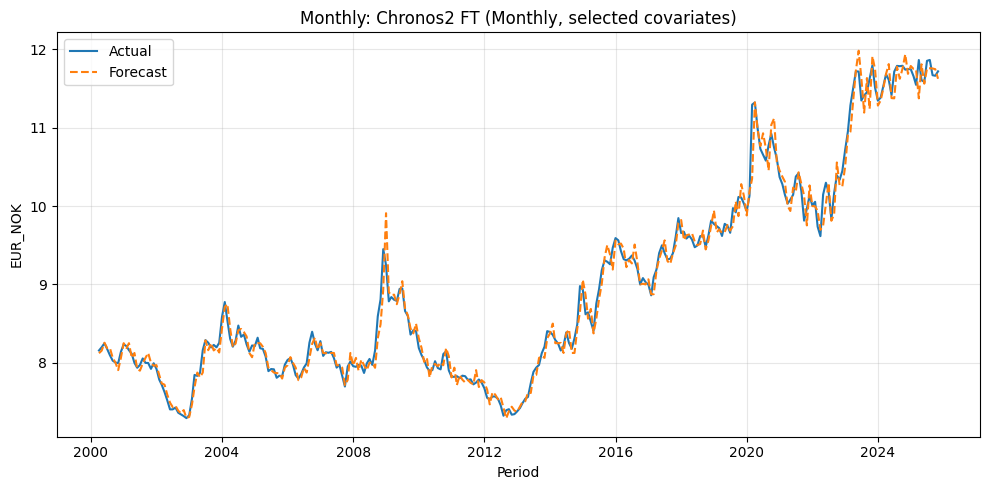

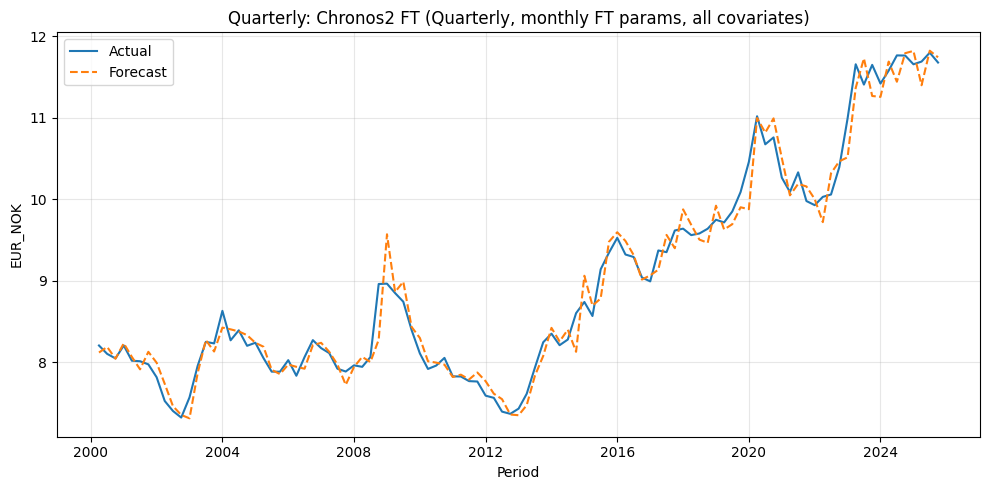


=== REGIME TABLES (MONTHLY) ===

--- Full sample ---
                                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos2 FT (Monthly, selected covariates)  308 0.142328 0.097549 0.687296  1.617121 0.105852   308

--- Pre-GFC ---
                                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos2 FT (Monthly, selected covariates)   92 0.079682 0.060388 0.769231  0.864443 0.387344    92

--- GFC+ ---
                                     Model  Obs     RMSE      MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos2 FT (Monthly, selected covariates)  143 0.129711 0.093206 0.669014  1.927717  0.05389   143

--- COVID+ ---
                                     Model  Obs    RMSE     MAE   DirAcc  DM_vs_RW  p_vs_RW  DM_n
Chronos2 FT (Monthly, selected covariates)   23 0.25775 0.16654 0.636364 -0.409115 0.682455    23

--- Energy+FX shock ---
                                     Model  Obs     RMSE      MAE   DirAcc  DM

In [35]:
# ============================================================
# Chronos-2 FINETUNED —
# - Monthly: finetuned + selected covariates (KEEP_COV_COLS)
# - Quarterly: finetuned with MONTHLY FT params + ALL covariates (ALL_COV_COLS)
# - Regimes + pairwise DM + NULL-centered block bootstrap (DM vs RW)
#
# Requires already in notebook:
#   - download_csv_text, DATA_CFG
#   - load_fx_series_daily_and_business, last_trading_day
#   - load_daily_covariates
#   - EVAL_MONTHLY (optional) / EVAL_QUARTERLY (optional)
# ============================================================

from __future__ import annotations
import io, math, warnings
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=r".*deprecated.*")
warnings.filterwarnings("ignore", message=r".*Could not estimate the number of tokens.*")
warnings.filterwarnings("ignore", message=r".*floating-point operations will not be computed.*")

# -----------------------------
# CONFIG
# -----------------------------
TARGET_SERIES = "EUR_NOK"

EXOG_COLS  = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]
MACRO_COLS = ["Q", "d_pi", "dI_t"]
ALL_COV_COLS = EXOG_COLS + MACRO_COLS

# Monthly selected covariates (from your LOO keep-set)
KEEP_COV_COLS = ["Brent", "OBX_Energy", "SP500", "StoxEurope", "dI_t", "Q"]

FINETUNE_FX_COLS = ["AUD", "CAD", "CHF", "DKK", "GBP", "ISK", "JPY", "NZD", "SEK", "USD", "XDR"]
NB_PANEL_URL = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/FineTuneData/NB1980-1999.csv"
)

@dataclass
class BestFTParams_M:
    prediction_length: int = 32
    num_steps: int = 100
    learning_rate: float = 5e-06
    batch_size: int = 4
    logging_steps: int = 10

FT_PARAMS = BestFTParams_M()

@dataclass
class CFG:
    # horizons
    m_freq: str = "M"
    q_freq: str = "Q-DEC"
    # guards
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon_m: int = 64
    max_horizon_q: int = 128
    # DM
    loss: str = "mse"
    h_dm: int = 1
    # bootstrap
    bootstrap_B: int = 800
    bootstrap_block: Optional[int] = None  # None -> auto ~ n^(1/3)
    seed: int = 42
    # plotting
    show_plots: bool = True

C = CFG()

USE_CUDA = bool(torch.cuda.is_available())
print(f"CUDA: {USE_CUDA}")

# -----------------------------
# REGIMES
# -----------------------------
@dataclass(frozen=True)
class Regime:
    name: str
    start: str
    end: str

REGIMES = [
    Regime("Full sample", "1900-01-01", "2100-01-01"),
    Regime("Pre-GFC", "2000-01-01", "2007-12-31"),
    Regime("GFC+", "2008-01-01", "2019-12-31"),
    Regime("COVID+", "2020-01-01", "2021-12-31"),
    Regime("Energy+FX shock", "2022-01-01", "2100-01-01"),
]

def filter_eval_by_regime(df_eval: pd.DataFrame, reg: Regime) -> pd.DataFrame:
    ts = df_eval.index.to_timestamp(how="end") if isinstance(df_eval.index, pd.PeriodIndex) else pd.to_datetime(df_eval.index)
    mask = (ts >= pd.Timestamp(reg.start)) & (ts <= pd.Timestamp(reg.end))
    return df_eval.loc[mask]

# -----------------------------
# EVAL + DM
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))

def eval_metrics(period_df: pd.DataFrame) -> Dict[str, float]:
    core = period_df.dropna(subset=["y_true", "y_pred"]).copy()
    n = int(len(core))
    if n == 0:
        return dict(obs=0, rmse=np.nan, mae=np.nan, diracc=np.nan)

    err = core["y_true"] - core["y_pred"]
    rmse = float(np.sqrt(np.mean(err**2)))
    mae  = float(np.mean(np.abs(err)))

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    if mask.any():
        dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
        dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
        diracc = float((dir_true.values == dir_pred.values).mean())
    else:
        diracc = np.nan

    return dict(obs=n, rmse=rmse, mae=mae, diracc=diracc)

def _dm_from_d(d: np.ndarray) -> float:
    d = np.asarray(d, dtype=float)
    n = d.size
    if n < 10:
        return float("nan")
    sd = float(d.std(ddof=1))
    if not np.isfinite(sd) or sd <= 0:
        return float("nan")
    return float(d.mean() / (sd / math.sqrt(n)))

def dm_vs_rw_cutlevel(period_df: pd.DataFrame) -> Tuple[float, float, int]:
    core = period_df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    if len(core) < 10:
        return float("nan"), float("nan"), int(len(core))

    e_m = core["y_true"].to_numpy() - core["y_pred"].to_numpy()
    e_r = core["y_true"].to_numpy() - core["cut_level"].to_numpy()
    d = (e_m**2) - (e_r**2)

    dm = _dm_from_d(d)
    p  = float(2.0 * (1.0 - _normal_cdf(abs(dm)))) if np.isfinite(dm) else float("nan")
    return float(dm), float(p), int(len(d))

def dm_pairwise(df_a: pd.DataFrame, df_b: pd.DataFrame) -> Tuple[float, float, int]:
    df = pd.concat({"y": df_a["y_true"], "a": df_a["y_pred"], "b": df_b["y_pred"]}, axis=1).dropna()
    if len(df) < 10:
        return float("nan"), float("nan"), int(len(df))
    e_a = df["y"].to_numpy() - df["a"].to_numpy()
    e_b = df["y"].to_numpy() - df["b"].to_numpy()
    d = (e_a**2) - (e_b**2)
    dm = _dm_from_d(d)
    p  = float(2.0 * (1.0 - _normal_cdf(abs(dm)))) if np.isfinite(dm) else float("nan")
    return float(dm), float(p), int(len(d))

def block_bootstrap_dm_vs_rw_null_centered(
    period_df: pd.DataFrame,
    B: int,
    block: Optional[int],
    seed: int = 42,
    one_sided: bool = True,
) -> Dict[str, float]:
    core = period_df.dropna(subset=["y_true", "y_pred", "cut_level"]).copy()
    n = int(len(core))
    if n < 30:
        return {"n": n, "dm_hat": np.nan, "p_boot": np.nan, "block": np.nan}

    e_m = core["y_true"].to_numpy() - core["y_pred"].to_numpy()
    e_r = core["y_true"].to_numpy() - core["cut_level"].to_numpy()
    d = (e_m**2) - (e_r**2)

    dm_hat = _dm_from_d(d)
    if not np.isfinite(dm_hat):
        return {"n": n, "dm_hat": float("nan"), "p_boot": float("nan"), "block": float("nan")}

    d0 = d - d.mean()

    if block is None:
        b = int(round(n ** (1/3)))
        b = max(5, min(b, max(5, n // 2)))
    else:
        b = int(block)
        b = max(2, min(b, max(2, n // 2)))

    rng = np.random.default_rng(seed)
    starts = np.arange(0, n - b + 1)
    if starts.size == 0:
        return {"n": n, "dm_hat": float(dm_hat), "p_boot": np.nan, "block": float(b)}

    dm_boot = np.empty(B, dtype=float)
    dm_boot[:] = np.nan

    for i in range(B):
        idx = []
        while len(idx) < n:
            s = int(rng.choice(starts))
            idx.extend(range(s, s + b))
        idx = idx[:n]
        d_s = d0[np.array(idx, dtype=int)]
        dm_boot[i] = _dm_from_d(d_s)

    dm_boot = dm_boot[np.isfinite(dm_boot)]
    if dm_boot.size < 50:
        return {"n": n, "dm_hat": float(dm_hat), "p_boot": np.nan, "block": float(b)}

    if one_sided:
        # convention: DM < 0 => model better than RW
        if dm_hat < 0:
            p_boot = float(np.mean(dm_boot <= dm_hat))
        else:
            p_boot = float(np.mean(dm_boot >= dm_hat))
    else:
        p_boot = float(np.mean(np.abs(dm_boot) >= abs(dm_hat)))

    return {"n": n, "dm_hat": float(dm_hat), "p_boot": float(p_boot), "block": float(b)}

# -----------------------------
# FINETUNE PANEL + PIPE
# -----------------------------
def load_finetune_fx_panel_nb(url: str) -> pd.DataFrame:
    text = download_csv_text(url, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout)
    raw = pd.read_csv(io.StringIO(text), sep=";", decimal=".", encoding="utf-8-sig")

    required = ["ds"] + FINETUNE_FX_COLS
    missing = set(required) - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in fine-tune CSV: {missing}")

    df = (
        raw[required]
        .rename(columns={"ds": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], dayfirst=True, errors="coerce"))
        .dropna(subset=["DATE"])
        .sort_values("DATE")
        .set_index("DATE")
    )
    for c in FINETUNE_FX_COLS:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.dropna(how="all", subset=FINETUNE_FX_COLS)

def build_base_chronos2() -> BaseChronosPipeline:
    if not torch.cuda.is_available():
        raise SystemExit("CUDA not available.")
    return BaseChronosPipeline.from_pretrained(
        "amazon/chronos-2",
        device_map="cuda",
        dtype=torch.float16,
    )

def finetune_chronos2_on_nb_panel(
    base_pipe: BaseChronosPipeline,
    fx_panel: pd.DataFrame,
    params: BestFTParams_M,
) -> BaseChronosPipeline:
    train_inputs: List[Dict] = []
    for col in FINETUNE_FX_COLS:
        s = fx_panel[col].dropna().astype(np.float32).values
        if s.size < params.prediction_length * 2:
            continue
        train_inputs.append({"target": s, "past_covariates": {}, "future_covariates": {}})

    if not train_inputs:
        raise RuntimeError("No valid series for fine-tuning.")

    print("\n[Finetune] Params:", params)
    return base_pipe.fit(
        inputs=train_inputs,
        prediction_length=int(params.prediction_length),
        num_steps=int(params.num_steps),
        learning_rate=float(params.learning_rate),
        batch_size=int(params.batch_size),
        logging_steps=int(params.logging_steps),
    )

# -----------------------------
# CHRONOS predict helper (past covariates schema)
# -----------------------------
def build_forecast_fn_pastcov(pipeline: BaseChronosPipeline, max_context: int):
    def _extract_median(pred: pd.DataFrame) -> pd.DataFrame:
        df = pred.copy()
        if "timestamp" in df.columns:
            df = df.sort_values("timestamp")
        if "0.5" in df.columns:
            df["y_pred"] = df["0.5"]
        elif "predictions" in df.columns:
            df["y_pred"] = df["predictions"]
        elif "forecast" in df.columns and "quantile" in df.columns:
            df = df.loc[df["quantile"] == 0.5].copy()
            df["y_pred"] = df["forecast"]
        else:
            for cand in ("forecast", "p50", "median", "mean"):
                if cand in df.columns:
                    df["y_pred"] = df[cand]
                    break
            else:
                raise RuntimeError(f"Unsupported schema: {list(df.columns)}")
        return df[["item_id", "timestamp", "y_pred"]].copy()

    def _forecast(context_df: pd.DataFrame, H: int) -> pd.DataFrame:
        ctx = context_df.tail(max_context).copy()
        with torch.inference_mode():
            pred = pipeline.predict_df(
                ctx,
                prediction_length=int(H),
                quantile_levels=[0.5],
                id_column="item_id",
                timestamp_column="timestamp",
                target="target",
                cross_learning=False,
            )
        return _extract_median(pred)

    return _forecast

def make_pastcov_context(hist_target_d: pd.Series, hist_cov_d: pd.DataFrame, cov_cols: List[str]) -> pd.DataFrame:
    hist_cov_d = hist_cov_d.reindex(hist_target_d.index).ffill()
    ctx = pd.DataFrame(
        {"timestamp": hist_target_d.index, "item_id": TARGET_SERIES, "target": hist_target_d.values.astype(float)}
    )
    for c in cov_cols:
        ctx[c] = hist_cov_d[c].values.astype(float)
    return ctx.sort_values("timestamp")

# -----------------------------
# WALK-FORWARD: Monthly and Quarterly (cut-level RW consistent with your eval)
# -----------------------------
def walk_forward_monthly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn,
    cov_cols: List[str],
) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=C.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=C.m_freq)
    months = pd.period_range(first_m, last_m, freq=C.m_freq)

    rows, dropped = {}, {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time

        cut = last_trading_day(S_b, prev_m.start_time, prev_m.end_time)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_period"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < C.min_hist_days:
            dropped[str(m)] = f"hist<{C.min_hist_days}"
            continue

        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue

        y_true = float(S_b.loc[idx_m_b].mean())
        cut_level = float(S_b.loc[cut])

        H = int((m_end.date() - m_start.date()).days + 1)
        if H <= 0 or H > C.max_horizon_m:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_pastcov_context(hist_target_d, COV_d.loc[:cut], cov_cols)
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(m)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(m)] = {"month": m, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()
        df.index = pd.PeriodIndex(df.index, freq=C.m_freq)

    if dropped:
        print("\nDropped months and reasons:")
        for k, v in dropped.items():
            print(f"  {k}: {v}")
    return df

def walk_forward_quarterly_perioddf(
    S_b: pd.Series,
    S_d: pd.Series,
    COV_d: pd.DataFrame,
    forecast_fn,
    cov_cols: List[str],
) -> pd.DataFrame:
    first_q = pd.Period(S_b.index.min(), freq=C.q_freq)
    last_q  = pd.Period(S_b.index.max(), freq=C.q_freq)
    quarters = pd.period_range(first_q, last_q, freq=C.q_freq)

    rows, dropped = {}, {}

    for q in quarters:
        prev_q = q - 1
        q_start, q_end = q.start_time, q.end_time

        cut = last_trading_day(S_b, prev_q.start_time, prev_q.end_time)
        if cut is None:
            dropped[str(q)] = "no_cut_in_prev_period"
            continue

        hist_target_d = S_d.loc[:cut]
        if len(hist_target_d) < C.min_hist_days:
            dropped[str(q)] = f"hist<{C.min_hist_days}"
            continue

        idx_q_b = S_b.index[(S_b.index >= q_start) & (S_b.index <= q_end)]
        if idx_q_b.size < 1:
            dropped[str(q)] = "no_bdays_in_quarter"
            continue

        y_true = float(S_b.loc[idx_q_b].mean())
        cut_level = float(S_b.loc[cut])

        H = int((q_end.date() - q_start.date()).days + 1)
        if H <= 0 or H > C.max_horizon_q:
            dropped[str(q)] = f"horizon_invalid(H={H})"
            continue

        ctx = make_pastcov_context(hist_target_d, COV_d.loc[:cut], cov_cols)
        df_pred = forecast_fn(ctx, H)
        if df_pred.empty:
            dropped[str(q)] = "no_predictions"
            continue

        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        df_fx = df_pred[df_pred["item_id"] == TARGET_SERIES].copy().sort_values("timestamp")

        pred_daily = pd.Series(index=f_idx, dtype=float)
        tmp = df_fx.set_index("timestamp")["y_pred"]
        common = tmp.index.intersection(pred_daily.index)
        pred_daily.loc[common] = tmp.loc[common]
        pred_daily = pred_daily.ffill()

        pred_b = pred_daily.reindex(idx_q_b, method=None)
        if pred_b.isna().all():
            dropped[str(q)] = "no_overlap_pred_B_days"
            continue

        y_pred = float(pred_b.dropna().mean())
        rows[str(q)] = {"quarter": q, "y_true": y_true, "y_pred": y_pred, "cut_level": cut_level}

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("quarter").sort_index()
        df.index = pd.PeriodIndex(df.index, freq=C.q_freq)

    if dropped:
        print("\nDropped quarters and reasons:")
        for k, v in dropped.items():
            print(f"  {k}: {v}")
    return df

# -----------------------------
# OUTPUT helpers
# -----------------------------
def summary_table(models: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    rows = []
    for name, df_eval in models.items():
        st = eval_metrics(df_eval)
        dm, p, n_dm = dm_vs_rw_cutlevel(df_eval)
        rows.append({
            "Model": name,
            "Obs": st["obs"],
            "RMSE": st["rmse"],
            "MAE": st["mae"],
            "DirAcc": st["diracc"],
            "DM_vs_RW": dm,
            "p_vs_RW": p,
            "DM_n": n_dm,
        })
    return pd.DataFrame(rows).sort_values("RMSE")

def plot_actual_vs_pred(period_df: pd.DataFrame, title: str, ylab: str = TARGET_SERIES):
    core = period_df.dropna(subset=["y_true", "y_pred"]).copy()
    if core.empty:
        return
    x = core.index.to_timestamp()
    plt.figure(figsize=(10, 5))
    plt.plot(x, core["y_true"], label="Actual")
    plt.plot(x, core["y_pred"], "--", label="Forecast")
    plt.title(title)
    plt.xlabel("Period")
    plt.ylabel(ylab)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if C.show_plots:
        plt.show()
    else:
        plt.close()

# ============================================================
# RUN
# ============================================================

# 1) Finetune once
fx_panel = load_finetune_fx_panel_nb(NB_PANEL_URL)
base_pipe = build_base_chronos2()
ft_pipe = finetune_chronos2_on_nb_panel(base_pipe, fx_panel, FT_PARAMS)

# 2) Load target + daily covariates (full, then slice for each model)
S_b, S_d = load_fx_series_daily_and_business(
    url=DATA_CFG.url, series=TARGET_SERIES, retries=DATA_CFG.retries, timeout=DATA_CFG.timeout
)
COV_d_all = load_daily_covariates(DATA_CFG.url, ALL_COV_COLS)
COV_d_keep = load_daily_covariates(DATA_CFG.url, KEEP_COV_COLS)

# 3) Forecast fn
forecast_fn = build_forecast_fn_pastcov(ft_pipe, max_context=C.max_context)

# 4) Build the two models you asked for
models_monthly = {
    "Chronos2 FT (Monthly, selected covariates)": walk_forward_monthly_perioddf(
        S_b, S_d, COV_d_keep, forecast_fn, KEEP_COV_COLS
    )
}

models_quarterly = {
    "Chronos2 FT (Quarterly, monthly FT params, all covariates)": walk_forward_quarterly_perioddf(
        S_b, S_d, COV_d_all, forecast_fn, ALL_COV_COLS
    )
}

# 5) Tables
print("\n=== MONTHLY (Finetuned Chronos2) ===")
tbl_m = summary_table(models_monthly)
print(tbl_m.to_string(index=False))

print("\n=== QUARTERLY (Finetuned Chronos2, monthly FT params) ===")
tbl_q = summary_table(models_quarterly)
print(tbl_q.to_string(index=False))

# 6) Plots
for name, df_eval in models_monthly.items():
    plot_actual_vs_pred(df_eval, f"Monthly: {name}")

for name, df_eval in models_quarterly.items():
    plot_actual_vs_pred(df_eval, f"Quarterly: {name}")

# 7) Regime tables
print("\n=== REGIME TABLES (MONTHLY) ===")
for reg in REGIMES:
    sub = {k: filter_eval_by_regime(v, reg) for k, v in models_monthly.items()}
    t = summary_table(sub)
    print(f"\n--- {reg.name} ---")
    print(t.to_string(index=False))

print("\n=== REGIME TABLES (QUARTERLY) ===")
for reg in REGIMES:
    sub = {k: filter_eval_by_regime(v, reg) for k, v in models_quarterly.items()}
    t = summary_table(sub)
    print(f"\n--- {reg.name} ---")
    print(t.to_string(index=False))

# 8) Pairwise DM (only meaningful if you compare >=2 models within same horizon)
# If you later add more monthly or quarterly variants, this will work as-is.

# 9) Null-centered block bootstrap DM vs RW (one-sided)
print("\n=== Null-centered block-bootstrap DM vs RW (MONTHLY) ===")
for name, df_eval in models_monthly.items():
    res = block_bootstrap_dm_vs_rw_null_centered(
        df_eval, B=C.bootstrap_B, block=C.bootstrap_block, seed=C.seed, one_sided=True
    )
    print(f"{name}: DM_hat={res['dm_hat']:.4f} | p_boot={res['p_boot']:.4f} | DM_n={res['n']} | block={int(res['block']) if np.isfinite(res['block']) else res['block']}")

print("\n=== Null-centered block-bootstrap DM vs RW (QUARTERLY) ===")
for name, df_eval in models_quarterly.items():
    res = block_bootstrap_dm_vs_rw_null_centered(
        df_eval, B=C.bootstrap_B, block=C.bootstrap_block, seed=C.seed, one_sided=True
    )
    print(f"{name}: DM_hat={res['dm_hat']:.4f} | p_boot={res['p_boot']:.4f} | DM_n={res['n']} | block={int(res['block']) if np.isfinite(res['block']) else res['block']}")
